<a href="https://colab.research.google.com/github/theoVasilas/Diplomatic_incident/blob/Privacy/Fed_5_Diff_Privacy_mnist_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# basic

## Installations

In [ ]:
import os

def install_if_missing(package, options=""):
    try:
        __import__(package)
        print(f"{package} is already installed.")
    except ImportError:
        print(f"{package} is not installed. Installing now...")
        os.system(f"pip install {package} {options}")

# Install packages conditionally
install_if_missing("flwr[simulation]", "")
install_if_missing("flwr_datasets[vision]", "")
install_if_missing("torch", "")
install_if_missing("codecarbon", "")
install_if_missing("datasets", "")


flwr[simulation] is not installed. Installing now...
flwr_datasets[vision] is not installed. Installing now...
torch is already installed.
codecarbon is already installed.
datasets is already installed.


In [ ]:
# !pip install -q flwr[simulation] flwr-datasets[vision] torch torchvision

In [ ]:
# !pip install codecarbon #--no-deps

In [ ]:
from codecarbon import EmissionsTracker

In [ ]:
from collections import OrderedDict, Counter
from typing import Dict, List, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
#  Hugging Face ecosystem
from datasets import load_dataset, logging
from datasets.utils.logging import disable_progress_bar

import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Metrics, Context
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg, FedAdagrad, FedAvgM, FedProx, FedAdam, FedYogi
from flwr.server.strategy import DifferentialPrivacyClientSideFixedClipping, FedAvg
from flwr.simulation import run_simulation
from flwr_datasets import FederatedDataset
from flwr.common import ndarrays_to_parameters, NDArrays, Scalar, Context

import os
import pickle
from typing import Callable, Dict, Optional

print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")
disable_progress_bar()

Flower 1.14.0 / PyTorch 2.5.1+cu121


In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on {DEVICE}")

if torch.cuda.is_available():
    print(f"CUDA Device Name: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Device Count: {torch.cuda.device_count()}")
else:
    print("No GPU found.")

Training on cpu
No GPU found.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
os.environ["JUPYTER_PLATFORM_DIRS"] = "1"

import warnings
warnings.filterwarnings(
    "ignore",
    category=DeprecationWarning,
    message="Jupyter is migrating its paths to use standard platformdirs"
)

## Dataloader

In [ ]:
BATCH_SIZE = 64

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def load_datasets(partition_id: int, num_partitions: int):

    fds = FederatedDataset(
        dataset="mnist",
        partitioners={"train": num_partitions}
    )

    pytorch_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    def apply_transforms(batch):
        batch["image"] = [pytorch_transforms(img) for img in batch["image"]]
        return batch

    partition = fds.load_partition(partition_id)
    # Divider : 80% train, 20% test
    partition_train_test = partition.train_test_split(test_size=0.2, seed=42)
    #Apply Tranforms
    partition_train_test = partition_train_test.with_transform(apply_transforms)

    trainloader = DataLoader(partition_train_test["train"], batch_size=BATCH_SIZE, shuffle=True )
    valloader = DataLoader(partition_train_test["test"], batch_size=BATCH_SIZE)

    # Use test split for centralized evaluation.
    testset = fds.load_split("test").with_transform(apply_transforms)
    testloader = DataLoader(testset, batch_size=BATCH_SIZE)

    return trainloader, valloader, testloader

### Histogram of the dataset


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


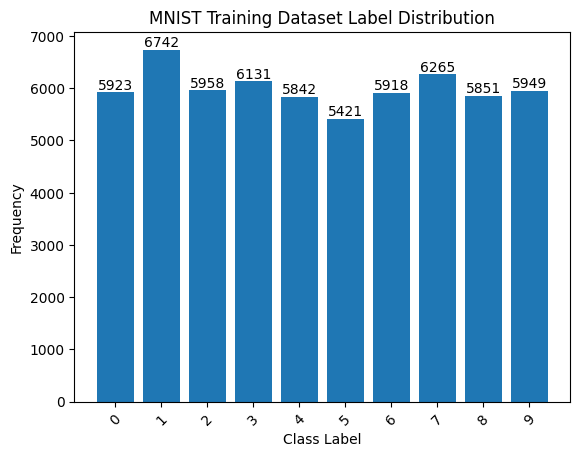

In [ ]:
# Load the MNIST dataset
mnist = load_dataset("mnist")

# Construct histogram for training labels
all_labels = mnist["train"]["label"]
all_label_counts = Counter(all_labels)

# Visualize the histogram
bar = plt.bar(all_label_counts.keys(), all_label_counts.values())
_ = plt.bar_label(bar)

# Plot formatting
plt.xticks(range(10), labels=[str(i) for i in range(10)], rotation=45)
plt.xlabel("Class Label")
plt.ylabel("Frequency")
plt.title("MNIST Training Dataset Label Distribution")
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


One Partition has 1000 examples.
One Partition has 800 examples.
Entropy: 3.3139
Max Entropy (Uniform Distribution): 3.3219
Distribution Uniformity Ratio: 0.9976


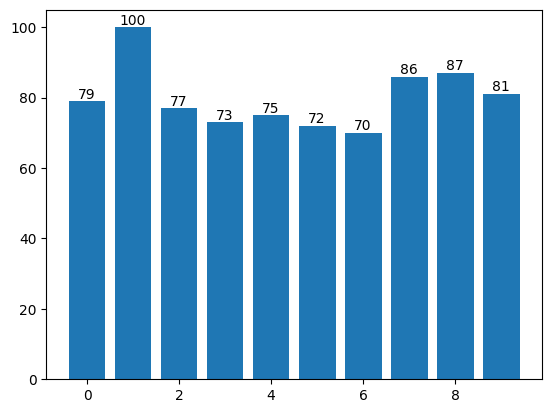

In [ ]:
num_partitions = 10  # Total number of participants
fds = FederatedDataset(
    dataset="mnist",
    partitioners={"test": num_partitions}
)

partition = fds.load_partition(0)
print(f"One Partition has {len(partition)} examples.")

# Divider : 80% train, 20% test
partition_train_test = partition.train_test_split(test_size=0.2, seed=42)
train_size = len(partition_train_test["train"])
print(f"One Partition has {train_size} examples.")

all_labels = partition_train_test["train"]["label"]

label_counts = Counter(all_labels)

# Visualize the histogram
bar = plt.bar(label_counts.keys(), label_counts.values())
_ = plt.bar_label(bar)

total_count = sum(label_counts.values())

# Calculate proportions
proportions = [count / total_count for count in label_counts.values()]

# Calculate entropy
entropy = -sum(p * np.log2(p) for p in proportions)
max_entropy = np.log2(len(label_counts))  # Maximum entropy for uniform distribution

print(f"Entropy: {entropy:.4f}")
print(f"Max Entropy (Uniform Distribution): {max_entropy:.4f}")
print(f"Distribution Uniformity Ratio: {entropy / max_entropy:.4f}")

so the data is IID

## Model

In [ ]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def reset(self):
        """Reset the model's weights to their initial state."""
        for layer in self.children():
            if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
                layer.reset_parameters()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
net = Net()
num_parameters = sum(value.numel() for value in net.state_dict().values())
print(f"{num_parameters = }")

num_parameters = 44426


In [ ]:
if torch.cuda.is_available():
    net.cuda()

## Train Test func


In [ ]:
def train(net, trainloader, optimizer, epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            images, labels = batch["image"].to(DEVICE), batch["label"].to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()

        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0

    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["image"].to(DEVICE), batch["label"].to(DEVICE)
            outputs = net(images)

            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

# Federation

## Client side

### set-get params


In [ ]:
def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    # replace the parameters
    net.load_state_dict(state_dict, strict=True)


def get_parameters(net) -> List[np.ndarray]:
    """Extract model parameters as a list of NumPy arrays."""
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

### FlowerClient

In [ ]:
class FlowerClient(NumPyClient):
    def __init__(self, pid, net, trainloader, valloader):
        self.pid = pid  # partition ID of a client
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.pid}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        # Read values from config
        server_round = config["server_round"]
        local_epochs = config["local_epochs"]
        print(f"[Client {self.pid}, round {server_round}] fit, config: {config}")

        set_parameters(self.net, parameters)
        lr = config["learning rate"]
        optim = torch.optim.SGD(self.net.parameters(), lr=lr, momentum=0.9)
        train(self.net, self.trainloader,optim , epochs=local_epochs)

        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):

        # current_round = config["server_round"]
        print(f"[Client {self.pid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)

        loss, accuracy = test(self.net, self.valloader)

        return float(loss), len(self.valloader), {"accuracy": float(accuracy), "loss": float(loss)}


### Dyamic Configs

In [ ]:
def fit_config(server_round: int):
    config = {
        "server_round": server_round,
        "local_epochs": 1 ,
        "learning rate": 0.01,
    }
    return config

In [ ]:
def evaluate_config(server_round: int):
    config = {
        "current_round": server_round,
    }
    return config

### Client func

In [ ]:
def client_fn(context: Context) -> Client:

    net = Net().to(DEVICE)

    partition_id = context.node_config["partition-id"]
    num_partitions = context.node_config["num-partitions"]

    trainloader, valloader, _ = load_datasets(partition_id, num_partitions)

    # print(f"FlowerClient is created")
    return FlowerClient(partition_id, net, trainloader, valloader).to_client()


# Create the ClientApp
# client = ClientApp(client_fn=client_fn)

## Server side

### Agregation Function

In [ ]:
Aggregation_history = []

def My_weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:

    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    losses = [num_examples * m.get("loss", 0.0) for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    accuracy = sum(accuracies) / sum(examples)
    loss = sum(losses) / sum(examples)

    # Save metrics to history
    Aggregation_history.append({
        # "round": server_round,
        "loss": loss,
        "accuracy": accuracy
    })

    print(f"My_weighted_average -{accuracy} {loss} ")

    return {"accuracy": accuracy, "loss": loss}

### Server Evaluate

In [ ]:
evaluation_history = []

def My_evaluate(
    server_round: int,
    parameters: NDArrays,
    config: Dict[str, Scalar],
    save_flag = 0,
) -> Optional[Tuple[float, Dict[str, Scalar]]]:

    net = Net().to(DEVICE)

    _, _, testloader = load_datasets(0, NUM_CLIENTS)
    set_parameters(net, parameters)  # Update model with the latest parameters
    loss, accuracy = test(net, testloader)

    print(f"Server-side evaluation loss {loss} / accuracy {accuracy}")

    # Save metrics to history
    evaluation_history.append({
        "round": server_round,
        "loss": loss,
        "accuracy": accuracy
    })

    if save_flag == 1 :
      model_filename = f"server_federated_model_{server_round}.pth"
      torch.save(net.state_dict(), model_filename)
      print(f"Model saved as {model_filename}")

    return loss, {"accuracy": accuracy}


### help funcs

In [ ]:
def plot_aggregation_history(aggregation_history):
    """Plot accuracy from Aggregation history."""
    accuracy_values = [d['accuracy'] for d in aggregation_history]
    rounds = list(range(len(accuracy_values)))

    plt.figure(figsize=(8, 6))
    plt.plot(rounds, accuracy_values, marker="o", label="Accuracy", color="tab:blue")

    # Annotate points with values
    for x, y in zip(rounds, accuracy_values):
        plt.text(x, y, f"{y:.2f}", fontsize=9, ha='center', va='bottom')

    plt.title("Cumulative Accuracy over Rounds")
    plt.xlabel("Round")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_evaluation_history(evaluation_history):
    """Plot loss and accuracy from Evaluation history."""
    rounds = [entry["round"] for entry in evaluation_history]
    loss = [entry["loss"] for entry in evaluation_history]
    accuracy = [entry["accuracy"] for entry in evaluation_history]

    fig, ax1 = plt.subplots(figsize=(8, 6))

    # Plot loss on the first y-axis
    ax1.set_xlabel("Round")
    ax1.set_ylabel("Loss", color="tab:red")
    ax1.plot(rounds, loss, marker="o", color="tab:red", label="Loss")
    ax1.tick_params(axis="y", labelcolor="tab:red")

    # Annotate loss points
    for x, y in zip(rounds, loss):
        ax1.annotate(f"{y:.2f}", (x, y), fontsize=9, color="tab:red", ha='center', va='bottom')

    # Create a second y-axis for accuracy
    ax2 = ax1.twinx()
    ax2.set_ylabel("Accuracy", color="tab:blue")
    ax2.plot(rounds, accuracy, marker="o", color="tab:blue", label="Accuracy")
    ax2.tick_params(axis="y", labelcolor="tab:blue")

    # Annotate accuracy points
    for x, y in zip(rounds, accuracy):
        ax2.annotate(f"{y:.2f}", (x, y), fontsize=9, color="tab:blue", ha='center', va='bottom')

    # Title and legend
    fig.suptitle("Server Loss and Accuracy over Training Rounds")
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")

    plt.show()


In [ ]:
def save_results(directory: str, net, aggregation_history, evaluation_history, emissions: float):
    """Save model, history, and emissions data to specified directory."""
    os.makedirs(directory, exist_ok=True)

    # Save the model
    save_path = os.path.join(directory, "net_weights.pth")
    torch.save(net.state_dict(), save_path)
    print(f"Model saved to {save_path}")

    # Save the aggregation history
    agg_history_path = os.path.join(directory, "Aggregation_history.pkl")
    with open(agg_history_path, 'wb') as agg_file:
        pickle.dump(aggregation_history, agg_file)
        print(f"Aggregation history saved to {agg_history_path}")

    # Save the evaluation history
    eval_history_path = os.path.join(directory, "evaluation_history.pkl")
    with open(eval_history_path, 'wb') as eval_file:
        pickle.dump(evaluation_history, eval_file)
        print(f"Evaluation history saved to {eval_history_path}")

    # Save the emissions data
    emissions_path = os.path.join(directory, "emissions.txt")
    with open(emissions_path, 'w') as emissions_file:
        emissions_file.write(f"Total emissions: {emissions} kg CO2e\n")
        print(f"Emissions data saved to {emissions_path}")


## My Run Function

In [ ]:
def run_my_sim(
    strategy,
    num_rounds: int,
    num_clients: int,
    save_results_flag: bool = True,
    run_simulation_flag: bool = True,
    Clientapp = None,
    save_dir: Optional[str] = None,
):
    """Run a federated learning simulation with the given parameters."""
    # Reset the model
    net.reset()
    _, valloader, _ = load_datasets(0, 1)
    _, accuracy = test(net, valloader)
    print(f"model is reset.. dont beleve me?.. acc= {accuracy} ")

    # Initialize client and server apps
    if Clientapp == None:
      client_app = ClientApp(client_fn=client_fn)
    else:
      client_app = Clientapp

    params = get_parameters(Net())

    def server_fn(context: Context) -> ServerAppComponents:
        config = ServerConfig(num_rounds=num_rounds)
        print(type(strategy).__name__)
        return ServerAppComponents(strategy=strategy, config=config)

    server = ServerApp(server_fn=server_fn)

    # Initialize history lists
    Aggregation_history.clear()
    evaluation_history.clear()

    # Backend configuration
    backend_config = None
    if torch.cuda.is_available():
        backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.5}}
        print(f"CUDA Device Name: {torch.cuda.get_device_name(0)}")
        print(f"CUDA Device Count: {torch.cuda.device_count()}")
    else:
        backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}
        print("No GPU found.")

    # ========EmissionsTracker===============
    tracker = EmissionsTracker()
    tracker.start()
    # =======================================

    # Run the simulation if the flag is enabled
    if run_simulation_flag:
        run_simulation(
            server_app=server,
            client_app=client_app,
            num_supernodes=num_clients,
            backend_config=backend_config,
        )

    # ========EmissionsTracker===============
    emissions: float = tracker.stop()
    print(f"Emissions: {emissions * 1000} g CO2eq")
    # =======================================

    # Save results if the flag is enabled
    if save_results_flag:
        strategy_name = type(strategy).__name__
        save_dir = save_dir or strategy_name  # Use provided directory or strategy name
        save_results(save_dir, net, Aggregation_history, evaluation_history, emissions)

    plot_aggregation_history(Aggregation_history)
    plot_evaluation_history(evaluation_history)


### emmision tracker

In [ ]:
# tracker = EmissionsTracker()
# tracker.start()

In [ ]:
# emissions: float = tracker.stop()
# print(f"Emissions: {emissions} kg CO2e")

# Run tests

## General

In [ ]:
Num_rounds = 30
NUM_CLIENTS = 10
params = get_parameters(Net())

In [ ]:
strategy = FedAvg(
    fraction_fit  = 1,
    fraction_evaluate = 1,
    min_fit_clients  =  5,
    min_evaluate_clients  = 2,
    min_available_clients = NUM_CLIENTS, # use all
    evaluate_fn = My_evaluate, # function used for validation dy server
    on_fit_config_fn  = fit_config,  # Pass the fit_config function
    on_evaluate_config_fn = evaluate_config,
    # accept_failures,
    initial_parameters  = ndarrays_to_parameters(params),
    evaluate_metrics_aggregation_fn =  My_weighted_average,
    # inplace,
)

## Naked FL


In [ ]:
run_my_sim(
    strategy = strategy,
    num_rounds = Num_rounds,
    num_clients = NUM_CLIENTS,
)

## DP **Server Side**

### **Fixed Clipping**

[codecarbon INFO @ 08:05:27] [setup] RAM Tracking...
[codecarbon INFO @ 08:05:27] [setup] CPU Tracking...
[codecarbon WARNING @ 08:05:27] No CPU tracking mode found. Falling back on CPU constant mode. 
 Linux OS detected: Please ensure RAPL files exist at \sys\class\powercap\intel-rapl to measure CPU



model is reset.. dont beleve me?.. acc= 0.1005 
No GPU found.


[codecarbon WARNING @ 08:05:29] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 08:05:29] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 08:05:29] [setup] GPU Tracking...
[codecarbon INFO @ 08:05:29] No GPU found.
[codecarbon INFO @ 08:05:29] >>> Tracker's metadata:
[codecarbon INFO @ 08:05:29]   Platform system: Linux-6.1.85+-x86_64-with-glibc2.35
[codecarbon INFO @ 08:05:29]   Python version: 3.10.12
[codecarbon INFO @ 08:05:29]   CodeCarbon version: 2.8.2
[codecarbon INFO @ 08:05:29]   Available RAM : 12.675 GB
[codecarbon INFO @ 08:05:29]   CPU count: 2
[codecarbon INFO @ 08:05:29]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 08:05:29]   GPU count: None
[codecarbon INFO @ 08:05:29]   GPU model: None
[codecarbon INFO @ 08:05:29] Saving emissions data to file /content/emissions.csv
DEBUG:flwr:Asyncio event loop already running.
INFO :      Starting Flower Ser

DifferentialPrivacyServerSideFixedClipping


(pid=13327) 2024-12-23 08:05:42.519596: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
INFO :      initial parameters (loss, other metrics): 0.036220349526405335, {'accuracy': 0.1062}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(pid=13327) 2024-12-23 08:05:42.565416: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=13327) 2024-12-23 08:05:42.602759: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Server-side evaluation loss 0.036220349526405335 / accuracy 0.1062


[codecarbon INFO @ 08:05:44] Energy consumed for RAM : 0.000020 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:05:44] Energy consumed for all CPUs : 0.000177 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:05:44] 0.000197 kWh of electricity used since the beginning.
(pid=13327) 2024-12-23 08:05:45.820102: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
[codecarbon INFO @ 08:05:59] Energy consumed for RAM : 0.000040 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:05:59] Energy consumed for all CPUs : 0.000354 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:05:59] 0.000394 kWh of electricity used since the beginning.


(ClientAppActor pid=13327) [Client 2, round 1] fit, config: {'server_round': 1, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=13327) [Client 4, round 1] fit, config: {'server_round': 1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)


[codecarbon INFO @ 08:06:14] Energy consumed for RAM : 0.000059 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:06:14] Energy consumed for all CPUs : 0.000531 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:06:14] 0.000591 kWh of electricity used since the beginning.


(ClientAppActor pid=13328) [Client 8, round 1] fit, config: {'server_round': 1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=13327) [Client 3, round 1] fit, config: {'server_round': 1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:06:29] Energy consumed for RAM : 0.000079 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:06:29] Energy consumed for all CPUs : 0.000708 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:06:29] 0.000787 kWh of electricity used since the beginning.


(ClientAppActor pid=13327) [Client 1, round 1] fit, config: {'server_round': 1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: central DP noise with 0.2200 stdev added
INFO :      fit progress: (1, 1.690654231262207, {'accuracy': 0.1074}, 61.10553849899998)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 1.690654231262207 / accuracy 0.1074


[codecarbon INFO @ 08:06:44] Energy consumed for RAM : 0.000099 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:06:44] Energy consumed for all CPUs : 0.000885 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:06:44] 0.000984 kWh of electricity used since the beginning.


(ClientAppActor pid=13327) [Client 3] evaluate, config: {'current_round': 1}
(ClientAppActor pid=13328) [Client 9, round 1] fit, config: {'server_round': 1, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=13328) [Client 7] evaluate, config: {'current_round': 1} [repeated 4x across cluster]
(ClientAppActor pid=13327) [Client 9] evaluate, config: {'current_round': 1} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.11083333333333334 1.6838488159179688 


[codecarbon INFO @ 08:06:59] Energy consumed for RAM : 0.000119 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:06:59] Energy consumed for all CPUs : 0.001062 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:06:59] 0.001181 kWh of electricity used since the beginning.


(ClientAppActor pid=13327) [Client 0, round 2] fit, config: {'server_round': 2, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=13327) [Client 2, round 2] fit, config: {'server_round': 2, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:07:14] Energy consumed for RAM : 0.000139 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:07:14] Energy consumed for all CPUs : 0.001239 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:07:14] 0.001378 kWh of electricity used since the beginning.


(ClientAppActor pid=13327) [Client 6, round 2] fit, config: {'server_round': 2, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=13327) [Client 5, round 2] fit, config: {'server_round': 2, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=13327) [Client 7, round 2] fit, config: {'server_round': 2, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:07:29] Energy consumed for RAM : 0.000158 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:07:29] Energy consumed for all CPUs : 0.001416 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:07:29] 0.001575 kWh of electricity used since the beginning.
[codecarbon INFO @ 08:07:29] 0.001821 g.CO2eq/s mean an estimation of 57.41243412644772 kg.CO2eq/year
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :   

Server-side evaluation loss 3.5779545486450197 / accuracy 0.0677
(ClientAppActor pid=13328) [Client 9] evaluate, config: {'current_round': 2}
(ClientAppActor pid=13328) [Client 3, round 2] fit, config: {'server_round': 2, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 08:07:44] Energy consumed for RAM : 0.000178 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:07:44] Energy consumed for all CPUs : 0.001593 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:07:44] 0.001772 kWh of electricity used since the beginning.


(ClientAppActor pid=13328) [Client 7] evaluate, config: {'current_round': 2} [repeated 5x across cluster]
(ClientAppActor pid=13328) [Client 8] evaluate, config: {'current_round': 2} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.07150000000000001 3.586459201812745 
(ClientAppActor pid=13328) [Client 0, round 3] fit, config: {'server_round': 3, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 08:07:59] Energy consumed for RAM : 0.000198 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:07:59] Energy consumed for all CPUs : 0.001770 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:07:59] 0.001968 kWh of electricity used since the beginning.


(ClientAppActor pid=13328) [Client 4, round 3] fit, config: {'server_round': 3, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=13328) [Client 6, round 3] fit, config: {'server_round': 3, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=13327) [Client 3, round 3] fit, config: {'server_round': 3, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:08:14] Energy consumed for RAM : 0.000218 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:08:14] Energy consumed for all CPUs : 0.001948 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:08:14] 0.002165 kWh of electricity used since the beginning.


(ClientAppActor pid=13327) [Client 7, round 3] fit, config: {'server_round': 3, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: central DP noise with 0.2200 stdev added
[codecarbon INFO @ 08:08:29] Energy consumed for RAM : 0.000238 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:08:29] Energy consumed for all CPUs : 0.002124 kWh. Total CPU Power

Server-side evaluation loss 9.064866744995117 / accuracy 0.0886
(ClientAppActor pid=13328) [Client 0] evaluate, config: {'current_round': 3}
(ClientAppActor pid=13328) [Client 1, round 3] fit, config: {'server_round': 3, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=13327) [Client 8] evaluate, config: {'current_round': 3} [repeated 4x across cluster]


[codecarbon INFO @ 08:08:44] Energy consumed for RAM : 0.000257 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:08:44] Energy consumed for all CPUs : 0.002301 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:08:44] 0.002559 kWh of electricity used since the beginning.


(ClientAppActor pid=13328) [Client 3] evaluate, config: {'current_round': 3} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.08875000000000001 9.113944707234701 
(ClientAppActor pid=13327) [Client 0, round 4] fit, config: {'server_round': 4, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=13327) [Client 1] evaluate, config: {'current_round': 3}
(ClientAppActor pid=13327) [Client 3, round 4] fit, config: {'server_round': 4, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:08:59] Energy consumed for RAM : 0.000277 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:08:59] Energy consumed for all CPUs : 0.002479 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:08:59] 0.002756 kWh of electricity used since the beginning.


(ClientAppActor pid=13327) [Client 7, round 4] fit, config: {'server_round': 4, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=13327) [Client 4, round 4] fit, config: {'server_round': 4, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:09:14] Energy consumed for RAM : 0.000297 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:09:14] Energy consumed for all CPUs : 0.002656 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:09:14] 0.002952 kWh of electricity used since the beginning.


(ClientAppActor pid=13327) [Client 5, round 4] fit, config: {'server_round': 4, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: central DP noise with 0.2200 stdev added
INFO :      fit progress: (4, 12.226970886230468, {'accuracy': 0.1258}, 224.65082117300017)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 12.226970886230468 / accuracy 0.1258


[codecarbon INFO @ 08:09:29] Energy consumed for RAM : 0.000317 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:09:29] Energy consumed for all CPUs : 0.002833 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:09:29] 0.003149 kWh of electricity used since the beginning.
[codecarbon INFO @ 08:09:29] 0.001820 g.CO2eq/s mean an estimation of 57.40611680891735 kg.CO2eq/year


(ClientAppActor pid=13328) [Client 3] evaluate, config: {'current_round': 4}
(ClientAppActor pid=13328) [Client 2, round 4] fit, config: {'server_round': 4, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=13327) [Client 9] evaluate, config: {'current_round': 4} [repeated 4x across cluster]
(ClientAppActor pid=13327) [Client 1] evaluate, config: {'current_round': 4} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.12324999999999998 12.289870381673175 
(ClientAppActor pid=13327) [Client 3, round 5] fit, config: {'server_round': 5, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 08:09:44] Energy consumed for RAM : 0.000336 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:09:44] Energy consumed for all CPUs : 0.003010 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:09:44] 0.003346 kWh of electricity used since the beginning.


(ClientAppActor pid=13328) [Client 4] evaluate, config: {'current_round': 4}
(ClientAppActor pid=13327) [Client 4, round 5] fit, config: {'server_round': 5, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=13327) [Client 7, round 5] fit, config: {'server_round': 5, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:09:59] Energy consumed for RAM : 0.000356 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:09:59] Energy consumed for all CPUs : 0.003187 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:09:59] 0.003543 kWh of electricity used since the beginning.


(ClientAppActor pid=13327) [Client 8, round 5] fit, config: {'server_round': 5, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=13327) [Client 0, round 5] fit, config: {'server_round': 5, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:10:14] Energy consumed for RAM : 0.000376 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:10:14] Energy consumed for all CPUs : 0.003364 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:10:14] 0.003740 kWh of electricity used since the beginning.
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are c

Server-side evaluation loss nan / accuracy 0.098
(ClientAppActor pid=13328) [Client 0] evaluate, config: {'current_round': 5}
(ClientAppActor pid=13328) [Client 2, round 5] fit, config: {'server_round': 5, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 08:10:29] Energy consumed for RAM : 0.000396 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:10:29] Energy consumed for all CPUs : 0.003541 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:10:29] 0.003937 kWh of electricity used since the beginning.


(ClientAppActor pid=13327) [Client 9] evaluate, config: {'current_round': 5} [repeated 5x across cluster]
(ClientAppActor pid=13327) [Client 8] evaluate, config: {'current_round': 5} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.09758333333333333 nan 
(ClientAppActor pid=13327) [Client 0, round 6] fit, config: {'server_round': 6, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=13327) [Client 3, round 6] fit, config: {'server_round': 6, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:10:44] Energy consumed for RAM : 0.000416 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:10:44] Energy consumed for all CPUs : 0.003718 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:10:44] 0.004134 kWh of electricity used since the beginning.


(ClientAppActor pid=13327) [Client 6, round 6] fit, config: {'server_round': 6, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=13327) [Client 8, round 6] fit, config: {'server_round': 6, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:10:59] Energy consumed for RAM : 0.000435 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:10:59] Energy consumed for all CPUs : 0.003895 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:10:59] 0.004330 kWh of electricity used since the beginning.


(ClientAppActor pid=13327) [Client 7, round 6] fit, config: {'server_round': 6, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: central DP noise with 0.2200 stdev added
[codecarbon INFO @ 08:11:14] Energy consumed for RAM : 0.000455 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:11:14] Energy consumed for all CPUs : 0.004072 kWh. Total CPU Power

Server-side evaluation loss nan / accuracy 0.098
(ClientAppActor pid=13327) [Client 2] evaluate, config: {'current_round': 6}
(ClientAppActor pid=13328) [Client 2, round 6] fit, config: {'server_round': 6, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=13328) [Client 6] evaluate, config: {'current_round': 6} [repeated 5x across cluster]
(ClientAppActor pid=13328) [Client 5] evaluate, config: {'current_round': 6} [repeated 4x across cluster]


[codecarbon INFO @ 08:11:29] Energy consumed for RAM : 0.000475 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:11:29] Energy consumed for all CPUs : 0.004249 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:11:29] 0.004724 kWh of electricity used since the beginning.
[codecarbon INFO @ 08:11:29] 0.001820 g.CO2eq/s mean an estimation of 57.40799454169539 kg.CO2eq/year
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.09758333333333333 nan 
(ClientAppActor pid=13327) [Client 1, round 7] fit, config: {'server_round': 7, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=13327) [Client 4, round 7] fit, config: {'server_round': 7, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=13327) [Client 8, round 7] fit, config: {'server_round': 7, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:11:44] Energy consumed for RAM : 0.000495 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:11:44] Energy consumed for all CPUs : 0.004426 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:11:44] 0.004921 kWh of electricity used since the beginning.


(ClientAppActor pid=13327) [Client 5, round 7] fit, config: {'server_round': 7, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=13327) [Client 3, round 7] fit, config: {'server_round': 7, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:11:59] Energy consumed for RAM : 0.000515 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:11:59] Energy consumed for all CPUs : 0.004603 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:11:59] 0.005118 kWh of electricity used since the beginning.
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are c

Server-side evaluation loss nan / accuracy 0.098
(ClientAppActor pid=13327) [Client 1] evaluate, config: {'current_round': 7}
(ClientAppActor pid=13328) [Client 2, round 7] fit, config: {'server_round': 7, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 08:12:14] Energy consumed for RAM : 0.000534 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:12:14] Energy consumed for all CPUs : 0.004781 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:12:14] 0.005315 kWh of electricity used since the beginning.


(ClientAppActor pid=13327) [Client 7] evaluate, config: {'current_round': 7} [repeated 4x across cluster]
(ClientAppActor pid=13328) [Client 5] evaluate, config: {'current_round': 7} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.09758333333333333 nan 
(ClientAppActor pid=13327) [Client 3, round 8] fit, config: {'server_round': 8, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 08:12:29] Energy consumed for RAM : 0.000554 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:12:29] Energy consumed for all CPUs : 0.004958 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:12:29] 0.005512 kWh of electricity used since the beginning.


(ClientAppActor pid=13327) [Client 5, round 8] fit, config: {'server_round': 8, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=13327) [Client 8, round 8] fit, config: {'server_round': 8, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:12:44] Energy consumed for RAM : 0.000574 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:12:44] Energy consumed for all CPUs : 0.005135 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:12:44] 0.005709 kWh of electricity used since the beginning.


(ClientAppActor pid=13327) [Client 6, round 8] fit, config: {'server_round': 8, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=13327) [Client 1, round 8] fit, config: {'server_round': 8, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: central DP noise with 0.2200 stdev added
[codecarbon INFO @ 08:12:59] Energy consumed for RAM : 0.000594 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:12:59] Energy consumed for all CPUs : 0.005312 kWh. Total CPU Power

Server-side evaluation loss nan / accuracy 0.098
(ClientAppActor pid=13328) [Client 4] evaluate, config: {'current_round': 8}
(ClientAppActor pid=13328) [Client 4, round 8] fit, config: {'server_round': 8, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=13327) [Client 9] evaluate, config: {'current_round': 8} [repeated 4x across cluster]


[codecarbon INFO @ 08:13:14] Energy consumed for RAM : 0.000614 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:13:14] Energy consumed for all CPUs : 0.005488 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:13:14] 0.006102 kWh of electricity used since the beginning.


(ClientAppActor pid=13327) [Client 3] evaluate, config: {'current_round': 8} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.09758333333333333 nan 
(ClientAppActor pid=13327) [Client 1, round 9] fit, config: {'server_round': 9, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=13328) [Client 1] evaluate, config: {'current_round': 8}
(ClientAppActor pid=13328) [Client 2, round 9] fit, config: {'server_round': 9, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:13:29] Energy consumed for RAM : 0.000633 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:13:29] Energy consumed for all CPUs : 0.005666 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:13:29] 0.006299 kWh of electricity used since the beginning.
[codecarbon INFO @ 08:13:29] 0.001820 g.CO2eq/s mean an estimation of 57.40374867287384 kg.CO2eq/year


(ClientAppActor pid=13328) [Client 5, round 9] fit, config: {'server_round': 9, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=13328) [Client 7, round 9] fit, config: {'server_round': 9, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=13328) [Client 9, round 9] fit, config: {'server_round': 9, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:13:44] Energy consumed for RAM : 0.000653 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:13:44] Energy consumed for all CPUs : 0.005843 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:13:44] 0.006496 kWh of electricity used since the beginning.
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are c

Server-side evaluation loss nan / accuracy 0.098
(ClientAppActor pid=13328) [Client 1] evaluate, config: {'current_round': 9}
(ClientAppActor pid=13327) [Client 4, round 9] fit, config: {'server_round': 9, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 08:13:59] Energy consumed for RAM : 0.000673 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:13:59] Energy consumed for all CPUs : 0.006020 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:13:59] 0.006693 kWh of electricity used since the beginning.


(ClientAppActor pid=13328) [Client 7] evaluate, config: {'current_round': 9} [repeated 4x across cluster]
(ClientAppActor pid=13327) [Client 3] evaluate, config: {'current_round': 9} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.09758333333333334 nan 
(ClientAppActor pid=13327) [Client 0, round 10] fit, config: {'server_round': 10, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 08:14:14] Energy consumed for RAM : 0.000693 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:14:14] Energy consumed for all CPUs : 0.006197 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:14:14] 0.006890 kWh of electricity used since the beginning.


(ClientAppActor pid=13328) [Client 4, round 10] fit, config: {'server_round': 10, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=13327) [Client 7, round 10] fit, config: {'server_round': 10, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:14:29] Energy consumed for RAM : 0.000713 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:14:29] Energy consumed for all CPUs : 0.006374 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:14:29] 0.007086 kWh of electricity used since the beginning.


(ClientAppActor pid=13327) [Client 2, round 10] fit, config: {'server_round': 10, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=13327) [Client 6, round 10] fit, config: {'server_round': 10, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: central DP noise with 0.2200 stdev added
[codecarbon INFO @ 08:14:44] Energy consumed for RAM : 0.000732 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:14:44] Energy consumed for all CPUs : 0.006551 kWh. Total CPU Power

Server-side evaluation loss nan / accuracy 0.098
(ClientAppActor pid=13328) [Client 0] evaluate, config: {'current_round': 10}
(ClientAppActor pid=13328) [Client 8, round 10] fit, config: {'server_round': 10, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=13327) [Client 8] evaluate, config: {'current_round': 10} [repeated 5x across cluster]


[codecarbon INFO @ 08:14:59] Energy consumed for RAM : 0.000752 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:14:59] Energy consumed for all CPUs : 0.006728 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:14:59] 0.007480 kWh of electricity used since the beginning.


(ClientAppActor pid=13327) [Client 5] evaluate, config: {'current_round': 10} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.09758333333333334 nan 
(ClientAppActor pid=13327) [Client 1, round 11] fit, config: {'server_round': 11, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=13327) [Client 4, round 11] fit, config: {'server_round': 11, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:15:14] Energy consumed for RAM : 0.000772 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:15:14] Energy consumed for all CPUs : 0.006905 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:15:14] 0.007677 kWh of electricity used since the beginning.


(ClientAppActor pid=13328) [Client 9, round 11] fit, config: {'server_round': 11, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=13328) [Client 2, round 11] fit, config: {'server_round': 11, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:15:29] Energy consumed for RAM : 0.000792 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:15:29] Energy consumed for all CPUs : 0.007082 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:15:29] 0.007874 kWh of electricity used since the beginning.
[codecarbon INFO @ 08:15:29] 0.001820 g.CO2eq/s mean an estimation of 57.40464217471626 kg.CO2eq/year


(ClientAppActor pid=13328) [Client 0, round 11] fit, config: {'server_round': 11, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: central DP noise with 0.2200 stdev added
INFO :      fit progress: (11, nan, {'accuracy': 0.098}, 601.6441507919999)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
[codecarbon INFO @ 08:15:44] Energy consum

Server-side evaluation loss nan / accuracy 0.098
(ClientAppActor pid=13327) [Client 0] evaluate, config: {'current_round': 11}
(ClientAppActor pid=13327) [Client 8, round 11] fit, config: {'server_round': 11, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=13328) [Client 7] evaluate, config: {'current_round': 11} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.09758333333333333 nan 
(ClientAppActor pid=13328) [Client 0, round 12] fit, config: {'server_round': 12, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=13328) [Client 9] evaluate, config: {'current_round': 11} [repeated 4x across cluster]


[codecarbon INFO @ 08:15:59] Energy consumed for RAM : 0.000831 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:15:59] Energy consumed for all CPUs : 0.007436 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:15:59] 0.008268 kWh of electricity used since the beginning.


(ClientAppActor pid=13328) [Client 4, round 12] fit, config: {'server_round': 12, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=13328) [Client 6, round 12] fit, config: {'server_round': 12, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:16:14] Energy consumed for RAM : 0.000851 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:16:14] Energy consumed for all CPUs : 0.007613 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:16:14] 0.008464 kWh of electricity used since the beginning.


(ClientAppActor pid=13328) [Client 3, round 12] fit, config: {'server_round': 12, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=13328) [Client 2, round 12] fit, config: {'server_round': 12, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:16:29] Energy consumed for RAM : 0.000871 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:16:29] Energy consumed for all CPUs : 0.007790 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:16:29] 0.008661 kWh of electricity used since the beginning.
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are c

Server-side evaluation loss nan / accuracy 0.098
(ClientAppActor pid=13327) [Client 2] evaluate, config: {'current_round': 12}
(ClientAppActor pid=13327) [Client 7, round 12] fit, config: {'server_round': 12, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 08:16:44] Energy consumed for RAM : 0.000891 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:16:44] Energy consumed for all CPUs : 0.007967 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:16:44] 0.008858 kWh of electricity used since the beginning.


(ClientAppActor pid=13328) [Client 9] evaluate, config: {'current_round': 12} [repeated 4x across cluster]
(ClientAppActor pid=13328) [Client 1] evaluate, config: {'current_round': 12} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.09758333333333333 nan 
(ClientAppActor pid=13328) [Client 2, round 13] fit, config: {'server_round': 13, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 08:16:59] Energy consumed for RAM : 0.000911 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:16:59] Energy consumed for all CPUs : 0.008144 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:16:59] 0.009055 kWh of electricity used since the beginning.


(ClientAppActor pid=13327) [Client 6] evaluate, config: {'current_round': 12}
(ClientAppActor pid=13328) [Client 4, round 13] fit, config: {'server_round': 13, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=13327) [Client 9, round 13] fit, config: {'server_round': 13, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=13328) [Client 7, round 13] fit, config: {'server_round': 13, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:17:14] Energy consumed for RAM : 0.000930 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:17:14] Energy consumed for all CPUs : 0.008321 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:17:14] 0.009252 kWh of electricity used since the beginning.


(ClientAppActor pid=13328) [Client 3, round 13] fit, config: {'server_round': 13, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: central DP noise with 0.2200 stdev added
[codecarbon INFO @ 08:17:29] Energy consumed for RAM : 0.000950 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:17:29] Energy consumed for all CPUs : 0.008498 kWh. Total CPU Power

Server-side evaluation loss nan / accuracy 0.098
(ClientAppActor pid=13328) [Client 2] evaluate, config: {'current_round': 13}
(ClientAppActor pid=13327) [Client 0, round 13] fit, config: {'server_round': 13, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=13327) [Client 9] evaluate, config: {'current_round': 13} [repeated 4x across cluster]
(ClientAppActor pid=13328) [Client 7] evaluate, config: {'current_round': 13} [repeated 5x across cluster]


[codecarbon INFO @ 08:17:44] Energy consumed for RAM : 0.000970 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:17:44] Energy consumed for all CPUs : 0.008676 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:17:44] 0.009646 kWh of electricity used since the beginning.
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.09758333333333333 nan 
(ClientAppActor pid=13328) [Client 0, round 14] fit, config: {'server_round': 14, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=13327) [Client 5, round 14] fit, config: {'server_round': 14, 'local_epochs': 1, 'learning rate': 0.01} [repeated 3x across cluster]


[codecarbon INFO @ 08:17:59] Energy consumed for RAM : 0.000990 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:17:59] Energy consumed for all CPUs : 0.008853 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:17:59] 0.009842 kWh of electricity used since the beginning.


(ClientAppActor pid=13327) [Client 7, round 14] fit, config: {'server_round': 14, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=13327) [Client 2, round 14] fit, config: {'server_round': 14, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=13327) [Client 8, round 14] fit, config: {'server_round': 14, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:18:14] Energy consumed for RAM : 0.001009 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:18:14] Energy consumed for all CPUs : 0.009030 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:18:14] 0.010039 kWh of electricity used since the beginning.
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are c

Server-side evaluation loss nan / accuracy 0.098
(ClientAppActor pid=13327) [Client 0] evaluate, config: {'current_round': 14}


[codecarbon INFO @ 08:18:29] Energy consumed for RAM : 0.001029 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:18:29] Energy consumed for all CPUs : 0.009207 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:18:29] 0.010236 kWh of electricity used since the beginning.


(ClientAppActor pid=13328) [Client 9] evaluate, config: {'current_round': 14} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.09758333333333333 nan 
(ClientAppActor pid=13327) [Client 3, round 15] fit, config: {'server_round': 15, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=13328) [Client 7] evaluate, config: {'current_round': 14} [repeated 4x across cluster]


[codecarbon INFO @ 08:18:44] Energy consumed for RAM : 0.001049 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:18:44] Energy consumed for all CPUs : 0.009384 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:18:44] 0.010433 kWh of electricity used since the beginning.


(ClientAppActor pid=13327) [Client 4, round 15] fit, config: {'server_round': 15, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=13327) [Client 6, round 15] fit, config: {'server_round': 15, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=13327) [Client 0, round 15] fit, config: {'server_round': 15, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:18:59] Energy consumed for RAM : 0.001069 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:18:59] Energy consumed for all CPUs : 0.009561 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:18:59] 0.010630 kWh of electricity used since the beginning.


(ClientAppActor pid=13327) [Client 7, round 15] fit, config: {'server_round': 15, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: central DP noise with 0.2200 stdev added
[codecarbon INFO @ 08:19:14] Energy consumed for RAM : 0.001089 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:19:14] Energy consumed for all CPUs : 0.009738 kWh. Total CPU Power

Server-side evaluation loss nan / accuracy 0.098
(ClientAppActor pid=13327) [Client 2] evaluate, config: {'current_round': 15}
(ClientAppActor pid=13328) [Client 8, round 15] fit, config: {'server_round': 15, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=13327) [Client 7] evaluate, config: {'current_round': 15} [repeated 4x across cluster]
(ClientAppActor pid=13327) [Client 9] evaluate, config: {'current_round': 15} [repeated 4x across cluster]


[codecarbon INFO @ 08:19:29] Energy consumed for RAM : 0.001108 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:19:29] Energy consumed for all CPUs : 0.009915 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:19:29] 0.011023 kWh of electricity used since the beginning.
[codecarbon INFO @ 08:19:29] 0.001820 g.CO2eq/s mean an estimation of 57.39664177879161 kg.CO2eq/year
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.09758333333333333 nan 
(ClientAppActor pid=13327) [Client 1, round 16] fit, config: {'server_round': 16, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=13328) [Client 6] evaluate, config: {'current_round': 15}
(ClientAppActor pid=13327) [Client 4, round 16] fit, config: {'server_round': 16, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:19:44] Energy consumed for RAM : 0.001128 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:19:44] Energy consumed for all CPUs : 0.010092 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:19:44] 0.011220 kWh of electricity used since the beginning.


(ClientAppActor pid=13327) [Client 7, round 16] fit, config: {'server_round': 16, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=13328) [Client 6, round 16] fit, config: {'server_round': 16, 'local_epochs': 1, 'learning rate': 0.01} [repeated 3x across cluster]
(ClientAppActor pid=13328) [Client 3, round 16] fit, config: {'server_round': 16, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:19:59] Energy consumed for RAM : 0.001148 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:19:59] Energy consumed for all CPUs : 0.010269 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:19:59] 0.011417 kWh of electricity used since the beginning.
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are c

Server-side evaluation loss nan / accuracy 0.098
(ClientAppActor pid=13327) [Client 4] evaluate, config: {'current_round': 16}


[codecarbon INFO @ 08:20:14] Energy consumed for RAM : 0.001168 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:20:14] Energy consumed for all CPUs : 0.010446 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:20:14] 0.011614 kWh of electricity used since the beginning.


(ClientAppActor pid=13327) [Client 9] evaluate, config: {'current_round': 16} [repeated 4x across cluster]
(ClientAppActor pid=13328) [Client 0] evaluate, config: {'current_round': 16} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.09758333333333333 nan 
(ClientAppActor pid=13327) [Client 1, round 17] fit, config: {'server_round': 17, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 08:20:29] Energy consumed for RAM : 0.001188 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:20:29] Energy consumed for all CPUs : 0.010623 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:20:29] 0.011811 kWh of electricity used since the beginning.


(ClientAppActor pid=13327) [Client 6] evaluate, config: {'current_round': 16}
(ClientAppActor pid=13327) [Client 3, round 17] fit, config: {'server_round': 17, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=13327) [Client 7, round 17] fit, config: {'server_round': 17, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:20:44] Energy consumed for RAM : 0.001207 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:20:44] Energy consumed for all CPUs : 0.010800 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:20:44] 0.012007 kWh of electricity used since the beginning.


(ClientAppActor pid=13327) [Client 0, round 17] fit, config: {'server_round': 17, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=13327) [Client 4, round 17] fit, config: {'server_round': 17, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: central DP noise with 0.2200 stdev added
[codecarbon INFO @ 08:20:59] Energy consumed for RAM : 0.001227 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:20:59] Energy consumed for all CPUs : 0.010977 kWh. Total CPU Power

Server-side evaluation loss nan / accuracy 0.098
(ClientAppActor pid=13327) [Client 3] evaluate, config: {'current_round': 17}
(ClientAppActor pid=13328) [Client 5, round 17] fit, config: {'server_round': 17, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=13327) [Client 8] evaluate, config: {'current_round': 17} [repeated 4x across cluster]


[codecarbon INFO @ 08:21:14] Energy consumed for RAM : 0.001247 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:21:14] Energy consumed for all CPUs : 0.011154 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:21:14] 0.012401 kWh of electricity used since the beginning.


(ClientAppActor pid=13327) [Client 5] evaluate, config: {'current_round': 17} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.09758333333333333 nan 
(ClientAppActor pid=13327) [Client 3, round 18] fit, config: {'server_round': 18, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=13328) [Client 6] evaluate, config: {'current_round': 17}
(ClientAppActor pid=13327) [Client 7, round 18] fit, config: {'server_round': 18, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:21:29] Energy consumed for RAM : 0.001267 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:21:29] Energy consumed for all CPUs : 0.011331 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:21:29] 0.012598 kWh of electricity used since the beginning.
[codecarbon INFO @ 08:21:29] 0.001820 g.CO2eq/s mean an estimation of 57.40975911339511 kg.CO2eq/year


(ClientAppActor pid=13327) [Client 8, round 18] fit, config: {'server_round': 18, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=13327) [Client 2, round 18] fit, config: {'server_round': 18, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:21:44] Energy consumed for RAM : 0.001287 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:21:44] Energy consumed for all CPUs : 0.011508 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:21:44] 0.012795 kWh of electricity used since the beginning.


(ClientAppActor pid=13327) [Client 5, round 18] fit, config: {'server_round': 18, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: central DP noise with 0.2200 stdev added
INFO :      fit progress: (18, nan, {'accuracy': 0.098}, 975.6799142949999)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss nan / accuracy 0.098


[codecarbon INFO @ 08:21:59] Energy consumed for RAM : 0.001306 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:21:59] Energy consumed for all CPUs : 0.011685 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:21:59] 0.012991 kWh of electricity used since the beginning.


(ClientAppActor pid=13328) [Client 0] evaluate, config: {'current_round': 18}
(ClientAppActor pid=13328) [Client 4, round 18] fit, config: {'server_round': 18, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=13327) [Client 9] evaluate, config: {'current_round': 18} [repeated 5x across cluster]
(ClientAppActor pid=13327) [Client 1] evaluate, config: {'current_round': 18} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.09758333333333333 nan 
(ClientAppActor pid=13327) [Client 2, round 19] fit, config: {'server_round': 19, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 08:22:14] Energy consumed for RAM : 0.001326 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:22:14] Energy consumed for all CPUs : 0.011862 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:22:14] 0.013188 kWh of electricity used since the beginning.


(ClientAppActor pid=13328) [Client 5, round 19] fit, config: {'server_round': 19, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=13328) [Client 7, round 19] fit, config: {'server_round': 19, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:22:29] Energy consumed for RAM : 0.001346 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:22:29] Energy consumed for all CPUs : 0.012039 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:22:29] 0.013385 kWh of electricity used since the beginning.


(ClientAppActor pid=13328) [Client 0, round 19] fit, config: {'server_round': 19, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=13328) [Client 9, round 19] fit, config: {'server_round': 19, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:22:44] Energy consumed for RAM : 0.001366 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:22:44] Energy consumed for all CPUs : 0.012216 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:22:44] 0.013582 kWh of electricity used since the beginning.
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are c

Server-side evaluation loss nan / accuracy 0.098
(ClientAppActor pid=13327) [Client 0] evaluate, config: {'current_round': 19}
(ClientAppActor pid=13327) [Client 6, round 19] fit, config: {'server_round': 19, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=13328) [Client 9] evaluate, config: {'current_round': 19} [repeated 4x across cluster]


[codecarbon INFO @ 08:22:59] Energy consumed for RAM : 0.001386 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:22:59] Energy consumed for all CPUs : 0.012393 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:22:59] 0.013779 kWh of electricity used since the beginning.


(ClientAppActor pid=13327) [Client 6] evaluate, config: {'current_round': 19} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.09758333333333334 nan 
(ClientAppActor pid=13328) [Client 2, round 20] fit, config: {'server_round': 20, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=13327) [Client 5, round 20] fit, config: {'server_round': 20, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:23:14] Energy consumed for RAM : 0.001405 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:23:14] Energy consumed for all CPUs : 0.012570 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:23:14] 0.013976 kWh of electricity used since the beginning.


(ClientAppActor pid=13327) [Client 6, round 20] fit, config: {'server_round': 20, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=13327) [Client 3, round 20] fit, config: {'server_round': 20, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:23:29] Energy consumed for RAM : 0.001425 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:23:29] Energy consumed for all CPUs : 0.012747 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:23:29] 0.014173 kWh of electricity used since the beginning.
[codecarbon INFO @ 08:23:29] 0.001820 g.CO2eq/s mean an estimation of 57.41092136782666 kg.CO2eq/year


(ClientAppActor pid=13328) [Client 9, round 20] fit, config: {'server_round': 20, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: central DP noise with 0.2200 stdev added
INFO :      fit progress: (20, nan, {'accuracy': 0.098}, 1081.7059985310002)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
[codecarbon INFO @ 08:23:44] Energy consu

Server-side evaluation loss nan / accuracy 0.098


[codecarbon INFO @ 08:23:44] 0.014370 kWh of electricity used since the beginning.


(ClientAppActor pid=13328) [Client 3] evaluate, config: {'current_round': 20}
(ClientAppActor pid=13327) [Client 8, round 20] fit, config: {'server_round': 20, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=13327) [Client 8] evaluate, config: {'current_round': 20} [repeated 4x across cluster]
(ClientAppActor pid=13327) [Client 1] evaluate, config: {'current_round': 20} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.09758333333333334 nan 


[codecarbon INFO @ 08:23:59] Energy consumed for RAM : 0.001465 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:23:59] Energy consumed for all CPUs : 0.013102 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:23:59] 0.014566 kWh of electricity used since the beginning.


(ClientAppActor pid=13327) [Client 5, round 21] fit, config: {'server_round': 21, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=13328) [Client 9] evaluate, config: {'current_round': 20}
(ClientAppActor pid=13328) [Client 6, round 21] fit, config: {'server_round': 21, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=13328) [Client 8, round 21] fit, config: {'server_round': 21, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:24:14] Energy consumed for RAM : 0.001485 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:24:14] Energy consumed for all CPUs : 0.013279 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:24:14] 0.014763 kWh of electricity used since the beginning.


(ClientAppActor pid=13328) [Client 4, round 21] fit, config: {'server_round': 21, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=13328) [Client 0, round 21] fit, config: {'server_round': 21, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:24:29] Energy consumed for RAM : 0.001504 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:24:29] Energy consumed for all CPUs : 0.013456 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:24:29] 0.014960 kWh of electricity used since the beginning.
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are c

Server-side evaluation loss nan / accuracy 0.098
(ClientAppActor pid=13328) [Client 2] evaluate, config: {'current_round': 21}
(ClientAppActor pid=13327) [Client 3, round 21] fit, config: {'server_round': 21, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 08:24:44] Energy consumed for RAM : 0.001524 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:24:44] Energy consumed for all CPUs : 0.013633 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:24:44] 0.015157 kWh of electricity used since the beginning.


(ClientAppActor pid=13328) [Client 6] evaluate, config: {'current_round': 21} [repeated 4x across cluster]
(ClientAppActor pid=13327) [Client 0] evaluate, config: {'current_round': 21} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.09758333333333333 nan 
(ClientAppActor pid=13328) [Client 0, round 22] fit, config: {'server_round': 22, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 08:24:59] Energy consumed for RAM : 0.001544 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:24:59] Energy consumed for all CPUs : 0.013810 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:24:59] 0.015354 kWh of electricity used since the beginning.


(ClientAppActor pid=13328) [Client 9] evaluate, config: {'current_round': 21}
(ClientAppActor pid=13328) [Client 4, round 22] fit, config: {'server_round': 22, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=13328) [Client 8, round 22] fit, config: {'server_round': 22, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:25:14] Energy consumed for RAM : 0.001564 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:25:14] Energy consumed for all CPUs : 0.013987 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:25:14] 0.015550 kWh of electricity used since the beginning.


(ClientAppActor pid=13328) [Client 3, round 22] fit, config: {'server_round': 22, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=13328) [Client 1, round 22] fit, config: {'server_round': 22, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: central DP noise with 0.2200 stdev added
[codecarbon INFO @ 08:25:29] Energy consumed for RAM : 0.001583 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:25:29] Energy consumed for all CPUs : 0.014164 kWh. Total CPU Power

Server-side evaluation loss nan / accuracy 0.098
(ClientAppActor pid=13327) [Client 0] evaluate, config: {'current_round': 22}
(ClientAppActor pid=13327) [Client 6, round 22] fit, config: {'server_round': 22, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=13328) [Client 5] evaluate, config: {'current_round': 22} [repeated 4x across cluster]


[codecarbon INFO @ 08:25:44] Energy consumed for RAM : 0.001603 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:25:44] Energy consumed for all CPUs : 0.014341 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:25:44] 0.015944 kWh of electricity used since the beginning.


(ClientAppActor pid=13328) [Client 9] evaluate, config: {'current_round': 22} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.09758333333333333 nan 
(ClientAppActor pid=13327) [Client 1, round 23] fit, config: {'server_round': 23, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=13327) [Client 6] evaluate, config: {'current_round': 22}
(ClientAppActor pid=13328) [Client 3, round 23] fit, config: {'server_round': 23, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:25:59] Energy consumed for RAM : 0.001623 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:25:59] Energy consumed for all CPUs : 0.014518 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:25:59] 0.016141 kWh of electricity used since the beginning.


(ClientAppActor pid=13328) [Client 6, round 23] fit, config: {'server_round': 23, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=13328) [Client 8, round 23] fit, config: {'server_round': 23, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:26:14] Energy consumed for RAM : 0.001643 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:26:14] Energy consumed for all CPUs : 0.014695 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:26:14] 0.016338 kWh of electricity used since the beginning.


(ClientAppActor pid=13328) [Client 5, round 23] fit, config: {'server_round': 23, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: central DP noise with 0.2200 stdev added
INFO :      fit progress: (23, nan, {'accuracy': 0.098}, 1245.4790643360002)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss nan / accuracy 0.098


[codecarbon INFO @ 08:26:29] Energy consumed for RAM : 0.001663 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:26:29] Energy consumed for all CPUs : 0.014872 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:26:29] 0.016535 kWh of electricity used since the beginning.


(ClientAppActor pid=13328) [Client 2] evaluate, config: {'current_round': 23}
(ClientAppActor pid=13327) [Client 0, round 23] fit, config: {'server_round': 23, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=13327) [Client 6] evaluate, config: {'current_round': 23} [repeated 4x across cluster]
(ClientAppActor pid=13327) [Client 5] evaluate, config: {'current_round': 23} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.09758333333333333 nan 
(ClientAppActor pid=13328) [Client 0, round 24] fit, config: {'server_round': 24, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 08:26:44] Energy consumed for RAM : 0.001682 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:26:44] Energy consumed for all CPUs : 0.015049 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:26:44] 0.016732 kWh of electricity used since the beginning.


(ClientAppActor pid=13328) [Client 8] evaluate, config: {'current_round': 23}
(ClientAppActor pid=13327) [Client 5, round 24] fit, config: {'server_round': 24, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:26:59] Energy consumed for RAM : 0.001702 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:26:59] Energy consumed for all CPUs : 0.015226 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:26:59] 0.016928 kWh of electricity used since the beginning.


(ClientAppActor pid=13327) [Client 7, round 24] fit, config: {'server_round': 24, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=13327) [Client 6, round 24] fit, config: {'server_round': 24, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=13327) [Client 3, round 24] fit, config: {'server_round': 24, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:27:14] Energy consumed for RAM : 0.001722 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:27:14] Energy consumed for all CPUs : 0.015403 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:27:14] 0.017125 kWh of electricity used since the beginning.
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are c

Server-side evaluation loss nan / accuracy 0.098
(ClientAppActor pid=13327) [Client 3] evaluate, config: {'current_round': 24}
(ClientAppActor pid=13328) [Client 2, round 24] fit, config: {'server_round': 24, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 08:27:29] Energy consumed for RAM : 0.001742 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:27:29] Energy consumed for all CPUs : 0.015580 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:27:29] 0.017322 kWh of electricity used since the beginning.
[codecarbon INFO @ 08:27:29] 0.001820 g.CO2eq/s mean an estimation of 57.41006741061107 kg.CO2eq/year


(ClientAppActor pid=13327) [Client 7] evaluate, config: {'current_round': 24} [repeated 4x across cluster]
(ClientAppActor pid=13327) [Client 9] evaluate, config: {'current_round': 24} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.09758333333333333 nan 
(ClientAppActor pid=13327) [Client 4, round 25] fit, config: {'server_round': 25, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 08:27:44] Energy consumed for RAM : 0.001762 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:27:44] Energy consumed for all CPUs : 0.015757 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:27:44] 0.017519 kWh of electricity used since the beginning.


(ClientAppActor pid=13328) [Client 2] evaluate, config: {'current_round': 24}
(ClientAppActor pid=13327) [Client 5, round 25] fit, config: {'server_round': 25, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=13327) [Client 8, round 25] fit, config: {'server_round': 25, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:27:59] Energy consumed for RAM : 0.001781 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:27:59] Energy consumed for all CPUs : 0.015934 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:27:59] 0.017715 kWh of electricity used since the beginning.


(ClientAppActor pid=13328) [Client 2, round 25] fit, config: {'server_round': 25, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=13327) [Client 1, round 25] fit, config: {'server_round': 25, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:28:14] Energy consumed for RAM : 0.001801 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:28:14] Energy consumed for all CPUs : 0.016111 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:28:14] 0.017912 kWh of electricity used since the beginning.
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are c

Server-side evaluation loss nan / accuracy 0.098
(ClientAppActor pid=13327) [Client 1] evaluate, config: {'current_round': 25}
(ClientAppActor pid=13328) [Client 3, round 25] fit, config: {'server_round': 25, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=13327) [Client 8] evaluate, config: {'current_round': 25} [repeated 4x across cluster]


[codecarbon INFO @ 08:28:29] Energy consumed for RAM : 0.001821 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:28:29] Energy consumed for all CPUs : 0.016288 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:28:29] 0.018109 kWh of electricity used since the beginning.


(ClientAppActor pid=13328) [Client 2] evaluate, config: {'current_round': 25} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.09758333333333334 nan 
(ClientAppActor pid=13327) [Client 1, round 26] fit, config: {'server_round': 26, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=13328) [Client 7, round 26] fit, config: {'server_round': 26, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:28:44] Energy consumed for RAM : 0.001841 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:28:44] Energy consumed for all CPUs : 0.016465 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:28:44] 0.018306 kWh of electricity used since the beginning.


(ClientAppActor pid=13327) [Client 9, round 26] fit, config: {'server_round': 26, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=13327) [Client 5, round 26] fit, config: {'server_round': 26, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:28:59] Energy consumed for RAM : 0.001861 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:28:59] Energy consumed for all CPUs : 0.016642 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:28:59] 0.018503 kWh of electricity used since the beginning.


(ClientAppActor pid=13327) [Client 3, round 26] fit, config: {'server_round': 26, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: central DP noise with 0.2200 stdev added
[codecarbon INFO @ 08:29:14] Energy consumed for RAM : 0.001880 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:29:14] Energy consumed for all CPUs : 0.016819 kWh. Total CPU Power

Server-side evaluation loss nan / accuracy 0.098
(ClientAppActor pid=13327) [Client 1] evaluate, config: {'current_round': 26}
(ClientAppActor pid=13328) [Client 6, round 26] fit, config: {'server_round': 26, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=13327) [Client 7] evaluate, config: {'current_round': 26} [repeated 4x across cluster]


[codecarbon INFO @ 08:29:29] Energy consumed for RAM : 0.001900 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:29:29] Energy consumed for all CPUs : 0.016996 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:29:29] 0.018896 kWh of electricity used since the beginning.
[codecarbon INFO @ 08:29:29] 0.001820 g.CO2eq/s mean an estimation of 57.40092008057196 kg.CO2eq/year


(ClientAppActor pid=13327) [Client 9] evaluate, config: {'current_round': 26} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.09758333333333333 nan 
(ClientAppActor pid=13328) [Client 0, round 27] fit, config: {'server_round': 27, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=13328) [Client 5] evaluate, config: {'current_round': 26}
(ClientAppActor pid=13328) [Client 4, round 27] fit, config: {'server_round': 27, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:29:44] Energy consumed for RAM : 0.001920 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:29:44] Energy consumed for all CPUs : 0.017173 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:29:44] 0.019093 kWh of electricity used since the beginning.


(ClientAppActor pid=13328) [Client 6, round 27] fit, config: {'server_round': 27, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=13328) [Client 2, round 27] fit, config: {'server_round': 27, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:29:59] Energy consumed for RAM : 0.001940 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:29:59] Energy consumed for all CPUs : 0.017350 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:29:59] 0.019290 kWh of electricity used since the beginning.


(ClientAppActor pid=13328) [Client 9, round 27] fit, config: {'server_round': 27, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: central DP noise with 0.2200 stdev added
INFO :      fit progress: (27, nan, {'accuracy': 0.098}, 1468.7863689760002)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss nan / accuracy 0.098
(ClientAppActor pid=13328) [Client 1] evaluate, config: {'current_round': 27}
(ClientAppActor pid=13327) [Client 1, round 27] fit, config: {'server_round': 27, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 08:30:14] Energy consumed for RAM : 0.001959 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:30:14] Energy consumed for all CPUs : 0.017527 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:30:14] 0.019487 kWh of electricity used since the beginning.


(ClientAppActor pid=13328) [Client 8] evaluate, config: {'current_round': 27} [repeated 5x across cluster]
(ClientAppActor pid=13327) [Client 9] evaluate, config: {'current_round': 27} [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.09758333333333334 nan 
(ClientAppActor pid=13328) [Client 1, round 28] fit, config: {'server_round': 28, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 08:30:29] Energy consumed for RAM : 0.001979 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:30:29] Energy consumed for all CPUs : 0.017704 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:30:29] 0.019684 kWh of electricity used since the beginning.


(ClientAppActor pid=13328) [Client 6] evaluate, config: {'current_round': 27}
(ClientAppActor pid=13328) [Client 3, round 28] fit, config: {'server_round': 28, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=13328) [Client 7, round 28] fit, config: {'server_round': 28, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:30:44] Energy consumed for RAM : 0.001999 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:30:44] Energy consumed for all CPUs : 0.017881 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:30:44] 0.019880 kWh of electricity used since the beginning.


(ClientAppActor pid=13328) [Client 5, round 28] fit, config: {'server_round': 28, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=13328) [Client 6, round 28] fit, config: {'server_round': 28, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: central DP noise with 0.2200 stdev added
[codecarbon INFO @ 08:30:59] Energy consumed for RAM : 0.002019 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:30:59] Energy consumed for all CPUs : 0.018058 kWh. Total CPU Power

Server-side evaluation loss nan / accuracy 0.098
(ClientAppActor pid=13327) [Client 0] evaluate, config: {'current_round': 28}
(ClientAppActor pid=13327) [Client 8, round 28] fit, config: {'server_round': 28, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=13327) [Client 7] evaluate, config: {'current_round': 28} [repeated 4x across cluster]


[codecarbon INFO @ 08:31:14] Energy consumed for RAM : 0.002039 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:31:14] Energy consumed for all CPUs : 0.018235 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:31:14] 0.020274 kWh of electricity used since the beginning.


(ClientAppActor pid=13328) [Client 2] evaluate, config: {'current_round': 28} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.09758333333333334 nan 
(ClientAppActor pid=13327) [Client 0, round 29] fit, config: {'server_round': 29, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=13327) [Client 8] evaluate, config: {'current_round': 28}
(ClientAppActor pid=13327) [Client 3, round 29] fit, config: {'server_round': 29, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:31:29] Energy consumed for RAM : 0.002058 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:31:29] Energy consumed for all CPUs : 0.018412 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:31:29] 0.020471 kWh of electricity used since the beginning.
[codecarbon INFO @ 08:31:29] 0.001820 g.CO2eq/s mean an estimation of 57.40491621185611 kg.CO2eq/year


(ClientAppActor pid=13327) [Client 5, round 29] fit, config: {'server_round': 29, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=13327) [Client 9, round 29] fit, config: {'server_round': 29, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:31:44] Energy consumed for RAM : 0.002078 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:31:44] Energy consumed for all CPUs : 0.018589 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:31:44] 0.020668 kWh of electricity used since the beginning.


(ClientAppActor pid=13327) [Client 7, round 29] fit, config: {'server_round': 29, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: central DP noise with 0.2200 stdev added
INFO :      fit progress: (29, nan, {'accuracy': 0.098}, 1576.280002382)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss nan / accuracy 0.098


[codecarbon INFO @ 08:31:59] Energy consumed for RAM : 0.002098 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:31:59] Energy consumed for all CPUs : 0.018766 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:31:59] 0.020864 kWh of electricity used since the beginning.


(ClientAppActor pid=13328) [Client 3] evaluate, config: {'current_round': 29}
(ClientAppActor pid=13328) [Client 6, round 29] fit, config: {'server_round': 29, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=13327) [Client 9] evaluate, config: {'current_round': 29} [repeated 4x across cluster]
(ClientAppActor pid=13327) [Client 2] evaluate, config: {'current_round': 29} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.09758333333333333 nan 


[codecarbon INFO @ 08:32:14] Energy consumed for RAM : 0.002118 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:32:14] Energy consumed for all CPUs : 0.018943 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:32:14] 0.021061 kWh of electricity used since the beginning.


(ClientAppActor pid=13328) [Client 0, round 30] fit, config: {'server_round': 30, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=13328) [Client 6] evaluate, config: {'current_round': 29}
(ClientAppActor pid=13328) [Client 4, round 30] fit, config: {'server_round': 30, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:32:29] Energy consumed for RAM : 0.002138 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:32:29] Energy consumed for all CPUs : 0.019120 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:32:29] 0.021258 kWh of electricity used since the beginning.


(ClientAppActor pid=13328) [Client 8, round 30] fit, config: {'server_round': 30, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=13328) [Client 5, round 30] fit, config: {'server_round': 30, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=13327) [Client 3, round 30] fit, config: {'server_round': 30, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:32:44] Energy consumed for RAM : 0.002157 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:32:44] Energy consumed for all CPUs : 0.019298 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:32:44] 0.021455 kWh of electricity used since the beginning.
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are clipped by value: 1.0000.
INFO :      aggregate_fit: parameters are c

Server-side evaluation loss nan / accuracy 0.098
(ClientAppActor pid=13327) [Client 1] evaluate, config: {'current_round': 30}
(ClientAppActor pid=13328) [Client 6, round 30] fit, config: {'server_round': 30, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 08:32:59] Energy consumed for RAM : 0.002177 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:32:59] Energy consumed for all CPUs : 0.019475 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:32:59] 0.021652 kWh of electricity used since the beginning.


(ClientAppActor pid=13327) [Client 7] evaluate, config: {'current_round': 30} [repeated 4x across cluster]
(ClientAppActor pid=13327) [Client 9] evaluate, config: {'current_round': 30} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 30 round(s) in 1645.63s
INFO :      	History (loss, distributed):
INFO :      		round 1: 1.6838488159179688
INFO :      		round 2: 3.586459201812745
INFO :      		round 3: 9.113944707234701
INFO :      		round 4: 12.289870381673175
INFO :      		round 5: nan
INFO :      		round 6: nan
INFO :      		round 7: nan
INFO :      		round 8: nan
INFO :      		round 9: nan
INFO :      		round 10: nan
INFO :      		round 11: nan
INFO :      		round 12: nan
INFO :      		round 13: nan
INFO :      		round 14: nan
INFO :      		round 15: nan
INFO :      		round 16: nan
INFO :      		round 17: nan
INFO :      		round 18: nan
INFO :      		round 19: nan
INFO :      		round 20: nan
INFO :      		round 21: nan
INFO :      		round 22: nan
INFO :      		round 23: nan
INFO :      		round 24: nan
INFO :      		round 25: nan
INFO :      		round 26: nan
INFO :      		round 27: nan
IN

My_weighted_average -0.09758333333333333 nan 


INFO :      	              (11, 0.098),
INFO :      	              (12, 0.098),
INFO :      	              (13, 0.098),
INFO :      	              (14, 0.098),
INFO :      	              (15, 0.098),
INFO :      	              (16, 0.098),
INFO :      	              (17, 0.098),
INFO :      	              (18, 0.098),
INFO :      	              (19, 0.098),
INFO :      	              (20, 0.098),
INFO :      	              (21, 0.098),
INFO :      	              (22, 0.098),
INFO :      	              (23, 0.098),
INFO :      	              (24, 0.098),
INFO :      	              (25, 0.098),
INFO :      	              (26, 0.098),
INFO :      	              (27, 0.098),
INFO :      	              (28, 0.098),
INFO :      	              (29, 0.098),
INFO :      	              (30, 0.098)]}
INFO :      


(ClientAppActor pid=13328) [Client 0] evaluate, config: {'current_round': 30}


(pid=13328) 2024-12-23 08:05:42.816472: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=13328) 2024-12-23 08:05:42.885667: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=13328) 2024-12-23 08:05:42.901778: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=13328) 2024-12-23 08:05:46.365760: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
[codecarbon INFO @ 08:33:10] Energy consumed for RAM : 0.002192 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:33:10] Energy consumed for all CPUs : 0.019607 kWh. Total CPU Power : 

Emissions: 3.024638037208564 g CO2eq
Model saved to DifferentialPrivacyServerSideFixedClipping/net_weights.pth
Aggregation history saved to DifferentialPrivacyServerSideFixedClipping/Aggregation_history.pkl
Evaluation history saved to DifferentialPrivacyServerSideFixedClipping/evaluation_history.pkl
Emissions data saved to DifferentialPrivacyServerSideFixedClipping/emissions.txt


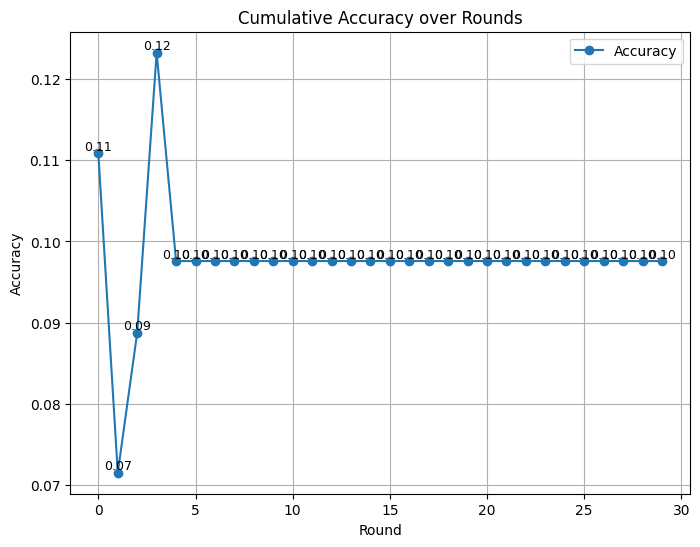

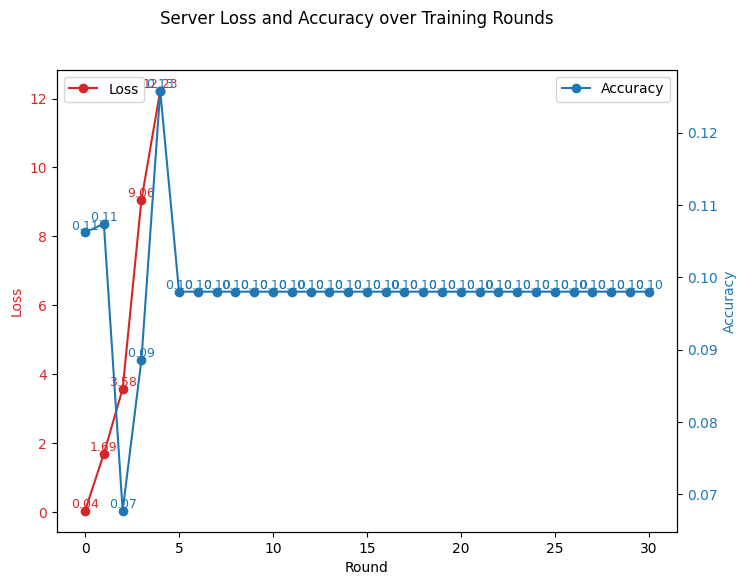

In [ ]:
from flwr.server.strategy import DifferentialPrivacyServerSideFixedClipping

dpFix_strategy = DifferentialPrivacyServerSideFixedClipping(
    strategy,
    noise_multiplier = 1.1 ,
    clipping_norm = 1,
    num_sampled_clients = 5,
)

run_my_sim(
    strategy = dpFix_strategy,
    num_rounds = Num_rounds,
    num_clients = NUM_CLIENTS,
)

### **Adaptive Clipping**

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[codecarbon INFO @ 08:33:19] [setup] RAM Tracking...
[codecarbon INFO @ 08:33:19] [setup] CPU Tracking...
[codecarbon WARNING @ 08:33:19] No CPU tracking mode found. Falling back on CPU constant mode. 
 Linux OS detected: Please ensure RAPL files exist at \sys\class\powercap\intel-rapl to measure CPU



model is reset.. dont beleve me?.. acc= 0.07575 
No GPU found.


[codecarbon WARNING @ 08:33:20] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 08:33:20] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 08:33:20] [setup] GPU Tracking...
[codecarbon INFO @ 08:33:20] No GPU found.
[codecarbon INFO @ 08:33:20] >>> Tracker's metadata:
[codecarbon INFO @ 08:33:20]   Platform system: Linux-6.1.85+-x86_64-with-glibc2.35
[codecarbon INFO @ 08:33:20]   Python version: 3.10.12
[codecarbon INFO @ 08:33:20]   CodeCarbon version: 2.8.2
[codecarbon INFO @ 08:33:20]   Available RAM : 12.675 GB
[codecarbon INFO @ 08:33:20]   CPU count: 2
[codecarbon INFO @ 08:33:20]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 08:33:20]   GPU count: None
[codecarbon INFO @ 08:33:20]   GPU model: None
[codecarbon INFO @ 08:33:20] Saving emissions data to file /content/emissions.csv
INFO :      Starting Flower ServerApp, config: num_rounds=30, no round_timeout

DifferentialPrivacyServerSideAdaptiveClipping


(pid=25746) 2024-12-23 08:33:31.213822: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=25746) 2024-12-23 08:33:31.278004: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=25746) 2024-12-23 08:33:31.295988: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=25747) 2024-12-23 08:33:35.000700: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
[codecarbon INFO @ 08:33:35] Energy consumed for RAM : 0.000020 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:33:35] Energy consumed for all CPUs : 0.000177 kWh. Total CPU Power : 

(ClientAppActor pid=25747) [Client 8] get_parameters


[codecarbon INFO @ 08:33:50] Energy consumed for RAM : 0.000040 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:33:50] Energy consumed for all CPUs : 0.000354 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:33:50] 0.000394 kWh of electricity used since the beginning.
INFO :      initial parameters (loss, other metrics): 0.03612943775653839, {'accuracy': 0.0982}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.03612943775653839 / accuracy 0.0982
(ClientAppActor pid=25747) [Client 1, round 1] fit, config: {'server_round': 1, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=25747) [Client 4, round 1] fit, config: {'server_round': 1, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 08:34:05] Energy consumed for RAM : 0.000059 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:34:05] Energy consumed for all CPUs : 0.000531 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:34:05] 0.000591 kWh of electricity used since the beginning.


(ClientAppActor pid=25746) [Client 3, round 1] fit, config: {'server_round': 1, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=25746) [Client 8, round 1] fit, config: {'server_round': 1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=25746) [Client 6, round 1] fit, config: {'server_round': 1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:34:20] Energy consumed for RAM : 0.000079 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:34:20] Energy consumed for all CPUs : 0.000708 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:34:20] 0.000788 kWh of electricity used since the beginning.


(ClientAppActor pid=25746) [Client 2, round 1] fit, config: {'server_round': 1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: central DP noise with 0.0016 stdev added
[codecarbon INFO @ 08:34:35] Energy consumed for RAM : 0.000099 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:34:35] Energy consumed for all CPUs : 0.000885 kWh. Total CPU Power

Server-side evaluation loss 0.03596854426860809 / accuracy 0.0982
(ClientAppActor pid=25746) [Client 1] evaluate, config: {'current_round': 1}
(ClientAppActor pid=25747) [Client 7, round 1] fit, config: {'server_round': 1, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=25747) [Client 7] evaluate, config: {'current_round': 1} [repeated 4x across cluster]
(ClientAppActor pid=25747) [Client 4] evaluate, config: {'current_round': 1} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.09375 0.03629064619541169 


[codecarbon INFO @ 08:34:50] Energy consumed for RAM : 0.000119 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:34:50] Energy consumed for all CPUs : 0.001062 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:34:50] 0.001181 kWh of electricity used since the beginning.


(ClientAppActor pid=25746) [Client 0, round 2] fit, config: {'server_round': 2, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=25746) [Client 2] evaluate, config: {'current_round': 1}
(ClientAppActor pid=25746) [Client 3, round 2] fit, config: {'server_round': 2, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:35:05] Energy consumed for RAM : 0.000139 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:35:05] Energy consumed for all CPUs : 0.001240 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:35:05] 0.001378 kWh of electricity used since the beginning.


(ClientAppActor pid=25747) [Client 9, round 2] fit, config: {'server_round': 2, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=25746) [Client 5, round 2] fit, config: {'server_round': 2, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=25746) [Client 2, round 2] fit, config: {'server_round': 2, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:35:20] Energy consumed for RAM : 0.000158 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:35:20] Energy consumed for all CPUs : 0.001417 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:35:20] 0.001575 kWh of electricity used since the beginning.
[codecarbon INFO @ 08:35:20] 0.001820 g.CO2eq/s mean an estimation of 57.41097130135431 kg.CO2eq/year
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 0.0788.
INFO :      aggregate_fit: parameters are clipped by value: 0.0788.
INFO :      aggregate_fit: parameters are clipped by value: 0.0788.
INFO :      aggregate_fit: parameters are clipped by value: 0.0788.
INFO :      aggregate_fit: parameters are clipped by value: 0.0788.
INFO :      aggregate_fit: parameters are clipped by value: 0.0788.
INFO :      aggregate_fit: parameters are clipped by value: 0.0788.
INFO :      aggregate_fit: parameters are clipped by value: 0.0788.
INFO :   

Server-side evaluation loss 0.03579472625255585 / accuracy 0.1005
(ClientAppActor pid=25746) [Client 1] evaluate, config: {'current_round': 2}
(ClientAppActor pid=25747) [Client 4, round 2] fit, config: {'server_round': 2, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 08:35:35] Energy consumed for RAM : 0.000178 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:35:35] Energy consumed for all CPUs : 0.001594 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:35:35] 0.001772 kWh of electricity used since the beginning.


(ClientAppActor pid=25746) [Client 8] evaluate, config: {'current_round': 2} [repeated 4x across cluster]
(ClientAppActor pid=25747) [Client 7] evaluate, config: {'current_round': 2} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.09675 0.03612060244878133 
(ClientAppActor pid=25746) [Client 3, round 3] fit, config: {'server_round': 3, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 08:35:50] Energy consumed for RAM : 0.000198 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:35:50] Energy consumed for all CPUs : 0.001771 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:35:50] 0.001969 kWh of electricity used since the beginning.


(ClientAppActor pid=25746) [Client 3] evaluate, config: {'current_round': 2}
(ClientAppActor pid=25746) [Client 6, round 3] fit, config: {'server_round': 3, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=25746) [Client 8, round 3] fit, config: {'server_round': 3, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:36:05] Energy consumed for RAM : 0.000218 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:36:05] Energy consumed for all CPUs : 0.001948 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:36:05] 0.002165 kWh of electricity used since the beginning.


(ClientAppActor pid=25746) [Client 1, round 3] fit, config: {'server_round': 3, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=25746) [Client 2, round 3] fit, config: {'server_round': 3, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 0.0624.
INFO :      aggregate_fit: parameters are clipped by value: 0.0624.
INFO :      aggregate_fit: parameters are clipped by value: 0.0624.
INFO :      aggregate_fit: parameters are clipped by value: 0.0624.
INFO :      aggregate_fit: parameters are clipped by value: 0.0624.
INFO :      aggregate_fit: parameters are clipped by value: 0.0624.
INFO :      aggregate_fit: parameters are clipped by value: 0.0624.
INFO :      aggregate_fit: parameters are clipped by value: 0.0624.
INFO :      aggregate_fit: parameters are clipped by value: 0.0624.
INFO :      aggregate_fit: parameters are clipped by value: 0.0624.
INFO :      aggregate_fit: central DP noise with 0.0010 stdev added
[codecarbon INFO @ 08:36:20] Energy consumed for RAM : 0.000238 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:36:20] Energy consumed for all CPUs : 0.002125 kWh. Total CPU Power

Server-side evaluation loss 0.03563082699775696 / accuracy 0.123
(ClientAppActor pid=25747) [Client 2] evaluate, config: {'current_round': 3}
(ClientAppActor pid=25747) [Client 5, round 3] fit, config: {'server_round': 3, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=25747) [Client 7] evaluate, config: {'current_round': 3} [repeated 4x across cluster]


[codecarbon INFO @ 08:36:35] Energy consumed for RAM : 0.000257 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:36:35] Energy consumed for all CPUs : 0.002302 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:36:35] 0.002559 kWh of electricity used since the beginning.


(ClientAppActor pid=25746) [Client 0] evaluate, config: {'current_round': 3} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.12175 0.03596013977130254 
(ClientAppActor pid=25746) [Client 0, round 4] fit, config: {'server_round': 4, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=25747) [Client 5, round 4] fit, config: {'server_round': 4, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:36:50] Energy consumed for RAM : 0.000277 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:36:50] Energy consumed for all CPUs : 0.002479 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:36:50] 0.002756 kWh of electricity used since the beginning.


(ClientAppActor pid=25747) [Client 8, round 4] fit, config: {'server_round': 4, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=25747) [Client 2, round 4] fit, config: {'server_round': 4, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:37:05] Energy consumed for RAM : 0.000297 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:37:05] Energy consumed for all CPUs : 0.002656 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:37:05] 0.002953 kWh of electricity used since the beginning.


(ClientAppActor pid=25747) [Client 1, round 4] fit, config: {'server_round': 4, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 0.0495.
INFO :      aggregate_fit: parameters are clipped by value: 0.0495.
INFO :      aggregate_fit: parameters are clipped by value: 0.0495.
INFO :      aggregate_fit: parameters are clipped by value: 0.0495.
INFO :      aggregate_fit: parameters are clipped by value: 0.0495.
INFO :      aggregate_fit: parameters are clipped by value: 0.0495.
INFO :      aggregate_fit: parameters are clipped by value: 0.0495.
INFO :      aggregate_fit: parameters are clipped by value: 0.0495.
INFO :      aggregate_fit: parameters are clipped by value: 0.0495.
INFO :      aggregate_fit: parameters are clipped by value: 0.0495.
INFO :      aggregate_fit: central DP noise with 0.0008 stdev added
INFO :      fit progress: (4, 0.035477764892578124, {'accuracy': 0.155}, 205.87661538799966)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.035477764892578124 / accuracy 0.155


[codecarbon INFO @ 08:37:20] Energy consumed for RAM : 0.000317 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:37:20] Energy consumed for all CPUs : 0.002833 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:37:20] 0.003150 kWh of electricity used since the beginning.
[codecarbon INFO @ 08:37:20] 0.001820 g.CO2eq/s mean an estimation of 57.40912769656721 kg.CO2eq/year


(ClientAppActor pid=25747) [Client 3] evaluate, config: {'current_round': 4}
(ClientAppActor pid=25746) [Client 6, round 4] fit, config: {'server_round': 4, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=25746) [Client 9] evaluate, config: {'current_round': 4} [repeated 4x across cluster]
(ClientAppActor pid=25746) [Client 5] evaluate, config: {'current_round': 4} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.15716666666666665 0.03581012161572774 
(ClientAppActor pid=25746) [Client 4, round 5] fit, config: {'server_round': 5, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 08:37:35] Energy consumed for RAM : 0.000337 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:37:35] Energy consumed for all CPUs : 0.003010 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:37:35] 0.003347 kWh of electricity used since the beginning.


(ClientAppActor pid=25747) [Client 4] evaluate, config: {'current_round': 4}
(ClientAppActor pid=25746) [Client 5, round 5] fit, config: {'server_round': 5, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=25746) [Client 8, round 5] fit, config: {'server_round': 5, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:37:50] Energy consumed for RAM : 0.000356 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:37:50] Energy consumed for all CPUs : 0.003187 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:37:50] 0.003543 kWh of electricity used since the beginning.


(ClientAppActor pid=25746) [Client 6, round 5] fit, config: {'server_round': 5, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=25746) [Client 3, round 5] fit, config: {'server_round': 5, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 0.0388.
INFO :      aggregate_fit: parameters are clipped by value: 0.0388.
INFO :      aggregate_fit: parameters are clipped by value: 0.0388.
INFO :      aggregate_fit: parameters are clipped by value: 0.0388.
INFO :      aggregate_fit: parameters are clipped by value: 0.0388.
INFO :      aggregate_fit: parameters are clipped by value: 0.0388.
INFO :      aggregate_fit: parameters are clipped by value: 0.0388.
INFO :      aggregate_fit: parameters are clipped by value: 0.0388.
INFO :      aggregate_fit: parameters are clipped by value: 0.0388.
INFO :      aggregate_fit: parameters are clipped by value: 0.0388.
INFO :      aggregate_fit: central DP noise with 0.0006 stdev added
[codecarbon INFO @ 08:38:05] Energy consumed for RAM : 0.000376 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:38:05] Energy consumed for all CPUs : 0.003364 kWh. Total CPU Power

Server-side evaluation loss 0.03535235068798065 / accuracy 0.1824
(ClientAppActor pid=25747) [Client 6] evaluate, config: {'current_round': 5}
(ClientAppActor pid=25747) [Client 2, round 5] fit, config: {'server_round': 5, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=25747) [Client 7] evaluate, config: {'current_round': 5} [repeated 4x across cluster]


[codecarbon INFO @ 08:38:20] Energy consumed for RAM : 0.000396 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:38:20] Energy consumed for all CPUs : 0.003541 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:38:20] 0.003937 kWh of electricity used since the beginning.


(ClientAppActor pid=25746) [Client 9] evaluate, config: {'current_round': 5} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.1845 0.03568769252300262 
(ClientAppActor pid=25747) [Client 2, round 6] fit, config: {'server_round': 6, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=25747) [Client 3, round 6] fit, config: {'server_round': 6, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:38:35] Energy consumed for RAM : 0.000416 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:38:35] Energy consumed for all CPUs : 0.003718 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:38:35] 0.004134 kWh of electricity used since the beginning.


(ClientAppActor pid=25747) [Client 6, round 6] fit, config: {'server_round': 6, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=25747) [Client 8, round 6] fit, config: {'server_round': 6, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:38:50] Energy consumed for RAM : 0.000435 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:38:50] Energy consumed for all CPUs : 0.003895 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:38:50] 0.004331 kWh of electricity used since the beginning.


(ClientAppActor pid=25747) [Client 5, round 6] fit, config: {'server_round': 6, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 0.0308.
INFO :      aggregate_fit: parameters are clipped by value: 0.0308.
INFO :      aggregate_fit: parameters are clipped by value: 0.0308.
INFO :      aggregate_fit: parameters are clipped by value: 0.0308.
INFO :      aggregate_fit: parameters are clipped by value: 0.0308.
INFO :      aggregate_fit: parameters are clipped by value: 0.0308.
INFO :      aggregate_fit: parameters are clipped by value: 0.0308.
INFO :      aggregate_fit: parameters are clipped by value: 0.0308.
INFO :      aggregate_fit: parameters are clipped by value: 0.0308.
INFO :      aggregate_fit: parameters are clipped by value: 0.0308.
INFO :      aggregate_fit: central DP noise with 0.0005 stdev added
[codecarbon INFO @ 08:39:05] Energy consumed for RAM : 0.000455 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:39:05] Energy consumed for all CPUs : 0.004072 kWh. Total CPU Power

Server-side evaluation loss 0.03524093098640442 / accuracy 0.2033
(ClientAppActor pid=25747) [Client 3] evaluate, config: {'current_round': 6}
(ClientAppActor pid=25746) [Client 7, round 6] fit, config: {'server_round': 6, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=25747) [Client 7] evaluate, config: {'current_round': 6} [repeated 4x across cluster]


[codecarbon INFO @ 08:39:20] Energy consumed for RAM : 0.000475 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:39:20] Energy consumed for all CPUs : 0.004249 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:39:20] 0.004724 kWh of electricity used since the beginning.
[codecarbon INFO @ 08:39:20] 0.001820 g.CO2eq/s mean an estimation of 57.410250914906804 kg.CO2eq/year


(ClientAppActor pid=25746) [Client 5] evaluate, config: {'current_round': 6} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.20591666666666664 0.03557853804032008 
(ClientAppActor pid=25746) [Client 1, round 7] fit, config: {'server_round': 7, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=25746) [Client 6, round 7] fit, config: {'server_round': 7, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:39:35] Energy consumed for RAM : 0.000495 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:39:35] Energy consumed for all CPUs : 0.004426 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:39:35] 0.004921 kWh of electricity used since the beginning.


(ClientAppActor pid=25746) [Client 8, round 7] fit, config: {'server_round': 7, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=25747) [Client 5, round 7] fit, config: {'server_round': 7, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=25746) [Client 7, round 7] fit, config: {'server_round': 7, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:39:50] Energy consumed for RAM : 0.000515 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:39:50] Energy consumed for all CPUs : 0.004603 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:39:50] 0.005118 kWh of electricity used since the beginning.
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 0.0233.
INFO :      aggregate_fit: parameters are clipped by value: 0.0233.
INFO :      aggregate_fit: parameters are clipped by value: 0.0233.
INFO :      aggregate_fit: parameters are clipped by value: 0.0233.
INFO :      aggregate_fit: parameters are clipped by value: 0.0233.
INFO :      aggregate_fit: parameters are clipped by value: 0.0233.
INFO :      aggregate_fit: parameters are clipped by value: 0.0233.
INFO :      aggregate_fit: parameters are clipped by value: 0.0233.
INFO :      aggregate_fit: parameters are clipped by value: 0.0233.
INFO :      aggregate_fit: parameters are c

Server-side evaluation loss 0.03514917256832123 / accuracy 0.2261
(ClientAppActor pid=25747) [Client 0] evaluate, config: {'current_round': 7}
(ClientAppActor pid=25747) [Client 0, round 7] fit, config: {'server_round': 7, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 08:40:05] Energy consumed for RAM : 0.000534 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:40:05] Energy consumed for all CPUs : 0.004780 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:40:05] 0.005315 kWh of electricity used since the beginning.


(ClientAppActor pid=25746) [Client 9] evaluate, config: {'current_round': 7} [repeated 5x across cluster]
(ClientAppActor pid=25747) [Client 1] evaluate, config: {'current_round': 7} [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.22649999999999998 0.03548829060792923 
(ClientAppActor pid=25747) [Client 0, round 8] fit, config: {'server_round': 8, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 08:40:20] Energy consumed for RAM : 0.000554 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:40:20] Energy consumed for all CPUs : 0.004957 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:40:20] 0.005512 kWh of electricity used since the beginning.


(ClientAppActor pid=25746) [Client 7] evaluate, config: {'current_round': 7}
(ClientAppActor pid=25746) [Client 5, round 8] fit, config: {'server_round': 8, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=25746) [Client 6, round 8] fit, config: {'server_round': 8, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:40:35] Energy consumed for RAM : 0.000574 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:40:35] Energy consumed for all CPUs : 0.005134 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:40:35] 0.005708 kWh of electricity used since the beginning.


(ClientAppActor pid=25747) [Client 4, round 8] fit, config: {'server_round': 8, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=25747) [Client 2, round 8] fit, config: {'server_round': 8, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 0.0183.
INFO :      aggregate_fit: parameters are clipped by value: 0.0183.
INFO :      aggregate_fit: parameters are clipped by value: 0.0183.
INFO :      aggregate_fit: parameters are clipped by value: 0.0183.
INFO :      aggregate_fit: parameters are clipped by value: 0.0183.
INFO :      aggregate_fit: parameters are clipped by value: 0.0183.
INFO :      aggregate_fit: parameters are clipped by value: 0.0183.
INFO :      aggregate_fit: parameters are clipped by value: 0.0183.
INFO :      aggregate_fit: parameters are clipped by value: 0.0183.
INFO :      aggregate_fit: parameters are clipped by value: 0.0183.
INFO :      aggregate_fit: central DP noise with 0.0003 stdev added
[codecarbon INFO @ 08:40:50] Energy consumed for RAM : 0.000594 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:40:50] Energy consumed for all CPUs : 0.005311 kWh. Total CPU Power

Server-side evaluation loss 0.03507650511264801 / accuracy 0.245
(ClientAppActor pid=25746) [Client 0] evaluate, config: {'current_round': 8}
(ClientAppActor pid=25746) [Client 9, round 8] fit, config: {'server_round': 8, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=25747) [Client 9] evaluate, config: {'current_round': 8} [repeated 4x across cluster]


[codecarbon INFO @ 08:41:05] Energy consumed for RAM : 0.000614 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:41:05] Energy consumed for all CPUs : 0.005488 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:41:05] 0.006102 kWh of electricity used since the beginning.


(ClientAppActor pid=25747) [Client 5] evaluate, config: {'current_round': 8} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.24008333333333334 0.03541703728834788 
(ClientAppActor pid=25747) [Client 3, round 9] fit, config: {'server_round': 9, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=25746) [Client 7] evaluate, config: {'current_round': 8}
(ClientAppActor pid=25747) [Client 5, round 9] fit, config: {'server_round': 9, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:41:20] Energy consumed for RAM : 0.000633 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:41:20] Energy consumed for all CPUs : 0.005666 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:41:20] 0.006299 kWh of electricity used since the beginning.
[codecarbon INFO @ 08:41:20] 0.001821 g.CO2eq/s mean an estimation of 57.41381363610152 kg.CO2eq/year


(ClientAppActor pid=25747) [Client 8, round 9] fit, config: {'server_round': 9, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=25747) [Client 0, round 9] fit, config: {'server_round': 9, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:41:35] Energy consumed for RAM : 0.000653 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:41:35] Energy consumed for all CPUs : 0.005843 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:41:35] 0.006496 kWh of electricity used since the beginning.


(ClientAppActor pid=25747) [Client 1, round 9] fit, config: {'server_round': 9, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 0.0139.
INFO :      aggregate_fit: parameters are clipped by value: 0.0139.
INFO :      aggregate_fit: parameters are clipped by value: 0.0139.
INFO :      aggregate_fit: parameters are clipped by value: 0.0139.
INFO :      aggregate_fit: parameters are clipped by value: 0.0139.
INFO :      aggregate_fit: parameters are clipped by value: 0.0139.
INFO :      aggregate_fit: parameters are clipped by value: 0.0139.
INFO :      aggregate_fit: parameters are clipped by value: 0.0139.
INFO :      aggregate_fit: parameters are clipped by value: 0.0139.
INFO :      aggregate_fit: parameters are clipped by value: 0.0139.
INFO :      aggregate_fit: central DP noise with 0.0002 stdev added
INFO :      fit progress: (9, 0.03501847810745239, {'accuracy': 0.2593}, 476.3846800680003)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.03501847810745239 / accuracy 0.2593


[codecarbon INFO @ 08:41:50] Energy consumed for RAM : 0.000673 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:41:50] Energy consumed for all CPUs : 0.006020 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:41:50] 0.006693 kWh of electricity used since the beginning.


(ClientAppActor pid=25746) [Client 2] evaluate, config: {'current_round': 9}
(ClientAppActor pid=25746) [Client 4, round 9] fit, config: {'server_round': 9, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=25747) [Client 7] evaluate, config: {'current_round': 9} [repeated 4x across cluster]
(ClientAppActor pid=25747) [Client 9] evaluate, config: {'current_round': 9} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.25575 0.03535993401209513 


[codecarbon INFO @ 08:42:05] Energy consumed for RAM : 0.000693 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:42:05] Energy consumed for all CPUs : 0.006197 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:42:05] 0.006889 kWh of electricity used since the beginning.


(ClientAppActor pid=25747) [Client 0, round 10] fit, config: {'server_round': 10, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=25746) [Client 5, round 10] fit, config: {'server_round': 10, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=25746) [Client 7, round 10] fit, config: {'server_round': 10, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:42:20] Energy consumed for RAM : 0.000713 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:42:20] Energy consumed for all CPUs : 0.006374 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:42:20] 0.007086 kWh of electricity used since the beginning.


(ClientAppActor pid=25746) [Client 4, round 10] fit, config: {'server_round': 10, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=25746) [Client 6, round 10] fit, config: {'server_round': 10, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:42:35] Energy consumed for RAM : 0.000732 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:42:35] Energy consumed for all CPUs : 0.006551 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:42:35] 0.007283 kWh of electricity used since the beginning.
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 0.0109.
INFO :      aggregate_fit: parameters are clipped by value: 0.0109.
INFO :      aggregate_fit: parameters are clipped by value: 0.0109.
INFO :      aggregate_fit: parameters are clipped by value: 0.0109.
INFO :      aggregate_fit: parameters are clipped by value: 0.0109.
INFO :      aggregate_fit: parameters are clipped by value: 0.0109.
INFO :      aggregate_fit: parameters are clipped by value: 0.0109.
INFO :      aggregate_fit: parameters are clipped by value: 0.0109.
INFO :      aggregate_fit: parameters are clipped by value: 0.0109.
INFO :      aggregate_fit: parameters are c

Server-side evaluation loss 0.0349687739610672 / accuracy 0.2716
(ClientAppActor pid=25747) [Client 1] evaluate, config: {'current_round': 10}
(ClientAppActor pid=25747) [Client 1, round 10] fit, config: {'server_round': 10, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 08:42:50] Energy consumed for RAM : 0.000752 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:42:50] Energy consumed for all CPUs : 0.006728 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:42:50] 0.007480 kWh of electricity used since the beginning.


(ClientAppActor pid=25746) [Client 9] evaluate, config: {'current_round': 10} [repeated 5x across cluster]
(ClientAppActor pid=25746) [Client 3] evaluate, config: {'current_round': 10} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.26733333333333326 0.03531115678946176 
(ClientAppActor pid=25747) [Client 1, round 11] fit, config: {'server_round': 11, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 08:43:05] Energy consumed for RAM : 0.000772 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:43:05] Energy consumed for all CPUs : 0.006905 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:43:05] 0.007677 kWh of electricity used since the beginning.


(ClientAppActor pid=25747) [Client 2, round 11] fit, config: {'server_round': 11, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=25747) [Client 6, round 11] fit, config: {'server_round': 11, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=25747) [Client 3, round 11] fit, config: {'server_round': 11, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:43:20] Energy consumed for RAM : 0.000792 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:43:20] Energy consumed for all CPUs : 0.007082 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:43:20] 0.007874 kWh of electricity used since the beginning.
[codecarbon INFO @ 08:43:20] 0.001820 g.CO2eq/s mean an estimation of 57.40952090447522 kg.CO2eq/year


(ClientAppActor pid=25747) [Client 9, round 11] fit, config: {'server_round': 11, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 0.0085.
INFO :      aggregate_fit: parameters are clipped by value: 0.0085.
INFO :      aggregate_fit: parameters are clipped by value: 0.0085.
INFO :      aggregate_fit: parameters are clipped by value: 0.0085.
INFO :      aggregate_fit: parameters are clipped by value: 0.0085.
INFO :      aggregate_fit: parameters are clipped by value: 0.0085.
INFO :      aggregate_fit: parameters are clipped by value: 0.0085.
INFO :      aggregate_fit: parameters are clipped by value: 0.0085.
INFO :      aggregate_fit: parameters are clipped by value: 0.0085.
INFO :      aggregate_fit: parameters are clipped by value: 0.0085.
INFO :      aggregate_fit: central DP noise with 0.0001 stdev added
[codecarbon INFO @ 08:43:35] Energy consumed for RAM : 0.000812 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:43:35] Energy consumed for all CPUs : 0.007259 kWh. Total CPU Power

Server-side evaluation loss 0.03493216738700867 / accuracy 0.2799
(ClientAppActor pid=25747) [Client 1] evaluate, config: {'current_round': 11}
(ClientAppActor pid=25746) [Client 7, round 11] fit, config: {'server_round': 11, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=25746) [Client 8] evaluate, config: {'current_round': 11} [repeated 5x across cluster]


[codecarbon INFO @ 08:43:50] Energy consumed for RAM : 0.000831 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:43:50] Energy consumed for all CPUs : 0.007436 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:43:50] 0.008268 kWh of electricity used since the beginning.
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.27466666666666667 0.03527533541123072 
(ClientAppActor pid=25747) [Client 4, round 12] fit, config: {'server_round': 12, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=25746) [Client 2] evaluate, config: {'current_round': 11} [repeated 4x across cluster]
(ClientAppActor pid=25747) [Client 5, round 12] fit, config: {'server_round': 12, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:44:05] Energy consumed for RAM : 0.000851 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:44:05] Energy consumed for all CPUs : 0.007613 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:44:05] 0.008465 kWh of electricity used since the beginning.


(ClientAppActor pid=25746) [Client 6, round 12] fit, config: {'server_round': 12, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=25746) [Client 9, round 12] fit, config: {'server_round': 12, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=25746) [Client 7, round 12] fit, config: {'server_round': 12, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:44:20] Energy consumed for RAM : 0.000871 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:44:20] Energy consumed for all CPUs : 0.007791 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:44:20] 0.008662 kWh of electricity used since the beginning.
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 0.0066.
INFO :      aggregate_fit: parameters are clipped by value: 0.0066.
INFO :      aggregate_fit: parameters are clipped by value: 0.0066.
INFO :      aggregate_fit: parameters are clipped by value: 0.0066.
INFO :      aggregate_fit: parameters are clipped by value: 0.0066.
INFO :      aggregate_fit: parameters are clipped by value: 0.0066.
INFO :      aggregate_fit: parameters are clipped by value: 0.0066.
INFO :      aggregate_fit: parameters are clipped by value: 0.0066.
INFO :      aggregate_fit: parameters are clipped by value: 0.0066.
INFO :      aggregate_fit: parameters are c

Server-side evaluation loss 0.03490378677845001 / accuracy 0.2858
(ClientAppActor pid=25747) [Client 0] evaluate, config: {'current_round': 12}
(ClientAppActor pid=25747) [Client 3, round 12] fit, config: {'server_round': 12, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 08:44:35] Energy consumed for RAM : 0.000891 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:44:35] Energy consumed for all CPUs : 0.007967 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:44:35] 0.008858 kWh of electricity used since the beginning.


(ClientAppActor pid=25747) [Client 5] evaluate, config: {'current_round': 12} [repeated 4x across cluster]
(ClientAppActor pid=25746) [Client 4] evaluate, config: {'current_round': 12} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.2805 0.03524744923909505 
(ClientAppActor pid=25746) [Client 0, round 13] fit, config: {'server_round': 13, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 08:44:50] Energy consumed for RAM : 0.000911 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:44:50] Energy consumed for all CPUs : 0.008145 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:44:50] 0.009055 kWh of electricity used since the beginning.


(ClientAppActor pid=25746) [Client 3, round 13] fit, config: {'server_round': 13, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=25747) [Client 7, round 13] fit, config: {'server_round': 13, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:45:05] Energy consumed for RAM : 0.000930 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:45:05] Energy consumed for all CPUs : 0.008322 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:45:05] 0.009252 kWh of electricity used since the beginning.


(ClientAppActor pid=25747) [Client 4, round 13] fit, config: {'server_round': 13, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=25747) [Client 1, round 13] fit, config: {'server_round': 13, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 0.0052.
INFO :      aggregate_fit: parameters are clipped by value: 0.0052.
INFO :      aggregate_fit: parameters are clipped by value: 0.0052.
INFO :      aggregate_fit: parameters are clipped by value: 0.0052.
INFO :      aggregate_fit: parameters are clipped by value: 0.0052.
INFO :      aggregate_fit: parameters are clipped by value: 0.0052.
INFO :      aggregate_fit: parameters are clipped by value: 0.0052.
INFO :      aggregate_fit: parameters are clipped by value: 0.0052.
INFO :      aggregate_fit: parameters are clipped by value: 0.0052.
INFO :      aggregate_fit: parameters are clipped by value: 0.0052.
INFO :      aggregate_fit: central DP noise with 0.0001 stdev added
[codecarbon INFO @ 08:45:20] Energy consumed for RAM : 0.000950 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:45:20] Energy consumed for all CPUs : 0.008499 kWh. Total CPU Power

Server-side evaluation loss 0.03487962772846222 / accuracy 0.2909
(ClientAppActor pid=25747) [Client 2] evaluate, config: {'current_round': 13}
(ClientAppActor pid=25746) [Client 8, round 13] fit, config: {'server_round': 13, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=25746) [Client 5] evaluate, config: {'current_round': 13} [repeated 4x across cluster]


[codecarbon INFO @ 08:45:35] Energy consumed for RAM : 0.000970 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:45:35] Energy consumed for all CPUs : 0.008676 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:45:35] 0.009646 kWh of electricity used since the beginning.


(ClientAppActor pid=25746) [Client 0] evaluate, config: {'current_round': 13} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.28608333333333336 0.0352236648996671 
(ClientAppActor pid=25747) [Client 0, round 14] fit, config: {'server_round': 14, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=25747) [Client 7] evaluate, config: {'current_round': 13}
(ClientAppActor pid=25747) [Client 2, round 14] fit, config: {'server_round': 14, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:45:50] Energy consumed for RAM : 0.000990 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:45:50] Energy consumed for all CPUs : 0.008853 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:45:50] 0.009843 kWh of electricity used since the beginning.


(ClientAppActor pid=25747) [Client 7, round 14] fit, config: {'server_round': 14, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=25747) [Client 5, round 14] fit, config: {'server_round': 14, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:46:05] Energy consumed for RAM : 0.001010 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:46:05] Energy consumed for all CPUs : 0.009030 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:46:05] 0.010040 kWh of electricity used since the beginning.


(ClientAppActor pid=25747) [Client 9, round 14] fit, config: {'server_round': 14, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 0.0040.
INFO :      aggregate_fit: parameters are clipped by value: 0.0040.
INFO :      aggregate_fit: parameters are clipped by value: 0.0040.
INFO :      aggregate_fit: parameters are clipped by value: 0.0040.
INFO :      aggregate_fit: parameters are clipped by value: 0.0040.
INFO :      aggregate_fit: parameters are clipped by value: 0.0040.
INFO :      aggregate_fit: parameters are clipped by value: 0.0040.
INFO :      aggregate_fit: parameters are clipped by value: 0.0040.
INFO :      aggregate_fit: parameters are clipped by value: 0.0040.
INFO :      aggregate_fit: parameters are clipped by value: 0.0040.
INFO :      aggregate_fit: central DP noise with 0.0001 stdev added
[codecarbon INFO @ 08:46:20] Energy consumed for RAM : 0.001029 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:46:20] Energy consumed for all CPUs : 0.009207 kWh. Total CPU Power

Server-side evaluation loss 0.034861119174957274 / accuracy 0.2958
(ClientAppActor pid=25747) [Client 3] evaluate, config: {'current_round': 14}
(ClientAppActor pid=25746) [Client 4, round 14] fit, config: {'server_round': 14, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=25747) [Client 7] evaluate, config: {'current_round': 14} [repeated 4x across cluster]
(ClientAppActor pid=25746) [Client 8] evaluate, config: {'current_round': 14} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.2903333333333334 0.03520545105139415 


[codecarbon INFO @ 08:46:35] Energy consumed for RAM : 0.001049 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:46:35] Energy consumed for all CPUs : 0.009385 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:46:35] 0.010434 kWh of electricity used since the beginning.


(ClientAppActor pid=25747) [Client 2, round 15] fit, config: {'server_round': 15, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=25746) [Client 6, round 15] fit, config: {'server_round': 15, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=25746) [Client 7, round 15] fit, config: {'server_round': 15, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:46:50] Energy consumed for RAM : 0.001069 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:46:50] Energy consumed for all CPUs : 0.009562 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:46:50] 0.010631 kWh of electricity used since the beginning.


(ClientAppActor pid=25746) [Client 3, round 15] fit, config: {'server_round': 15, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=25746) [Client 4, round 15] fit, config: {'server_round': 15, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:47:05] Energy consumed for RAM : 0.001089 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:47:05] Energy consumed for all CPUs : 0.009739 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:47:05] 0.010827 kWh of electricity used since the beginning.
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 0.0031.
INFO :      aggregate_fit: parameters are clipped by value: 0.0031.
INFO :      aggregate_fit: parameters are clipped by value: 0.0031.
INFO :      aggregate_fit: parameters are clipped by value: 0.0031.
INFO :      aggregate_fit: parameters are clipped by value: 0.0031.
INFO :      aggregate_fit: parameters are clipped by value: 0.0031.
INFO :      aggregate_fit: parameters are clipped by value: 0.0031.
INFO :      aggregate_fit: parameters are clipped by value: 0.0031.
INFO :      aggregate_fit: parameters are clipped by value: 0.0031.
INFO :      aggregate_fit: parameters are c

Server-side evaluation loss 0.034848113083839415 / accuracy 0.2987
(ClientAppActor pid=25747) [Client 3] evaluate, config: {'current_round': 15}
(ClientAppActor pid=25747) [Client 8, round 15] fit, config: {'server_round': 15, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 08:47:20] Energy consumed for RAM : 0.001109 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:47:20] Energy consumed for all CPUs : 0.009916 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:47:20] 0.011024 kWh of electricity used since the beginning.
[codecarbon INFO @ 08:47:20] 0.001820 g.CO2eq/s mean an estimation of 57.41126508370405 kg.CO2eq/year


(ClientAppActor pid=25746) [Client 7] evaluate, config: {'current_round': 15} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.29258333333333336 0.035192692339420316 
(ClientAppActor pid=25746) [Client 0, round 16] fit, config: {'server_round': 16, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=25746) [Client 8] evaluate, config: {'current_round': 15} [repeated 4x across cluster]


[codecarbon INFO @ 08:47:35] Energy consumed for RAM : 0.001128 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:47:35] Energy consumed for all CPUs : 0.010093 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:47:35] 0.011221 kWh of electricity used since the beginning.


(ClientAppActor pid=25747) [Client 7, round 16] fit, config: {'server_round': 16, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=25746) [Client 8, round 16] fit, config: {'server_round': 16, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=25746) [Client 6, round 16] fit, config: {'server_round': 16, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:47:50] Energy consumed for RAM : 0.001148 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:47:50] Energy consumed for all CPUs : 0.010270 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:47:50] 0.011418 kWh of electricity used since the beginning.


(ClientAppActor pid=25747) [Client 1, round 16] fit, config: {'server_round': 16, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 0.0023.
INFO :      aggregate_fit: parameters are clipped by value: 0.0023.
INFO :      aggregate_fit: parameters are clipped by value: 0.0023.
INFO :      aggregate_fit: parameters are clipped by value: 0.0023.
INFO :      aggregate_fit: parameters are clipped by value: 0.0023.
INFO :      aggregate_fit: parameters are clipped by value: 0.0023.
INFO :      aggregate_fit: parameters are clipped by value: 0.0023.
INFO :      aggregate_fit: parameters are clipped by value: 0.0023.
INFO :      aggregate_fit: parameters are clipped by value: 0.0023.
INFO :      aggregate_fit: parameters are clipped by value: 0.0023.
INFO :      aggregate_fit: central DP noise with 0.0000 stdev added
[codecarbon INFO @ 08:48:05] Energy consumed for RAM : 0.001168 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:48:05] Energy consumed for all CPUs : 0.010447 kWh. Total CPU Power

Server-side evaluation loss 0.034837299370765684 / accuracy 0.3014
(ClientAppActor pid=25747) [Client 3] evaluate, config: {'current_round': 16}
(ClientAppActor pid=25746) [Client 5, round 16] fit, config: {'server_round': 16, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=25747) [Client 8] evaluate, config: {'current_round': 16} [repeated 4x across cluster]


[codecarbon INFO @ 08:48:20] Energy consumed for RAM : 0.001188 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:48:20] Energy consumed for all CPUs : 0.010624 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:48:20] 0.011812 kWh of electricity used since the beginning.


(ClientAppActor pid=25747) [Client 1] evaluate, config: {'current_round': 16} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.2954166666666666 0.03518210293849309 
(ClientAppActor pid=25747) [Client 2, round 17] fit, config: {'server_round': 17, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=25746) [Client 5] evaluate, config: {'current_round': 16}
(ClientAppActor pid=25747) [Client 3, round 17] fit, config: {'server_round': 17, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:48:35] Energy consumed for RAM : 0.001208 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:48:35] Energy consumed for all CPUs : 0.010801 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:48:35] 0.012008 kWh of electricity used since the beginning.


(ClientAppActor pid=25747) [Client 7, round 17] fit, config: {'server_round': 17, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=25747) [Client 5, round 17] fit, config: {'server_round': 17, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=25747) [Client 9, round 17] fit, config: {'server_round': 17, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:48:50] Energy consumed for RAM : 0.001227 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:48:50] Energy consumed for all CPUs : 0.010978 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:48:50] 0.012205 kWh of electricity used since the beginning.
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 0.0018.
INFO :      aggregate_fit: parameters are clipped by value: 0.0018.
INFO :      aggregate_fit: parameters are clipped by value: 0.0018.
INFO :      aggregate_fit: parameters are clipped by value: 0.0018.
INFO :      aggregate_fit: parameters are clipped by value: 0.0018.
INFO :      aggregate_fit: parameters are clipped by value: 0.0018.
INFO :      aggregate_fit: parameters are clipped by value: 0.0018.
INFO :      aggregate_fit: parameters are clipped by value: 0.0018.
INFO :      aggregate_fit: parameters are clipped by value: 0.0018.
INFO :      aggregate_fit: parameters are c

Server-side evaluation loss 0.03482897608280182 / accuracy 0.3034
(ClientAppActor pid=25747) [Client 3] evaluate, config: {'current_round': 17}
(ClientAppActor pid=25746) [Client 4, round 17] fit, config: {'server_round': 17, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 08:49:05] Energy consumed for RAM : 0.001247 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:49:05] Energy consumed for all CPUs : 0.011155 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:49:05] 0.012402 kWh of electricity used since the beginning.


(ClientAppActor pid=25747) [Client 8] evaluate, config: {'current_round': 17} [repeated 4x across cluster]
(ClientAppActor pid=25747) [Client 0] evaluate, config: {'current_round': 17} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.29683333333333334 0.03517393495639165 
(ClientAppActor pid=25746) [Client 1, round 18] fit, config: {'server_round': 18, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 08:49:20] Energy consumed for RAM : 0.001267 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:49:20] Energy consumed for all CPUs : 0.011332 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:49:20] 0.012599 kWh of electricity used since the beginning.
[codecarbon INFO @ 08:49:20] 0.001820 g.CO2eq/s mean an estimation of 57.40914274425849 kg.CO2eq/year


(ClientAppActor pid=25746) [Client 7] evaluate, config: {'current_round': 17}
(ClientAppActor pid=25746) [Client 5, round 18] fit, config: {'server_round': 18, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=25747) [Client 9, round 18] fit, config: {'server_round': 18, 'local_epochs': 1, 'learning rate': 0.01} [repeated 3x across cluster]


[codecarbon INFO @ 08:49:35] Energy consumed for RAM : 0.001287 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:49:35] Energy consumed for all CPUs : 0.011509 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:49:35] 0.012796 kWh of electricity used since the beginning.


(ClientAppActor pid=25747) [Client 4, round 18] fit, config: {'server_round': 18, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=25746) [Client 6, round 18] fit, config: {'server_round': 18, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=25747) [Client 3, round 18] fit, config: {'server_round': 18, 'local_epochs': 1, 'learning rate': 0.01}


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 0.0014.
INFO :      aggregate_fit: parameters are clipped by value: 0.0014.
INFO :      aggregate_fit: parameters are clipped by value: 0.0014.
INFO :      aggregate_fit: parameters are clipped by value: 0.0014.
INFO :      aggregate_fit: parameters are clipped by value: 0.0014.
INFO :      aggregate_fit: parameters are clipped by value: 0.0014.
INFO :      aggregate_fit: parameters are clipped by value: 0.0014.
INFO :      aggregate_fit: parameters are clipped by value: 0.0014.
INFO :      aggregate_fit: parameters are clipped by value: 0.0014.
INFO :      aggregate_fit: parameters are clipped by value: 0.0014.
INFO :      aggregate_fit: central DP noise with 0.0000 stdev added
[codecarbon INFO @ 08:49:50] Energy consumed for RAM : 0.001307 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:49:50] Energy consumed for all CPUs : 0.011686 kWh. Total CPU Power

Server-side evaluation loss 0.03482280957698822 / accuracy 0.3052
(ClientAppActor pid=25747) [Client 0] evaluate, config: {'current_round': 18}
(ClientAppActor pid=25746) [Client 8] evaluate, config: {'current_round': 18} [repeated 4x across cluster]


[codecarbon INFO @ 08:50:05] Energy consumed for RAM : 0.001326 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:50:05] Energy consumed for all CPUs : 0.011863 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:50:05] 0.013190 kWh of electricity used since the beginning.


(ClientAppActor pid=25747) [Client 5] evaluate, config: {'current_round': 18} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.29808333333333326 0.035167908012866976 
(ClientAppActor pid=25747) [Client 2, round 19] fit, config: {'server_round': 19, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=25746) [Client 4] evaluate, config: {'current_round': 18}
(ClientAppActor pid=25746) [Client 4, round 19] fit, config: {'server_round': 19, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:50:20] Energy consumed for RAM : 0.001346 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:50:20] Energy consumed for all CPUs : 0.012041 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:50:20] 0.013387 kWh of electricity used since the beginning.


(ClientAppActor pid=25746) [Client 7, round 19] fit, config: {'server_round': 19, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=25746) [Client 1, round 19] fit, config: {'server_round': 19, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=25746) [Client 5, round 19] fit, config: {'server_round': 19, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:50:35] Energy consumed for RAM : 0.001366 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:50:35] Energy consumed for all CPUs : 0.012218 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:50:35] 0.013584 kWh of electricity used since the beginning.
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 0.0011.
INFO :      aggregate_fit: parameters are clipped by value: 0.0011.
INFO :      aggregate_fit: parameters are clipped by value: 0.0011.
INFO :      aggregate_fit: parameters are clipped by value: 0.0011.
INFO :      aggregate_fit: parameters are clipped by value: 0.0011.
INFO :      aggregate_fit: parameters are clipped by value: 0.0011.
INFO :      aggregate_fit: parameters are clipped by value: 0.0011.
INFO :      aggregate_fit: parameters are clipped by value: 0.0011.
INFO :      aggregate_fit: parameters are clipped by value: 0.0011.
INFO :      aggregate_fit: parameters are c

Server-side evaluation loss 0.03481802699565888 / accuracy 0.3064
(ClientAppActor pid=25746) [Client 3] evaluate, config: {'current_round': 19}
(ClientAppActor pid=25747) [Client 9, round 19] fit, config: {'server_round': 19, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 08:50:50] Energy consumed for RAM : 0.001386 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:50:50] Energy consumed for all CPUs : 0.012395 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:50:50] 0.013780 kWh of electricity used since the beginning.


(ClientAppActor pid=25746) [Client 7] evaluate, config: {'current_round': 19} [repeated 4x across cluster]
(ClientAppActor pid=25746) [Client 2] evaluate, config: {'current_round': 19} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.299 0.0351632086833318 
(ClientAppActor pid=25746) [Client 1, round 20] fit, config: {'server_round': 20, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 08:51:05] Energy consumed for RAM : 0.001406 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:51:05] Energy consumed for all CPUs : 0.012572 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:51:05] 0.013977 kWh of electricity used since the beginning.


(ClientAppActor pid=25747) [Client 0] evaluate, config: {'current_round': 19}
(ClientAppActor pid=25746) [Client 2, round 20] fit, config: {'server_round': 20, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=25746) [Client 5, round 20] fit, config: {'server_round': 20, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:51:20] Energy consumed for RAM : 0.001425 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:51:20] Energy consumed for all CPUs : 0.012749 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:51:20] 0.014174 kWh of electricity used since the beginning.
[codecarbon INFO @ 08:51:20] 0.001821 g.CO2eq/s mean an estimation of 57.41290955771077 kg.CO2eq/year


(ClientAppActor pid=25746) [Client 4, round 20] fit, config: {'server_round': 20, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=25746) [Client 6, round 20] fit, config: {'server_round': 20, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 0.0008.
INFO :      aggregate_fit: parameters are clipped by value: 0.0008.
INFO :      aggregate_fit: parameters are clipped by value: 0.0008.
INFO :      aggregate_fit: parameters are clipped by value: 0.0008.
INFO :      aggregate_fit: parameters are clipped by value: 0.0008.
INFO :      aggregate_fit: parameters are clipped by value: 0.0008.
INFO :      aggregate_fit: parameters are clipped by value: 0.0008.
INFO :      aggregate_fit: parameters are clipped by value: 0.0008.
INFO :      aggregate_fit: parameters are clipped by value: 0.0008.
INFO :      aggregate_fit: parameters are clipped by value: 0.0008.
INFO :      aggregate_fit: central DP noise with 0.0000 stdev added
[codecarbon INFO @ 08:51:35] Energy consumed for RAM : 0.001445 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:51:35] Energy consumed for all CPUs : 0.012926 kWh. Total CPU Power

Server-side evaluation loss 0.034814371538162234 / accuracy 0.3072
(ClientAppActor pid=25746) [Client 2] evaluate, config: {'current_round': 20}
(ClientAppActor pid=25747) [Client 8, round 20] fit, config: {'server_round': 20, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=25746) [Client 9] evaluate, config: {'current_round': 20} [repeated 4x across cluster]


[codecarbon INFO @ 08:51:50] Energy consumed for RAM : 0.001465 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:51:50] Energy consumed for all CPUs : 0.013103 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:51:50] 0.014568 kWh of electricity used since the beginning.


(ClientAppActor pid=25746) [Client 8] evaluate, config: {'current_round': 20} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.2999166666666666 0.03515963331858316 
(ClientAppActor pid=25747) [Client 0, round 21] fit, config: {'server_round': 21, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=25747) [Client 7] evaluate, config: {'current_round': 20}
(ClientAppActor pid=25746) [Client 4, round 21] fit, config: {'server_round': 21, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:52:05] Energy consumed for RAM : 0.001485 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:52:05] Energy consumed for all CPUs : 0.013280 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:52:05] 0.014765 kWh of electricity used since the beginning.


(ClientAppActor pid=25746) [Client 7, round 21] fit, config: {'server_round': 21, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=25747) [Client 8, round 21] fit, config: {'server_round': 21, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:52:20] Energy consumed for RAM : 0.001505 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:52:21] Energy consumed for all CPUs : 0.013457 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:52:21] 0.014962 kWh of electricity used since the beginning.


(ClientAppActor pid=25747) [Client 1, round 21] fit, config: {'server_round': 21, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 0.0007.
INFO :      aggregate_fit: parameters are clipped by value: 0.0007.
INFO :      aggregate_fit: parameters are clipped by value: 0.0007.
INFO :      aggregate_fit: parameters are clipped by value: 0.0007.
INFO :      aggregate_fit: parameters are clipped by value: 0.0007.
INFO :      aggregate_fit: parameters are clipped by value: 0.0007.
INFO :      aggregate_fit: parameters are clipped by value: 0.0007.
INFO :      aggregate_fit: parameters are clipped by value: 0.0007.
INFO :      aggregate_fit: parameters are clipped by value: 0.0007.
INFO :      aggregate_fit: parameters are clipped by value: 0.0007.
INFO :      aggregate_fit: central DP noise with 0.0000 stdev added
[codecarbon INFO @ 08:52:36] Energy consumed for RAM : 0.001524 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:52:36] Energy consumed for all CPUs : 0.013635 kWh. Total CPU Power

Server-side evaluation loss 0.034811283588409424 / accuracy 0.3075
(ClientAppActor pid=25746) [Client 0] evaluate, config: {'current_round': 21}
(ClientAppActor pid=25746) [Client 6, round 21] fit, config: {'server_round': 21, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=25747) [Client 8] evaluate, config: {'current_round': 21} [repeated 5x across cluster]


[codecarbon INFO @ 08:52:51] Energy consumed for RAM : 0.001544 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:52:51] Energy consumed for all CPUs : 0.013812 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:52:51] 0.015356 kWh of electricity used since the beginning.


(ClientAppActor pid=25746) [Client 6] evaluate, config: {'current_round': 21} [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.30058333333333337 0.035156596541404725 
(ClientAppActor pid=25746) [Client 2, round 22] fit, config: {'server_round': 22, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=25747) [Client 5] evaluate, config: {'current_round': 21}
(ClientAppActor pid=25746) [Client 3, round 22] fit, config: {'server_round': 22, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:53:06] Energy consumed for RAM : 0.001564 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:53:06] Energy consumed for all CPUs : 0.013989 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:53:06] 0.015553 kWh of electricity used since the beginning.


(ClientAppActor pid=25746) [Client 7, round 22] fit, config: {'server_round': 22, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=25746) [Client 5, round 22] fit, config: {'server_round': 22, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=25746) [Client 1, round 22] fit, config: {'server_round': 22, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:53:21] Energy consumed for RAM : 0.001584 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:53:21] Energy consumed for all CPUs : 0.014166 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:53:21] 0.015750 kWh of electricity used since the beginning.
[codecarbon INFO @ 08:53:21] 0.001820 g.CO2eq/s mean an estimation of 57.40994741121905 kg.CO2eq/year
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 0.0005.
INFO :      aggregate_fit: parameters are clipped by value: 0.0005.
INFO :      aggregate_fit: parameters are clipped by value: 0.0005.
INFO :      aggregate_fit: parameters are clipped by value: 0.0005.
INFO :      aggregate_fit: parameters are clipped by value: 0.0005.
INFO :      aggregate_fit: parameters are clipped by value: 0.0005.
INFO :      aggregate_fit: parameters are clipped by value: 0.0005.
INFO :      aggregate_fit: parameters are clipped by value: 0.0005.
INFO :   

Server-side evaluation loss 0.034808951115608215 / accuracy 0.3083
(ClientAppActor pid=25747) [Client 0] evaluate, config: {'current_round': 22}
(ClientAppActor pid=25747) [Client 4, round 22] fit, config: {'server_round': 22, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 08:53:36] Energy consumed for RAM : 0.001604 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:53:36] Energy consumed for all CPUs : 0.014343 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:53:36] 0.015947 kWh of electricity used since the beginning.


(ClientAppActor pid=25747) [Client 8] evaluate, config: {'current_round': 22} [repeated 4x across cluster]
(ClientAppActor pid=25746) [Client 4] evaluate, config: {'current_round': 22} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.3010833333333333 0.035154301087061565 
(ClientAppActor pid=25747) [Client 4, round 23] fit, config: {'server_round': 23, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 08:53:51] Energy consumed for RAM : 0.001623 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:53:51] Energy consumed for all CPUs : 0.014520 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:53:51] 0.016144 kWh of electricity used since the beginning.


(ClientAppActor pid=25746) [Client 5, round 23] fit, config: {'server_round': 23, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=25747) [Client 9, round 23] fit, config: {'server_round': 23, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:54:06] Energy consumed for RAM : 0.001643 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:54:06] Energy consumed for all CPUs : 0.014697 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:54:06] 0.016341 kWh of electricity used since the beginning.


(ClientAppActor pid=25747) [Client 2, round 23] fit, config: {'server_round': 23, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=25747) [Client 1, round 23] fit, config: {'server_round': 23, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 0.0004.
INFO :      aggregate_fit: parameters are clipped by value: 0.0004.
INFO :      aggregate_fit: parameters are clipped by value: 0.0004.
INFO :      aggregate_fit: parameters are clipped by value: 0.0004.
INFO :      aggregate_fit: parameters are clipped by value: 0.0004.
INFO :      aggregate_fit: parameters are clipped by value: 0.0004.
INFO :      aggregate_fit: parameters are clipped by value: 0.0004.
INFO :      aggregate_fit: parameters are clipped by value: 0.0004.
INFO :      aggregate_fit: parameters are clipped by value: 0.0004.
INFO :      aggregate_fit: parameters are clipped by value: 0.0004.
INFO :      aggregate_fit: central DP noise with 0.0000 stdev added
[codecarbon INFO @ 08:54:21] Energy consumed for RAM : 0.001663 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:54:21] Energy consumed for all CPUs : 0.014874 kWh. Total CPU Power

Server-side evaluation loss 0.03480710864067078 / accuracy 0.3084
(ClientAppActor pid=25747) [Client 2] evaluate, config: {'current_round': 23}
(ClientAppActor pid=25746) [Client 3, round 23] fit, config: {'server_round': 23, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=25747) [Client 9] evaluate, config: {'current_round': 23} [repeated 4x across cluster]


[codecarbon INFO @ 08:54:36] Energy consumed for RAM : 0.001683 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:54:36] Energy consumed for all CPUs : 0.015051 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:54:36] 0.016734 kWh of electricity used since the beginning.


(ClientAppActor pid=25747) [Client 0] evaluate, config: {'current_round': 23} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.30141666666666667 0.03515249806642533 
(ClientAppActor pid=25747) [Client 1, round 24] fit, config: {'server_round': 24, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=25746) [Client 8] evaluate, config: {'current_round': 23}
(ClientAppActor pid=25747) [Client 2, round 24] fit, config: {'server_round': 24, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:54:51] Energy consumed for RAM : 0.001703 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:54:51] Energy consumed for all CPUs : 0.015229 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:54:51] 0.016931 kWh of electricity used since the beginning.


(ClientAppActor pid=25747) [Client 7, round 24] fit, config: {'server_round': 24, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=25747) [Client 8, round 24] fit, config: {'server_round': 24, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:55:06] Energy consumed for RAM : 0.001722 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:55:06] Energy consumed for all CPUs : 0.015406 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:55:06] 0.017128 kWh of electricity used since the beginning.


(ClientAppActor pid=25747) [Client 3, round 24] fit, config: {'server_round': 24, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 0.0003.
INFO :      aggregate_fit: parameters are clipped by value: 0.0003.
INFO :      aggregate_fit: parameters are clipped by value: 0.0003.
INFO :      aggregate_fit: parameters are clipped by value: 0.0003.
INFO :      aggregate_fit: parameters are clipped by value: 0.0003.
INFO :      aggregate_fit: parameters are clipped by value: 0.0003.
INFO :      aggregate_fit: parameters are clipped by value: 0.0003.
INFO :      aggregate_fit: parameters are clipped by value: 0.0003.
INFO :      aggregate_fit: parameters are clipped by value: 0.0003.
INFO :      aggregate_fit: parameters are clipped by value: 0.0003.
INFO :      aggregate_fit: central DP noise with 0.0000 stdev added
INFO :      fit progress: (24, 0.034805645322799686, {'accuracy': 0.309}, 1287.183133255)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.034805645322799686 / accuracy 0.309


[codecarbon INFO @ 08:55:21] Energy consumed for RAM : 0.001742 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:55:21] Energy consumed for all CPUs : 0.015583 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:55:21] 0.017325 kWh of electricity used since the beginning.
[codecarbon INFO @ 08:55:21] 0.001821 g.CO2eq/s mean an estimation of 57.41603556185608 kg.CO2eq/year


(ClientAppActor pid=25746) [Client 0] evaluate, config: {'current_round': 24}
(ClientAppActor pid=25746) [Client 5, round 24] fit, config: {'server_round': 24, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=25747) [Client 8] evaluate, config: {'current_round': 24} [repeated 4x across cluster]
(ClientAppActor pid=25746) [Client 9] evaluate, config: {'current_round': 24} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.30183333333333334 0.03515106562773386 
(ClientAppActor pid=25747) [Client 3, round 25] fit, config: {'server_round': 25, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 08:55:36] Energy consumed for RAM : 0.001762 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:55:36] Energy consumed for all CPUs : 0.015760 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:55:36] 0.017522 kWh of electricity used since the beginning.


(ClientAppActor pid=25747) [Client 0, round 25] fit, config: {'server_round': 25, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=25747) [Client 4, round 25] fit, config: {'server_round': 25, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:55:51] Energy consumed for RAM : 0.001782 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:55:51] Energy consumed for all CPUs : 0.015937 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:55:51] 0.017719 kWh of electricity used since the beginning.


(ClientAppActor pid=25747) [Client 5, round 25] fit, config: {'server_round': 25, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=25746) [Client 7, round 25] fit, config: {'server_round': 25, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:56:06] Energy consumed for RAM : 0.001802 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:56:06] Energy consumed for all CPUs : 0.016114 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:56:06] 0.017915 kWh of electricity used since the beginning.
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 0.0003.
INFO :      aggregate_fit: parameters are clipped by value: 0.0003.
INFO :      aggregate_fit: parameters are clipped by value: 0.0003.
INFO :      aggregate_fit: parameters are clipped by value: 0.0003.
INFO :      aggregate_fit: parameters are clipped by value: 0.0003.
INFO :      aggregate_fit: parameters are clipped by value: 0.0003.
INFO :      aggregate_fit: parameters are clipped by value: 0.0003.
INFO :      aggregate_fit: parameters are clipped by value: 0.0003.
INFO :      aggregate_fit: parameters are clipped by value: 0.0003.
INFO :      aggregate_fit: parameters are c

Server-side evaluation loss 0.034804434657096865 / accuracy 0.3093
(ClientAppActor pid=25747) [Client 0] evaluate, config: {'current_round': 25}
(ClientAppActor pid=25747) [Client 8, round 25] fit, config: {'server_round': 25, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 08:56:21] Energy consumed for RAM : 0.001821 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:56:21] Energy consumed for all CPUs : 0.016291 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:56:21] 0.018112 kWh of electricity used since the beginning.


(ClientAppActor pid=25747) [Client 5] evaluate, config: {'current_round': 25} [repeated 4x across cluster]
(ClientAppActor pid=25747) [Client 4] evaluate, config: {'current_round': 25} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.30200000000000005 0.03514987945556641 
(ClientAppActor pid=25746) [Client 0, round 26] fit, config: {'server_round': 26, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 08:56:36] Energy consumed for RAM : 0.001841 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:56:36] Energy consumed for all CPUs : 0.016468 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:56:36] 0.018309 kWh of electricity used since the beginning.


(ClientAppActor pid=25746) [Client 7] evaluate, config: {'current_round': 25}
(ClientAppActor pid=25746) [Client 4, round 26] fit, config: {'server_round': 26, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=25746) [Client 8, round 26] fit, config: {'server_round': 26, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:56:51] Energy consumed for RAM : 0.001861 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:56:51] Energy consumed for all CPUs : 0.016645 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:56:51] 0.018506 kWh of electricity used since the beginning.


(ClientAppActor pid=25747) [Client 3, round 26] fit, config: {'server_round': 26, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=25747) [Client 2, round 26] fit, config: {'server_round': 26, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 0.0002.
INFO :      aggregate_fit: parameters are clipped by value: 0.0002.
INFO :      aggregate_fit: parameters are clipped by value: 0.0002.
INFO :      aggregate_fit: parameters are clipped by value: 0.0002.
INFO :      aggregate_fit: parameters are clipped by value: 0.0002.
INFO :      aggregate_fit: parameters are clipped by value: 0.0002.
INFO :      aggregate_fit: parameters are clipped by value: 0.0002.
INFO :      aggregate_fit: parameters are clipped by value: 0.0002.
INFO :      aggregate_fit: parameters are clipped by value: 0.0002.
INFO :      aggregate_fit: parameters are clipped by value: 0.0002.
INFO :      aggregate_fit: central DP noise with 0.0000 stdev added
[codecarbon INFO @ 08:57:06] Energy consumed for RAM : 0.001881 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:57:06] Energy consumed for all CPUs : 0.016822 kWh. Total CPU Power

Server-side evaluation loss 0.03480353398323059 / accuracy 0.3096
(ClientAppActor pid=25746) [Client 0] evaluate, config: {'current_round': 26}
(ClientAppActor pid=25746) [Client 7, round 26] fit, config: {'server_round': 26, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=25747) [Client 9] evaluate, config: {'current_round': 26} [repeated 5x across cluster]


[codecarbon INFO @ 08:57:21] Energy consumed for RAM : 0.001900 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:57:21] Energy consumed for all CPUs : 0.016999 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:57:21] 0.018900 kWh of electricity used since the beginning.
[codecarbon INFO @ 08:57:21] 0.001820 g.CO2eq/s mean an estimation of 57.40929208373724 kg.CO2eq/year


(ClientAppActor pid=25746) [Client 6] evaluate, config: {'current_round': 26} [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.30216666666666664 0.03514899381001791 
(ClientAppActor pid=25747) [Client 0, round 27] fit, config: {'server_round': 27, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=25747) [Client 2] evaluate, config: {'current_round': 26}
(ClientAppActor pid=25747) [Client 3, round 27] fit, config: {'server_round': 27, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:57:36] Energy consumed for RAM : 0.001920 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:57:36] Energy consumed for all CPUs : 0.017176 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:57:36] 0.019096 kWh of electricity used since the beginning.


(ClientAppActor pid=25746) [Client 8, round 27] fit, config: {'server_round': 27, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=25746) [Client 5, round 27] fit, config: {'server_round': 27, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:57:51] Energy consumed for RAM : 0.001940 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:57:51] Energy consumed for all CPUs : 0.017353 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:57:51] 0.019293 kWh of electricity used since the beginning.


(ClientAppActor pid=25746) [Client 9, round 27] fit, config: {'server_round': 27, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 0.0002.
INFO :      aggregate_fit: parameters are clipped by value: 0.0002.
INFO :      aggregate_fit: parameters are clipped by value: 0.0002.
INFO :      aggregate_fit: parameters are clipped by value: 0.0002.
INFO :      aggregate_fit: parameters are clipped by value: 0.0002.
INFO :      aggregate_fit: parameters are clipped by value: 0.0002.
INFO :      aggregate_fit: parameters are clipped by value: 0.0002.
INFO :      aggregate_fit: parameters are clipped by value: 0.0002.
INFO :      aggregate_fit: parameters are clipped by value: 0.0002.
INFO :      aggregate_fit: parameters are clipped by value: 0.0002.
INFO :      aggregate_fit: central DP noise with 0.0000 stdev added
[codecarbon INFO @ 08:58:06] Energy consumed for RAM : 0.001960 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:58:06] Energy consumed for all CPUs : 0.017530 kWh. Total CPU Power

Server-side evaluation loss 0.03480281236171722 / accuracy 0.3099
(ClientAppActor pid=25747) [Client 0] evaluate, config: {'current_round': 27}
(ClientAppActor pid=25747) [Client 6, round 27] fit, config: {'server_round': 27, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=25747) [Client 8] evaluate, config: {'current_round': 27} [repeated 4x across cluster]
(ClientAppActor pid=25746) [Client 4] evaluate, config: {'current_round': 27} [repeated 5x across cluster]


[codecarbon INFO @ 08:58:21] Energy consumed for RAM : 0.001980 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:58:21] Energy consumed for all CPUs : 0.017707 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:58:21] 0.019687 kWh of electricity used since the beginning.
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.3022500000000001 0.03514828819036484 
(ClientAppActor pid=25747) [Client 3, round 28] fit, config: {'server_round': 28, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=25747) [Client 4, round 28] fit, config: {'server_round': 28, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=25747) [Client 6, round 28] fit, config: {'server_round': 28, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:58:36] Energy consumed for RAM : 0.001999 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:58:36] Energy consumed for all CPUs : 0.017884 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:58:36] 0.019884 kWh of electricity used since the beginning.


(ClientAppActor pid=25747) [Client 9, round 28] fit, config: {'server_round': 28, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=25747) [Client 0, round 28] fit, config: {'server_round': 28, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:58:51] Energy consumed for RAM : 0.002019 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:58:51] Energy consumed for all CPUs : 0.018061 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:58:51] 0.020081 kWh of electricity used since the beginning.
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 0.0001.
INFO :      aggregate_fit: parameters are clipped by value: 0.0001.
INFO :      aggregate_fit: parameters are clipped by value: 0.0001.
INFO :      aggregate_fit: parameters are clipped by value: 0.0001.
INFO :      aggregate_fit: parameters are clipped by value: 0.0001.
INFO :      aggregate_fit: parameters are clipped by value: 0.0001.
INFO :      aggregate_fit: parameters are clipped by value: 0.0001.
INFO :      aggregate_fit: parameters are clipped by value: 0.0001.
INFO :      aggregate_fit: parameters are clipped by value: 0.0001.
INFO :      aggregate_fit: parameters are c

Server-side evaluation loss 0.03480226573944092 / accuracy 0.3099
(ClientAppActor pid=25746) [Client 0] evaluate, config: {'current_round': 28}
(ClientAppActor pid=25746) [Client 8, round 28] fit, config: {'server_round': 28, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 08:59:06] Energy consumed for RAM : 0.002039 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:59:06] Energy consumed for all CPUs : 0.018238 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:59:06] 0.020277 kWh of electricity used since the beginning.


(ClientAppActor pid=25746) [Client 8] evaluate, config: {'current_round': 28} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.30233333333333334 0.03514775584141413 
(ClientAppActor pid=25747) [Client 0, round 29] fit, config: {'server_round': 29, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=25747) [Client 6] evaluate, config: {'current_round': 28} [repeated 5x across cluster]


[codecarbon INFO @ 08:59:21] Energy consumed for RAM : 0.002059 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:59:21] Energy consumed for all CPUs : 0.018415 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:59:21] 0.020474 kWh of electricity used since the beginning.
[codecarbon INFO @ 08:59:21] 0.001820 g.CO2eq/s mean an estimation of 57.40965681142666 kg.CO2eq/year


(ClientAppActor pid=25747) [Client 3, round 29] fit, config: {'server_round': 29, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=25747) [Client 7, round 29] fit, config: {'server_round': 29, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=25747) [Client 5, round 29] fit, config: {'server_round': 29, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 08:59:36] Energy consumed for RAM : 0.002079 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:59:36] Energy consumed for all CPUs : 0.018592 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:59:36] 0.020671 kWh of electricity used since the beginning.


(ClientAppActor pid=25746) [Client 1, round 29] fit, config: {'server_round': 29, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 0.0001.
INFO :      aggregate_fit: parameters are clipped by value: 0.0001.
INFO :      aggregate_fit: parameters are clipped by value: 0.0001.
INFO :      aggregate_fit: parameters are clipped by value: 0.0001.
INFO :      aggregate_fit: parameters are clipped by value: 0.0001.
INFO :      aggregate_fit: parameters are clipped by value: 0.0001.
INFO :      aggregate_fit: parameters are clipped by value: 0.0001.
INFO :      aggregate_fit: parameters are clipped by value: 0.0001.
INFO :      aggregate_fit: parameters are clipped by value: 0.0001.
INFO :      aggregate_fit: parameters are clipped by value: 0.0001.
INFO :      aggregate_fit: central DP noise with 0.0000 stdev added
[codecarbon INFO @ 08:59:51] Energy consumed for RAM : 0.002098 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 08:59:51] Energy consumed for all CPUs : 0.018770 kWh. Total CPU Power

Server-side evaluation loss 0.03480187079906464 / accuracy 0.31
(ClientAppActor pid=25746) [Client 2] evaluate, config: {'current_round': 29}
(ClientAppActor pid=25747) [Client 9, round 29] fit, config: {'server_round': 29, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=25747) [Client 9] evaluate, config: {'current_round': 29} [repeated 5x across cluster]


[codecarbon INFO @ 09:00:06] Energy consumed for RAM : 0.002118 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:00:06] Energy consumed for all CPUs : 0.018947 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:00:06] 0.021065 kWh of electricity used since the beginning.


(ClientAppActor pid=25747) [Client 7] evaluate, config: {'current_round': 29} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.3023333333333334 0.03514736829201381 
(ClientAppActor pid=25746) [Client 2, round 30] fit, config: {'server_round': 30, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=25747) [Client 3, round 30] fit, config: {'server_round': 30, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 09:00:21] Energy consumed for RAM : 0.002138 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:00:21] Energy consumed for all CPUs : 0.019124 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:00:21] 0.021262 kWh of electricity used since the beginning.


(ClientAppActor pid=25747) [Client 6, round 30] fit, config: {'server_round': 30, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=25746) [Client 4, round 30] fit, config: {'server_round': 30, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 09:00:36] Energy consumed for RAM : 0.002158 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:00:36] Energy consumed for all CPUs : 0.019301 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:00:36] 0.021458 kWh of electricity used since the beginning.


(ClientAppActor pid=25746) [Client 0, round 30] fit, config: {'server_round': 30, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 0.0001.
INFO :      aggregate_fit: parameters are clipped by value: 0.0001.
INFO :      aggregate_fit: parameters are clipped by value: 0.0001.
INFO :      aggregate_fit: parameters are clipped by value: 0.0001.
INFO :      aggregate_fit: parameters are clipped by value: 0.0001.
INFO :      aggregate_fit: parameters are clipped by value: 0.0001.
INFO :      aggregate_fit: parameters are clipped by value: 0.0001.
INFO :      aggregate_fit: parameters are clipped by value: 0.0001.
INFO :      aggregate_fit: parameters are clipped by value: 0.0001.
INFO :      aggregate_fit: parameters are clipped by value: 0.0001.
INFO :      aggregate_fit: central DP noise with 0.0000 stdev added
INFO :      fit progress: (30, 0.03480154223442078, {'accuracy': 0.3101}, 1616.2160856239998)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.03480154223442078 / accuracy 0.3101


[codecarbon INFO @ 09:00:51] Energy consumed for RAM : 0.002178 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:00:51] Energy consumed for all CPUs : 0.019478 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:00:51] 0.021655 kWh of electricity used since the beginning.


(ClientAppActor pid=25747) [Client 0] evaluate, config: {'current_round': 30}
(ClientAppActor pid=25747) [Client 8, round 30] fit, config: {'server_round': 30, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=25747) [Client 7] evaluate, config: {'current_round': 30} [repeated 4x across cluster]
(ClientAppActor pid=25747) [Client 5] evaluate, config: {'current_round': 30} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 30 round(s) in 1629.92s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.03629064619541169
INFO :      		round 2: 0.03612060244878133
INFO :      		round 3: 0.03596013977130254
INFO :      		round 4: 0.03581012161572774
INFO :      		round 5: 0.03568769252300262
INFO :      		round 6: 0.03557853804032008
INFO :      		round 7: 0.03548829060792923
INFO :      		round 8: 0.03541703728834788
INFO :      		round 9: 0.03535993401209513
INFO :      		round 10: 0.03531115678946176
INFO :      		round 11: 0.03527533541123072
INFO :      		round 12: 0.03524744923909505
INFO :      		round 13: 0.0352236648996671
INFO :      		round 14: 0.03520545105139415
INFO :      		round 15: 0.035192692339420316
INFO :      		round 16: 0.03518210293849309
INFO :      		round 17: 0.03517393495639165
INFO :      		round 18: 0.035167908012866976
INFO :      		round 19:

My_weighted_average -0.30241666666666667 0.03514704596996307 


INFO :      	              (26, 0.30216666666666664),
INFO :      	              (27, 0.3022500000000001),
INFO :      	              (28, 0.30233333333333334),
INFO :      	              (29, 0.3023333333333334),
INFO :      	              (30, 0.30241666666666667)],
INFO :      	 'loss': [(1, 0.03629064619541169),
INFO :      	          (2, 0.03612060244878133),
INFO :      	          (3, 0.03596013977130254),
INFO :      	          (4, 0.03581012161572774),
INFO :      	          (5, 0.03568769252300262),
INFO :      	          (6, 0.03557853804032008),
INFO :      	          (7, 0.03548829060792923),
INFO :      	          (8, 0.03541703728834788),
INFO :      	          (9, 0.03535993401209513),
INFO :      	          (10, 0.03531115678946176),
INFO :      	          (11, 0.03527533541123072),
INFO :      	          (12, 0.03524744923909505),
INFO :      	          (13, 0.0352236648996671),
INFO :      	          (14, 0.03520545105139415),
INFO :      	          (15, 0.03519269233

(ClientAppActor pid=25746) [Client 3] evaluate, config: {'current_round': 30}


(pid=25747) 2024-12-23 08:33:31.373418: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=25747) 2024-12-23 08:33:31.421888: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=25747) 2024-12-23 08:33:31.451941: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=25746) 2024-12-23 08:33:35.000700: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
[codecarbon INFO @ 09:01:05] Energy consumed for RAM : 0.002196 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:01:05] Energy consumed for all CPUs : 0.019647 kWh. Total CPU Power : 

Emissions: 3.030727710466255 g CO2eq
Model saved to DifferentialPrivacyServerSideAdaptiveClipping/net_weights.pth
Aggregation history saved to DifferentialPrivacyServerSideAdaptiveClipping/Aggregation_history.pkl
Evaluation history saved to DifferentialPrivacyServerSideAdaptiveClipping/evaluation_history.pkl
Emissions data saved to DifferentialPrivacyServerSideAdaptiveClipping/emissions.txt


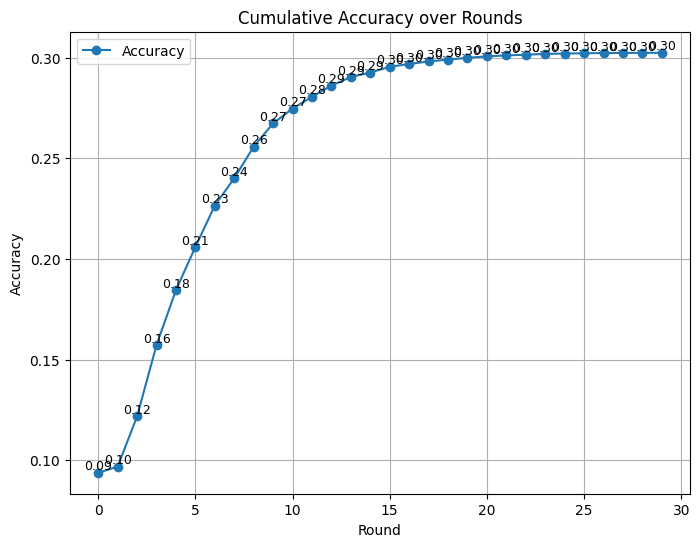

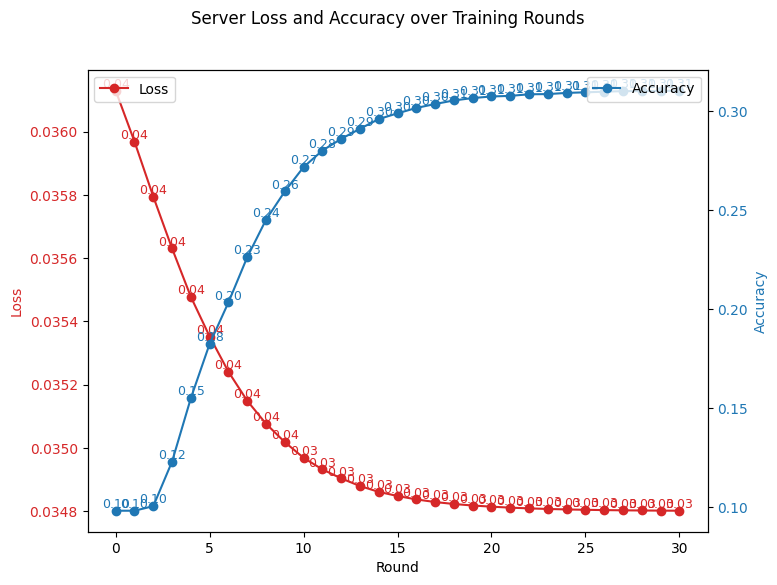

In [ ]:
from flwr.server.strategy import DifferentialPrivacyServerSideAdaptiveClipping

dpAdap_strategy = DifferentialPrivacyServerSideAdaptiveClipping(
    strategy,
    noise_multiplier = 0.1 ,
    num_sampled_clients = 5,
    initial_clipping_norm = 0.1,
    target_clipped_quantile = 0.5,
    clip_norm_lr = 0.5,
    # clipped_count_stddev,
)

run_my_sim(
    strategy = dpAdap_strategy,
    num_rounds = Num_rounds,
    num_clients = NUM_CLIENTS,
)

## DP **Client-side**

### **Fixed**

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[codecarbon INFO @ 09:01:12] [setup] RAM Tracking...
[codecarbon INFO @ 09:01:12] [setup] CPU Tracking...
[codecarbon WARNING @ 09:01:12] No CPU tracking mode found. Falling back on CPU constant mode. 
 Linux OS detected: Please ensure RAPL files exist at \sys\class\powercap\intel-rapl to measure CPU



model is reset.. dont beleve me?.. acc= 0.11308333333333333 
No GPU found.


[codecarbon WARNING @ 09:01:14] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 09:01:14] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 09:01:14] [setup] GPU Tracking...
[codecarbon INFO @ 09:01:14] No GPU found.
[codecarbon INFO @ 09:01:14] >>> Tracker's metadata:
[codecarbon INFO @ 09:01:14]   Platform system: Linux-6.1.85+-x86_64-with-glibc2.35
[codecarbon INFO @ 09:01:14]   Python version: 3.10.12
[codecarbon INFO @ 09:01:14]   CodeCarbon version: 2.8.2
[codecarbon INFO @ 09:01:14]   Available RAM : 12.675 GB
[codecarbon INFO @ 09:01:14]   CPU count: 2
[codecarbon INFO @ 09:01:14]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 09:01:14]   GPU count: None
[codecarbon INFO @ 09:01:14]   GPU model: None
[codecarbon INFO @ 09:01:14] Saving emissions data to file /content/emissions.csv
INFO :      Starting Flower ServerApp, config: num_rounds=30, no round_timeout

DifferentialPrivacyClientSideFixedClipping


(pid=38218) 2024-12-23 09:01:24.069668: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=38218) 2024-12-23 09:01:24.110685: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=38218) 2024-12-23 09:01:24.123136: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=38218) 2024-12-23 09:01:26.423604: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
[codecarbon INFO @ 09:01:29] Energy consumed for RAM : 0.000020 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:01:29] Energy consumed for all CPUs : 0.000177 kWh. Total CPU Power : 

(ClientAppActor pid=38218) [Client 1] get_parameters


[codecarbon INFO @ 09:01:44] Energy consumed for RAM : 0.000040 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:01:44] Energy consumed for all CPUs : 0.000354 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:01:44] 0.000394 kWh of electricity used since the beginning.
INFO :      initial parameters (loss, other metrics): 0.03622759397029877, {'accuracy': 0.0892}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.03622759397029877 / accuracy 0.0892
(ClientAppActor pid=38218) [Client 0, round 1] fit, config: {'server_round': 1, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01}


(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(pid=38216) 2024-12-23 09:01:24.087389: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=38216) 2024-12-23 09:01:24.127492: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=38216) 2024-12-23 09:01:24.139444: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=38216) 2024-12-23 09:01:26.423813: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(ClientAppActor pid=38218) [Client 5, round 1] fit, config: {'server_round': 1, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=38216) [Client 3, round 1] fit, config: {'server_round': 1, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01}


(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
[codecarbon INFO @ 09:01:59] Energy consumed for RAM : 0.000059 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:01:59] Energy consumed for all CPUs : 0.000531 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:01:59] 0.000591 kWh of electricity used since the beginning.
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=38216) [Client 7, round 1] fit, config: {'server_round': 1, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=38216) [Client 1, round 1] fit, config: {'server_round': 1, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000. [repeated 2x across cluster]
[codecarbon INFO @ 09:02:14] Energy consumed for RAM : 0.000079 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:02:14] Energy consumed for all CPUs : 0.000708 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:02:14] 0.000787 kWh of electricity used since the beginning.


(ClientAppActor pid=38218) [Client 2, round 1] fit, config: {'server_round': 1, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 3x across cluster]


(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000. [repeated 3x across cluster]
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: central DP noise with 0.0020 stdev added
INFO :      fit progress: (1, 0.036108836221694945, {'accuracy': 0.0892}, 42.197462467999685)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.036108836221694945 / accuracy 0.0892


[codecarbon INFO @ 09:02:29] Energy consumed for RAM : 0.000099 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:02:29] Energy consumed for all CPUs : 0.000885 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:02:29] 0.000984 kWh of electricity used since the beginning.


(ClientAppActor pid=38218) [Client 0] evaluate, config: {'current_round': 1}
(ClientAppActor pid=38216) [Client 7] evaluate, config: {'current_round': 1} [repeated 4x across cluster]
(ClientAppActor pid=38218) [Client 5] evaluate, config: {'current_round': 1} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.09183333333333334 0.03638868397474289 
(ClientAppActor pid=38216) [Client 2, round 2] fit, config: {'server_round': 2, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 09:02:44] Energy consumed for RAM : 0.000119 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:02:44] Energy consumed for all CPUs : 0.001062 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:02:44] 0.001181 kWh of electricity used since the beginning.
(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000. [repeated 2x across cluster]


(ClientAppActor pid=38218) [Client 5, round 2] fit, config: {'server_round': 2, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000. [repeated 2x across cluster]


(ClientAppActor pid=38218) [Client 8, round 2] fit, config: {'server_round': 2, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 09:02:59] Energy consumed for RAM : 0.000139 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:02:59] Energy consumed for all CPUs : 0.001239 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:02:59] 0.001378 kWh of electricity used since the beginning.
(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000. [repeated 2x across cluster]


(ClientAppActor pid=38218) [Client 6, round 2] fit, config: {'server_round': 2, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000. [repeated 2x across cluster]


(ClientAppActor pid=38216) [Client 1, round 2] fit, config: {'server_round': 2, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 09:03:14] Energy consumed for RAM : 0.000158 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:03:14] Energy consumed for all CPUs : 0.001416 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:03:14] 0.001575 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:03:14] 0.001820 g.CO2eq/s mean an estimation of 57.40409662826555 kg.CO2eq/year
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000. [repeated 2x across cluster]
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: central DP noise with 0.0020 stdev added
INFO :      fit progress: (2, 0.0359375284910202, {'accuracy': 0.0892}, 96.73560265600008)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.0359375284910202 / accuracy 0.0892
(ClientAppActor pid=38216) [Client 3] evaluate, config: {'current_round': 2}
(ClientAppActor pid=38218) [Client 3, round 2] fit, config: {'server_round': 2, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 09:03:29] Energy consumed for RAM : 0.000178 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:03:29] Energy consumed for all CPUs : 0.001593 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:03:29] 0.001772 kWh of electricity used since the beginning.


(ClientAppActor pid=38218) [Client 9] evaluate, config: {'current_round': 2} [repeated 4x across cluster]
(ClientAppActor pid=38218) [Client 6] evaluate, config: {'current_round': 2} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.09183333333333334 0.036216478288173676 
(ClientAppActor pid=38218) [Client 4, round 3] fit, config: {'server_round': 3, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01}


(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000. [repeated 2x across cluster]


(ClientAppActor pid=38216) [Client 0] evaluate, config: {'current_round': 2}
(ClientAppActor pid=38216) [Client 5, round 3] fit, config: {'server_round': 3, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 09:03:44] Energy consumed for RAM : 0.000198 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:03:44] Energy consumed for all CPUs : 0.001771 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:03:44] 0.001969 kWh of electricity used since the beginning.
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000. [repeated 2x across cluster]


(ClientAppActor pid=38216) [Client 8, round 3] fit, config: {'server_round': 3, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000. [repeated 2x across cluster]


(ClientAppActor pid=38218) [Client 6, round 3] fit, config: {'server_round': 3, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 09:03:59] Energy consumed for RAM : 0.000218 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:03:59] Energy consumed for all CPUs : 0.001948 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:03:59] 0.002165 kWh of electricity used since the beginning.
(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000. [repeated 2x across cluster]


(ClientAppActor pid=38218) [Client 0, round 3] fit, config: {'server_round': 3, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000. [repeated 2x across cluster]
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: central DP noise with 0.0020 stdev added
[codecarbon INFO @ 09:04:14] Energy consumed for RAM : 0.000238 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:04:14] Energy consumed for all CPUs : 0.002125 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:04:14] 0.002362 kWh of electricity used since the beginning.
INFO :      fit progress: (3, 0.035691682648658754, {'accuracy': 0.0892}, 152.0386488590002)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.035691682648658754 / accuracy 0.0892
(ClientAppActor pid=38218) [Client 1] evaluate, config: {'current_round': 3}
(ClientAppActor pid=38216) [Client 1, round 3] fit, config: {'server_round': 3, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=38218) [Client 7] evaluate, config: {'current_round': 3} [repeated 4x across cluster]


[codecarbon INFO @ 09:04:29] Energy consumed for RAM : 0.000257 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:04:29] Energy consumed for all CPUs : 0.002302 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:04:29] 0.002559 kWh of electricity used since the beginning.


(ClientAppActor pid=38218) [Client 2] evaluate, config: {'current_round': 3} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.09183333333333334 0.03597152346372604 
(ClientAppActor pid=38216) [Client 0, round 4] fit, config: {'server_round': 4, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01}


(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000. [repeated 2x across cluster]


(ClientAppActor pid=38216) [Client 4] evaluate, config: {'current_round': 3}
(ClientAppActor pid=38216) [Client 3, round 4] fit, config: {'server_round': 4, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 09:04:44] Energy consumed for RAM : 0.000277 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:04:44] Energy consumed for all CPUs : 0.002479 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:04:44] 0.002756 kWh of electricity used since the beginning.
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000. [repeated 2x across cluster]


(ClientAppActor pid=38216) [Client 7, round 4] fit, config: {'server_round': 4, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000. [repeated 2x across cluster]


(ClientAppActor pid=38216) [Client 8, round 4] fit, config: {'server_round': 4, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000. [repeated 2x across cluster]


(ClientAppActor pid=38216) [Client 6, round 4] fit, config: {'server_round': 4, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 09:04:59] Energy consumed for RAM : 0.000297 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:04:59] Energy consumed for all CPUs : 0.002656 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:04:59] 0.002953 kWh of electricity used since the beginning.
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000. [repeated 2x across cluster]
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: central DP noise with 0.0020 stdev added
INFO :      fit progress: (4, 0.03539796941280365, {'accuracy': 0.09}, 205.18721390500014)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.03539796941280365 / accuracy 0.09
(ClientAppActor pid=38216) [Client 2] evaluate, config: {'current_round': 4}
(ClientAppActor pid=38218) [Client 1, round 4] fit, config: {'server_round': 4, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 09:05:14] Energy consumed for RAM : 0.000317 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:05:14] Energy consumed for all CPUs : 0.002833 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:05:14] 0.003150 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:05:14] 0.001821 g.CO2eq/s mean an estimation of 57.413571665219386 kg.CO2eq/year


(ClientAppActor pid=38216) [Client 8] evaluate, config: {'current_round': 4} [repeated 4x across cluster]
(ClientAppActor pid=38218) [Client 4] evaluate, config: {'current_round': 4} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.09275 0.035682052373886115 
(ClientAppActor pid=38216) [Client 3, round 5] fit, config: {'server_round': 5, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 09:05:29] Energy consumed for RAM : 0.000337 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:05:29] Energy consumed for all CPUs : 0.003010 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:05:29] 0.003347 kWh of electricity used since the beginning.
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000. [repeated 2x across cluster]


(ClientAppActor pid=38218) [Client 5, round 5] fit, config: {'server_round': 5, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000. [repeated 2x across cluster]


(ClientAppActor pid=38218) [Client 8, round 5] fit, config: {'server_round': 5, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 09:05:44] Energy consumed for RAM : 0.000356 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:05:44] Energy consumed for all CPUs : 0.003187 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:05:44] 0.003543 kWh of electricity used since the beginning.
(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000. [repeated 2x across cluster]


(ClientAppActor pid=38218) [Client 6, round 5] fit, config: {'server_round': 5, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000. [repeated 2x across cluster]


(ClientAppActor pid=38216) [Client 0, round 5] fit, config: {'server_round': 5, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 09:05:59] Energy consumed for RAM : 0.000376 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:05:59] Energy consumed for all CPUs : 0.003364 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:05:59] 0.003740 kWh of electricity used since the beginning.
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000. [repeated 2x across cluster]
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: central DP noise with 0.0020 stdev added
INFO :      fit progress: (5, 0.03502836830615998, {'accuracy': 0.1006}, 259.98946204099957)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.03502836830615998 / accuracy 0.1006
(ClientAppActor pid=38218) [Client 1] evaluate, config: {'current_round': 5}
(ClientAppActor pid=38218) [Client 2, round 5] fit, config: {'server_round': 5, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=38218) [Client 6] evaluate, config: {'current_round': 5} [repeated 4x across cluster]


[codecarbon INFO @ 09:06:14] Energy consumed for RAM : 0.000396 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:06:14] Energy consumed for all CPUs : 0.003541 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:06:14] 0.003937 kWh of electricity used since the beginning.


(ClientAppActor pid=38218) [Client 0] evaluate, config: {'current_round': 5} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.10541666666666666 0.035317205349604294 
(ClientAppActor pid=38218) [Client 1, round 6] fit, config: {'server_round': 6, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01}


(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000. [repeated 2x across cluster]


(ClientAppActor pid=38216) [Client 7] evaluate, config: {'current_round': 5}
(ClientAppActor pid=38218) [Client 2, round 6] fit, config: {'server_round': 6, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 09:06:29] Energy consumed for RAM : 0.000416 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:06:29] Energy consumed for all CPUs : 0.003718 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:06:29] 0.004134 kWh of electricity used since the beginning.
(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000. [repeated 2x across cluster]


(ClientAppActor pid=38216) [Client 9, round 6] fit, config: {'server_round': 6, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000. [repeated 2x across cluster]


(ClientAppActor pid=38216) [Client 4, round 6] fit, config: {'server_round': 6, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 09:06:44] Energy consumed for RAM : 0.000435 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:06:44] Energy consumed for all CPUs : 0.003895 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:06:44] 0.004331 kWh of electricity used since the beginning.
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000. [repeated 2x across cluster]


(ClientAppActor pid=38216) [Client 7, round 6] fit, config: {'server_round': 6, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000. [repeated 2x across cluster]
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: central DP noise with 0.0020 stdev added
[codecarbon INFO @ 09:06:59] Energy consumed for RAM : 0.000455 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:06:59] Energy consumed for all CPUs : 0.004072 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:06:59] 0.004527 kWh of electricity used since the beginning.
INFO :      fit progress: (6, 0.03460874857902527, {'accuracy': 0.1686}, 316.0757010360003)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.03460874857902527 / accuracy 0.1686
(ClientAppActor pid=38218) [Client 0] evaluate, config: {'current_round': 6}
(ClientAppActor pid=38218) [Client 5, round 6] fit, config: {'server_round': 6, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=38218) [Client 6] evaluate, config: {'current_round': 6} [repeated 4x across cluster]
(ClientAppActor pid=38216) [Client 7] evaluate, config: {'current_round': 6} [repeated 5x across cluster]


[codecarbon INFO @ 09:07:14] Energy consumed for RAM : 0.000475 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:07:14] Energy consumed for all CPUs : 0.004249 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:07:14] 0.004724 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:07:14] 0.001820 g.CO2eq/s mean an estimation of 57.404461456443556 kg.CO2eq/year
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.17658333333333334 0.03490038375059764 
(ClientAppActor pid=38218) [Client 4, round 7] fit, config: {'server_round': 7, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01}


(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000. [repeated 2x across cluster]


(ClientAppActor pid=38218) [Client 5, round 7] fit, config: {'server_round': 7, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000. [repeated 2x across cluster]
[codecarbon INFO @ 09:07:29] Energy consumed for RAM : 0.000495 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:07:29] Energy consumed for all CPUs : 0.004427 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:07:29] 0.004921 kWh of electricity used since the beginning.


(ClientAppActor pid=38218) [Client 7, round 7] fit, config: {'server_round': 7, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000. [repeated 2x across cluster]


(ClientAppActor pid=38218) [Client 2, round 7] fit, config: {'server_round': 7, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000. [repeated 2x across cluster]


(ClientAppActor pid=38218) [Client 3, round 7] fit, config: {'server_round': 7, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 09:07:44] Energy consumed for RAM : 0.000515 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:07:44] Energy consumed for all CPUs : 0.004604 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:07:44] 0.005119 kWh of electricity used since the beginning.
(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000. [repeated 2x across cluster]
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: central DP noise with 0.0020 stdev added
INFO :      fit progress: (7, 0.03410693039894104, {'accuracy': 0.2495}, 368.62511959899985)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.03410693039894104 / accuracy 0.2495
(ClientAppActor pid=38216) [Client 1] evaluate, config: {'current_round': 7}
(ClientAppActor pid=38216) [Client 1, round 7] fit, config: {'server_round': 7, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 09:07:59] Energy consumed for RAM : 0.000535 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:07:59] Energy consumed for all CPUs : 0.004781 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:07:59] 0.005316 kWh of electricity used since the beginning.


(ClientAppActor pid=38216) [Client 6] evaluate, config: {'current_round': 7} [repeated 4x across cluster]
(ClientAppActor pid=38218) [Client 5] evaluate, config: {'current_round': 7} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.25241666666666673 0.03440489701430003 
(ClientAppActor pid=38216) [Client 2, round 8] fit, config: {'server_round': 8, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 09:08:14] Energy consumed for RAM : 0.000554 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:08:14] Energy consumed for all CPUs : 0.004958 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:08:14] 0.005513 kWh of electricity used since the beginning.
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000. [repeated 2x across cluster]


(ClientAppActor pid=38216) [Client 4, round 8] fit, config: {'server_round': 8, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000. [repeated 2x across cluster]


(ClientAppActor pid=38216) [Client 6, round 8] fit, config: {'server_round': 8, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000. [repeated 2x across cluster]
[codecarbon INFO @ 09:08:29] Energy consumed for RAM : 0.000574 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:08:29] Energy consumed for all CPUs : 0.005135 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:08:29] 0.005709 kWh of electricity used since the beginning.


(ClientAppActor pid=38216) [Client 0, round 8] fit, config: {'server_round': 8, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000. [repeated 2x across cluster]


(ClientAppActor pid=38218) [Client 8, round 8] fit, config: {'server_round': 8, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 3x across cluster]


(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000. [repeated 3x across cluster]
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: central DP noise with 0.0020 stdev added
[codecarbon INFO @ 09:08:44] Energy consumed for RAM : 0.000594 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:08:44] Energy consumed for all CPUs : 0.005312 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:08:44] 0.005906 kWh of electricity used since the beginning.
INFO :      fit progress: (8, 0.03346291058063507, {'accuracy': 0.3617}, 420.40990170500027)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.03346291058063507 / accuracy 0.3617
(ClientAppActor pid=38218) [Client 2] evaluate, config: {'current_round': 8}
(ClientAppActor pid=38216) [Client 9] evaluate, config: {'current_round': 8} [repeated 5x across cluster]
(ClientAppActor pid=38218) [Client 0] evaluate, config: {'current_round': 8} [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.36133333333333334 0.0337704525788625 


[codecarbon INFO @ 09:08:59] Energy consumed for RAM : 0.000614 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:08:59] Energy consumed for all CPUs : 0.005489 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:08:59] 0.006103 kWh of electricity used since the beginning.


(ClientAppActor pid=38216) [Client 0, round 9] fit, config: {'server_round': 9, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01}


(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=38216) [Client 1] evaluate, config: {'current_round': 8}
(ClientAppActor pid=38218) [Client 5, round 9] fit, config: {'server_round': 9, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
[codecarbon INFO @ 09:09:14] Energy consumed for RAM : 0.000633 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:09:14] Energy consumed for all CPUs : 0.005666 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:09:14] 0.006300 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:09:14] 0.001821 g.CO2eq/s mean an estimation of 57.41286967868011 kg.CO2eq/year


(ClientAppActor pid=38218) [Client 6, round 9] fit, config: {'server_round': 9, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=38218) [Client 3, round 9] fit, config: {'server_round': 9, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=38218) [Client 9, round 9] fit, config: {'server_round': 9, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 09:09:29] Energy consumed for RAM : 0.000653 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:09:29] Energy consumed for all CPUs : 0.005844 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:09:29] 0.006497 kWh of electricity used since the beginning.
(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: central DP noise with 0.0020 stdev added
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
INFO :      fit progress: (9, 0.03280679013729095, {'accuracy': 0.4267}, 473.7712599489996)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.03280679013729095 / accuracy 0.4267
(ClientAppActor pid=38218) [Client 3] evaluate, config: {'current_round': 9}
(ClientAppActor pid=38216) [Client 7, round 9] fit, config: {'server_round': 9, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 09:09:44] Energy consumed for RAM : 0.000673 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:09:44] Energy consumed for all CPUs : 0.006021 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:09:44] 0.006694 kWh of electricity used since the beginning.


(ClientAppActor pid=38216) [Client 8] evaluate, config: {'current_round': 9} [repeated 4x across cluster]
(ClientAppActor pid=38218) [Client 5] evaluate, config: {'current_round': 9} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.4266666666666668 0.03312508702278137 
(ClientAppActor pid=38218) [Client 0, round 10] fit, config: {'server_round': 10, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 09:09:59] Energy consumed for RAM : 0.000693 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:09:59] Energy consumed for all CPUs : 0.006198 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:09:59] 0.006891 kWh of electricity used since the beginning.
(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=38216) [Client 6, round 10] fit, config: {'server_round': 10, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=38216) [Client 7, round 10] fit, config: {'server_round': 10, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
[codecarbon INFO @ 09:10:14] Energy consumed for RAM : 0.000713 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:10:14] Energy consumed for all CPUs : 0.006375 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:10:14] 0.007087 kWh of electricity used since the beginning.
(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=38216) [Client 1, round 10] fit, config: {'server_round': 10, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=38216) [Client 2, round 10] fit, config: {'server_round': 10, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: central DP noise with 0.0020 stdev added
[codecarbon INFO @ 09:10:29] Energy consumed for RAM : 0.000732 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:10:29] Energy consumed for all CPUs : 0.006552 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:10:29] 0.007284 kWh of electricity used since the beginning.
INFO :      fit progress: (10, 0.03203600099086761, {'accuracy': 0.4883}, 529.1097635529995)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.03203600099086761 / accuracy 0.4883
(ClientAppActor pid=38216) [Client 4] evaluate, config: {'current_round': 10}
(ClientAppActor pid=38218) [Client 8, round 10] fit, config: {'server_round': 10, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=38216) [Client 7] evaluate, config: {'current_round': 10} [repeated 4x across cluster]


[codecarbon INFO @ 09:10:44] Energy consumed for RAM : 0.000752 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:10:44] Energy consumed for all CPUs : 0.006729 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:10:44] 0.007481 kWh of electricity used since the beginning.


(ClientAppActor pid=38216) [Client 3] evaluate, config: {'current_round': 10} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.4889166666666667 0.03236272071798642 
(ClientAppActor pid=38216) [Client 3, round 11] fit, config: {'server_round': 11, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01}


(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=38218) [Client 0] evaluate, config: {'current_round': 10}
(ClientAppActor pid=38216) [Client 7, round 11] fit, config: {'server_round': 11, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 09:10:59] Energy consumed for RAM : 0.000772 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:10:59] Energy consumed for all CPUs : 0.006906 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:10:59] 0.007678 kWh of electricity used since the beginning.
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=38216) [Client 8, round 11] fit, config: {'server_round': 11, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=38216) [Client 0, round 11] fit, config: {'server_round': 11, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 09:11:14] Energy consumed for RAM : 0.000792 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:11:14] Energy consumed for all CPUs : 0.007083 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:11:14] 0.007874 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:11:14] 0.001820 g.CO2eq/s mean an estimation of 57.39722239381963 kg.CO2eq/year
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=38216) [Client 1, round 11] fit, config: {'server_round': 11, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: central DP noise with 0.0020 stdev added
INFO :      fit progress: (11, 0.031241071367263794, {'accuracy': 0.5527}, 582.9691333009996)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.031241071367263794 / accuracy 0.5527


[codecarbon INFO @ 09:11:29] Energy consumed for RAM : 0.000812 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:11:29] Energy consumed for all CPUs : 0.007260 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:11:29] 0.008071 kWh of electricity used since the beginning.


(ClientAppActor pid=38216) [Client 1] evaluate, config: {'current_round': 11}
(ClientAppActor pid=38218) [Client 6, round 11] fit, config: {'server_round': 11, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=38218) [Client 7] evaluate, config: {'current_round': 11} [repeated 5x across cluster]
(ClientAppActor pid=38216) [Client 4] evaluate, config: {'current_round': 11} [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.5524166666666667 0.03157741468151411 
(ClientAppActor pid=38216) [Client 3, round 12] fit, config: {'server_round': 12, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 09:11:44] Energy consumed for RAM : 0.000831 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:11:44] Energy consumed for all CPUs : 0.007437 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:11:44] 0.008268 kWh of electricity used since the beginning.
(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=38218) [Client 2] evaluate, config: {'current_round': 11}
(ClientAppActor pid=38216) [Client 6, round 12] fit, config: {'server_round': 12, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=38218) [Client 8, round 12] fit, config: {'server_round': 12, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 09:11:59] Energy consumed for RAM : 0.000851 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:11:59] Energy consumed for all CPUs : 0.007614 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:11:59] 0.008465 kWh of electricity used since the beginning.
(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=38216) [Client 7, round 12] fit, config: {'server_round': 12, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=38216) [Client 5, round 12] fit, config: {'server_round': 12, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 09:12:14] Energy consumed for RAM : 0.000871 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:12:14] Energy consumed for all CPUs : 0.007791 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:12:14] 0.008662 kWh of electricity used since the beginning.
INFO :      aggregate_fit: received 10 results and 0 failures
(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: central DP noise with 0.0020 stdev added
INFO :      fit progress: (12, 0.030364988541603088, {'accuracy': 0.6286}, 639.8119358559998)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.030364988541603088 / accuracy 0.6286
(ClientAppActor pid=38218) [Client 0] evaluate, config: {'current_round': 12}
(ClientAppActor pid=38218) [Client 0, round 12] fit, config: {'server_round': 12, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 09:12:29] Energy consumed for RAM : 0.000891 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:12:29] Energy consumed for all CPUs : 0.007968 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:12:29] 0.008858 kWh of electricity used since the beginning.


(ClientAppActor pid=38216) [Client 7] evaluate, config: {'current_round': 12} [repeated 4x across cluster]
(ClientAppActor pid=38216) [Client 5] evaluate, config: {'current_round': 12} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.6190000000000001 0.030713495214780166 
(ClientAppActor pid=38218) [Client 0, round 13] fit, config: {'server_round': 13, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 09:12:44] Energy consumed for RAM : 0.000911 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:12:44] Energy consumed for all CPUs : 0.008145 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:12:44] 0.009055 kWh of electricity used since the beginning.
(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=38218) [Client 2] evaluate, config: {'current_round': 12}
(ClientAppActor pid=38218) [Client 4, round 13] fit, config: {'server_round': 13, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=38218) [Client 7, round 13] fit, config: {'server_round': 13, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
[codecarbon INFO @ 09:12:59] Energy consumed for RAM : 0.000930 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:12:59] Energy consumed for all CPUs : 0.008322 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:12:59] 0.009252 kWh of electricity used since the beginning.


(ClientAppActor pid=38218) [Client 2, round 13] fit, config: {'server_round': 13, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=38218) [Client 9, round 13] fit, config: {'server_round': 13, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: central DP noise with 0.0020 stdev added
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
[codecarbon INFO @ 09:13:14] Energy consumed for RAM : 0.000950 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:13:14] Energy consumed for all CPUs : 0.008499 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:13:14] 0.009449 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:13:14] 0.001820 g.CO2eq/s mean an estimation of 57.4068466512606 kg.CO2eq/year
INFO :      fit progress: (13, 0.029507021713256837, {'accuracy': 0.6788}, 693.0794105479999)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.029507021713256837 / accuracy 0.6788
(ClientAppActor pid=38216) [Client 2] evaluate, config: {'current_round': 13}
(ClientAppActor pid=38216) [Client 3, round 13] fit, config: {'server_round': 13, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=38216) [Client 8] evaluate, config: {'current_round': 13} [repeated 4x across cluster]


[codecarbon INFO @ 09:13:29] Energy consumed for RAM : 0.000970 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:13:29] Energy consumed for all CPUs : 0.008676 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:13:29] 0.009646 kWh of electricity used since the beginning.


(ClientAppActor pid=38216) [Client 0] evaluate, config: {'current_round': 13} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.6730000000000002 0.029864790340264638 
(ClientAppActor pid=38216) [Client 4, round 14] fit, config: {'server_round': 14, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01}


(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=38218) [Client 4] evaluate, config: {'current_round': 13}
(ClientAppActor pid=38216) [Client 5, round 14] fit, config: {'server_round': 14, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 09:13:44] Energy consumed for RAM : 0.000990 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:13:44] Energy consumed for all CPUs : 0.008853 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:13:44] 0.009843 kWh of electricity used since the beginning.
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=38216) [Client 8, round 14] fit, config: {'server_round': 14, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=38216) [Client 2, round 14] fit, config: {'server_round': 14, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 09:13:59] Energy consumed for RAM : 0.001010 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:13:59] Energy consumed for all CPUs : 0.009030 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:13:59] 0.010039 kWh of electricity used since the beginning.
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=38216) [Client 0, round 14] fit, config: {'server_round': 14, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000. [repeated 2x across cluster]
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: central DP noise with 0.0020 stdev added
INFO :      fit progress: (14, 0.028445543789863588, {'accuracy': 0.723}, 747.6853879390001)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.028445543789863588 / accuracy 0.723


[codecarbon INFO @ 09:14:14] Energy consumed for RAM : 0.001029 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:14:14] Energy consumed for all CPUs : 0.009207 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:14:14] 0.010236 kWh of electricity used since the beginning.


(ClientAppActor pid=38216) [Client 1] evaluate, config: {'current_round': 14}
(ClientAppActor pid=38218) [Client 7, round 14] fit, config: {'server_round': 14, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=38216) [Client 8] evaluate, config: {'current_round': 14} [repeated 4x across cluster]
(ClientAppActor pid=38218) [Client 6] evaluate, config: {'current_round': 14} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.7178333333333333 0.028811085700988774 
(ClientAppActor pid=38218) [Client 0, round 15] fit, config: {'server_round': 15, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 09:14:29] Energy consumed for RAM : 0.001049 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:14:29] Energy consumed for all CPUs : 0.009384 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:14:29] 0.010433 kWh of electricity used since the beginning.
(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=38218) [Client 3, round 15] fit, config: {'server_round': 15, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=38218) [Client 8, round 15] fit, config: {'server_round': 15, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 09:14:44] Energy consumed for RAM : 0.001069 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:14:44] Energy consumed for all CPUs : 0.009561 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:14:44] 0.010630 kWh of electricity used since the beginning.
(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=38218) [Client 1, round 15] fit, config: {'server_round': 15, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=38218) [Client 4, round 15] fit, config: {'server_round': 15, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: central DP noise with 0.0020 stdev added
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
[codecarbon INFO @ 09:14:59] Energy consumed for RAM : 0.001089 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:14:59] Energy consumed for all CPUs : 0.009738 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:14:59] 0.010826 kWh of electricity used since the beginning.
INFO :      fit progress: (15, 0.027471073162555693, {'accuracy': 0.7532}, 799.2268517840002)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.027471073162555693 / accuracy 0.7532
(ClientAppActor pid=38216) [Client 0] evaluate, config: {'current_round': 15}
(ClientAppActor pid=38216) [Client 5, round 15] fit, config: {'server_round': 15, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=38216) [Client 8] evaluate, config: {'current_round': 15} [repeated 4x across cluster]


[codecarbon INFO @ 09:15:14] Energy consumed for RAM : 0.001108 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:15:14] Energy consumed for all CPUs : 0.009915 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:15:14] 0.011023 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:15:14] 0.001820 g.CO2eq/s mean an estimation of 57.40405850482617 kg.CO2eq/year


(ClientAppActor pid=38218) [Client 6] evaluate, config: {'current_round': 15} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.7477499999999999 0.027845476686954498 
(ClientAppActor pid=38216) [Client 3, round 16] fit, config: {'server_round': 16, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01}


(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=38218) [Client 5, round 16] fit, config: {'server_round': 16, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 09:15:29] Energy consumed for RAM : 0.001128 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:15:29] Energy consumed for all CPUs : 0.010092 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:15:29] 0.011220 kWh of electricity used since the beginning.
(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=38218) [Client 6, round 16] fit, config: {'server_round': 16, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=38218) [Client 0, round 16] fit, config: {'server_round': 16, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 09:15:44] Energy consumed for RAM : 0.001148 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:15:44] Energy consumed for all CPUs : 0.010269 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:15:44] 0.011417 kWh of electricity used since the beginning.
(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=38216) [Client 1, round 16] fit, config: {'server_round': 16, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: central DP noise with 0.0020 stdev added
[codecarbon INFO @ 09:15:59] Energy consumed for RAM : 0.001168 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:15:59] Energy consumed for all CPUs : 0.010446 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:15:59] 0.011614 kWh of electricity used since the beginning.
INFO :      fit progress: (16, 0.026424626278877258, {'accuracy': 0.7852}, 855.1155444589995)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.026424626278877258 / accuracy 0.7852
(ClientAppActor pid=38216) [Client 0] evaluate, config: {'current_round': 16}
(ClientAppActor pid=38218) [Client 8, round 16] fit, config: {'server_round': 16, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=38216) [Client 9] evaluate, config: {'current_round': 16} [repeated 4x across cluster]
(ClientAppActor pid=38216) [Client 2] evaluate, config: {'current_round': 16} [repeated 4x across cluster]


[codecarbon INFO @ 09:16:14] Energy consumed for RAM : 0.001188 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:16:14] Energy consumed for all CPUs : 0.010623 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:16:14] 0.011811 kWh of electricity used since the beginning.
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.7791666666666666 0.026810284634431206 
(ClientAppActor pid=38218) [Client 0, round 17] fit, config: {'server_round': 17, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01}


(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=38218) [Client 8] evaluate, config: {'current_round': 16}
(ClientAppActor pid=38218) [Client 5, round 17] fit, config: {'server_round': 17, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
[codecarbon INFO @ 09:16:29] Energy consumed for RAM : 0.001207 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:16:29] Energy consumed for all CPUs : 0.010800 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:16:29] 0.012008 kWh of electricity used since the beginning.


(ClientAppActor pid=38216) [Client 8, round 17] fit, config: {'server_round': 17, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=38216) [Client 2, round 17] fit, config: {'server_round': 17, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=38216) [Client 4, round 17] fit, config: {'server_round': 17, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 09:16:44] Energy consumed for RAM : 0.001227 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:16:44] Energy consumed for all CPUs : 0.010977 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:16:44] 0.012204 kWh of electricity used since the beginning.
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: received 10 results and 0 failures
(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: central DP noise with 0.0020 stdev added
INFO :      fit progress: (17, 0.025273776388168336, {'accuracy': 0.8211}, 910.12559237)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.025273776388168336 / accuracy 0.8211
(ClientAppActor pid=38216) [Client 3] evaluate, config: {'current_round': 17}
(ClientAppActor pid=38218) [Client 6, round 17] fit, config: {'server_round': 17, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 09:16:59] Energy consumed for RAM : 0.001247 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:16:59] Energy consumed for all CPUs : 0.011154 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:16:59] 0.012401 kWh of electricity used since the beginning.


(ClientAppActor pid=38216) [Client 8] evaluate, config: {'current_round': 17} [repeated 4x across cluster]
(ClientAppActor pid=38216) [Client 0] evaluate, config: {'current_round': 17} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.8163333333333332 0.025660924673080447 
(ClientAppActor pid=38216) [Client 2, round 18] fit, config: {'server_round': 18, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 09:17:14] Energy consumed for RAM : 0.001267 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:17:14] Energy consumed for all CPUs : 0.011331 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:17:14] 0.012598 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:17:14] 0.001820 g.CO2eq/s mean an estimation of 57.41040347808305 kg.CO2eq/year
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=38218) [Client 4] evaluate, config: {'current_round': 17}
(ClientAppActor pid=38216) [Client 3, round 18] fit, config: {'server_round': 18, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=38216) [Client 5, round 18] fit, config: {'server_round': 18, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 09:17:29] Energy consumed for RAM : 0.001287 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:17:29] Energy consumed for all CPUs : 0.011508 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:17:29] 0.012795 kWh of electricity used since the beginning.
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=38218) [Client 8, round 18] fit, config: {'server_round': 18, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=38218) [Client 9, round 18] fit, config: {'server_round': 18, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: central DP noise with 0.0020 stdev added
[codecarbon INFO @ 09:17:44] Energy consumed for RAM : 0.001306 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:17:44] Energy consumed for all CPUs : 0.011685 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:17:44] 0.012992 kWh of electricity used since the beginning.
INFO :      fit progress: (18, 0.02401106895208359, {'accuracy': 0.842}, 963.9446607079999)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.02401106895208359 / accuracy 0.842
(ClientAppActor pid=38216) [Client 2] evaluate, config: {'current_round': 18}
(ClientAppActor pid=38216) [Client 6, round 18] fit, config: {'server_round': 18, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=38216) [Client 8] evaluate, config: {'current_round': 18} [repeated 4x across cluster]


[codecarbon INFO @ 09:17:59] Energy consumed for RAM : 0.001326 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:17:59] Energy consumed for all CPUs : 0.011862 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:17:59] 0.013189 kWh of electricity used since the beginning.


(ClientAppActor pid=38216) [Client 1] evaluate, config: {'current_round': 18} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.8394166666666667 0.02440317283074061 
(ClientAppActor pid=38218) [Client 2, round 19] fit, config: {'server_round': 19, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01}


(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=38218) [Client 6] evaluate, config: {'current_round': 18}
(ClientAppActor pid=38218) [Client 3, round 19] fit, config: {'server_round': 19, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 09:18:14] Energy consumed for RAM : 0.001346 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:18:14] Energy consumed for all CPUs : 0.012039 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:18:14] 0.013385 kWh of electricity used since the beginning.
(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=38216) [Client 9, round 19] fit, config: {'server_round': 19, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=38216) [Client 4, round 19] fit, config: {'server_round': 19, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 09:18:29] Energy consumed for RAM : 0.001366 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:18:29] Energy consumed for all CPUs : 0.012216 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:18:29] 0.013582 kWh of electricity used since the beginning.
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=38216) [Client 1, round 19] fit, config: {'server_round': 19, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: central DP noise with 0.0020 stdev added
(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
[codecarbon INFO @ 09:18:44] Energy consumed for RAM : 0.001386 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:18:44] Energy consumed for all CPUs : 0.012393 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:18:44] 0.013779 kWh of electricity used since the beginning.
INFO :      fit progress: (19, 0.022446955454349517, {'accuracy': 0.8627}, 1020.4800204229996)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.022446955454349517 / accuracy 0.8627
(ClientAppActor pid=38216) [Client 3] evaluate, config: {'current_round': 19}
(ClientAppActor pid=38218) [Client 5, round 19] fit, config: {'server_round': 19, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=38218) [Client 8] evaluate, config: {'current_round': 19} [repeated 4x across cluster]
(ClientAppActor pid=38216) [Client 6] evaluate, config: {'current_round': 19} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
[codecarbon INFO @ 09:18:59] Energy consumed for RAM : 0.001405 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:18:59] Energy consumed for all CPUs : 0.012571 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:18:59] 0.013976 kWh of electricity used since the beginning.


My_weighted_average -0.8604166666666666 0.022847425778706867 
(ClientAppActor pid=38216) [Client 3, round 20] fit, config: {'server_round': 20, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01}


(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=38218) [Client 9, round 20] fit, config: {'server_round': 20, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
[codecarbon INFO @ 09:19:14] Energy consumed for RAM : 0.001425 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:19:14] Energy consumed for all CPUs : 0.012748 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:19:14] 0.014173 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:19:14] 0.001820 g.CO2eq/s mean an estimation of 57.398300917239716 kg.CO2eq/year
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=38216) [Client 8, round 20] fit, config: {'server_round': 20, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=38218) [Client 1, round 20] fit, config: {'server_round': 20, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
[codecarbon INFO @ 09:19:29] Energy consumed for RAM : 0.001445 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:19:29] Energy consumed for all CPUs : 0.012925 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:19:29] 0.014370 kWh of electricity used since the beginning.


(ClientAppActor pid=38218) [Client 2, round 20] fit, config: {'server_round': 20, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: central DP noise with 0.0020 stdev added
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
INFO :      fit progress: (20, 0.020942322850227357, {'accuracy': 0.8806}, 1075.282354993)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.020942322850227357 / accuracy 0.8806
(ClientAppActor pid=38216) [Client 3] evaluate, config: {'current_round': 20}
(ClientAppActor pid=38216) [Client 6, round 20] fit, config: {'server_round': 20, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 09:19:44] Energy consumed for RAM : 0.001465 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:19:44] Energy consumed for all CPUs : 0.013102 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:19:44] 0.014567 kWh of electricity used since the beginning.


(ClientAppActor pid=38218) [Client 7] evaluate, config: {'current_round': 20} [repeated 4x across cluster]
(ClientAppActor pid=38216) [Client 1] evaluate, config: {'current_round': 20} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.8755833333333333 0.021341500361760458 
(ClientAppActor pid=38218) [Client 1, round 21] fit, config: {'server_round': 21, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 09:19:59] Energy consumed for RAM : 0.001485 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:19:59] Energy consumed for all CPUs : 0.013279 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:19:59] 0.014764 kWh of electricity used since the beginning.
(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=38218) [Client 5] evaluate, config: {'current_round': 20}
(ClientAppActor pid=38218) [Client 6, round 21] fit, config: {'server_round': 21, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=38218) [Client 8, round 21] fit, config: {'server_round': 21, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
[codecarbon INFO @ 09:20:14] Energy consumed for RAM : 0.001504 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:20:14] Energy consumed for all CPUs : 0.013456 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:20:14] 0.014961 kWh of electricity used since the beginning.
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=38218) [Client 4, round 21] fit, config: {'server_round': 21, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=38218) [Client 2, round 21] fit, config: {'server_round': 21, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: central DP noise with 0.0020 stdev added
[codecarbon INFO @ 09:20:29] Energy consumed for RAM : 0.001524 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:20:29] Energy consumed for all CPUs : 0.013633 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:20:29] 0.015157 kWh of electricity used since the beginning.
INFO :      fit progress: (21, 0.01923410642147064, {'accuracy': 0.8936}, 1130.8707250759999)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.01923410642147064 / accuracy 0.8936
(ClientAppActor pid=38216) [Client 1] evaluate, config: {'current_round': 21}
(ClientAppActor pid=38216) [Client 5, round 21] fit, config: {'server_round': 21, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=38216) [Client 4] evaluate, config: {'current_round': 21} [repeated 4x across cluster]


[codecarbon INFO @ 09:20:44] Energy consumed for RAM : 0.001544 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:20:44] Energy consumed for all CPUs : 0.013810 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:20:44] 0.015354 kWh of electricity used since the beginning.


(ClientAppActor pid=38218) [Client 5] evaluate, config: {'current_round': 21} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.8901666666666667 0.01963072140018145 
(ClientAppActor pid=38216) [Client 0, round 22] fit, config: {'server_round': 22, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01}


(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=38216) [Client 3] evaluate, config: {'current_round': 21}
(ClientAppActor pid=38216) [Client 4, round 22] fit, config: {'server_round': 22, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 09:20:59] Energy consumed for RAM : 0.001564 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:20:59] Energy consumed for all CPUs : 0.013987 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:20:59] 0.015551 kWh of electricity used since the beginning.
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=38216) [Client 7, round 22] fit, config: {'server_round': 22, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=38216) [Client 6, round 22] fit, config: {'server_round': 22, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 09:21:14] Energy consumed for RAM : 0.001584 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:21:14] Energy consumed for all CPUs : 0.014164 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:21:14] 0.015748 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:21:14] 0.001820 g.CO2eq/s mean an estimation of 57.40559217743396 kg.CO2eq/year
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=38216) [Client 8, round 22] fit, config: {'server_round': 22, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: received 10 results and 0 failures
(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: central DP noise with 0.0020 stdev added
INFO :      fit progress: (22, 0.017631438851356505, {'accuracy': 0.8977}, 1183.588547204)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.017631438851356505 / accuracy 0.8977


[codecarbon INFO @ 09:21:29] Energy consumed for RAM : 0.001603 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:21:29] Energy consumed for all CPUs : 0.014341 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:21:29] 0.015945 kWh of electricity used since the beginning.


(ClientAppActor pid=38216) [Client 4] evaluate, config: {'current_round': 22}
(ClientAppActor pid=38218) [Client 3, round 22] fit, config: {'server_round': 22, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=38218) [Client 2] evaluate, config: {'current_round': 22} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.8963333333333331 0.018027353574832282 
(ClientAppActor pid=38216) [Client 1, round 23] fit, config: {'server_round': 23, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=38216) [Client 9] evaluate, config: {'current_round': 22} [repeated 5x across cluster]


[codecarbon INFO @ 09:21:44] Energy consumed for RAM : 0.001623 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:21:44] Energy consumed for all CPUs : 0.014518 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:21:44] 0.016141 kWh of electricity used since the beginning.
(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=38218) [Client 4, round 23] fit, config: {'server_round': 23, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=38216) [Client 8, round 23] fit, config: {'server_round': 23, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 09:21:59] Energy consumed for RAM : 0.001643 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:21:59] Energy consumed for all CPUs : 0.014695 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:21:59] 0.016338 kWh of electricity used since the beginning.
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=38216) [Client 2, round 23] fit, config: {'server_round': 23, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=38216) [Client 7, round 23] fit, config: {'server_round': 23, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 09:22:14] Energy consumed for RAM : 0.001663 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:22:14] Energy consumed for all CPUs : 0.014872 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:22:14] 0.016535 kWh of electricity used since the beginning.
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: central DP noise with 0.0020 stdev added
INFO :      fit progress: (23, 0.016163195818662643, {'accuracy': 0.9024}, 1238.0091129510001)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.016163195818662643 / accuracy 0.9024
(ClientAppActor pid=38216) [Client 1] evaluate, config: {'current_round': 23}
(ClientAppActor pid=38218) [Client 0, round 23] fit, config: {'server_round': 23, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 09:22:29] Energy consumed for RAM : 0.001682 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:22:29] Energy consumed for all CPUs : 0.015049 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:22:29] 0.016732 kWh of electricity used since the beginning.


(ClientAppActor pid=38218) [Client 9] evaluate, config: {'current_round': 23} [repeated 5x across cluster]
(ClientAppActor pid=38216) [Client 5] evaluate, config: {'current_round': 23} [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.9005833333333334 0.01655844891568025 
(ClientAppActor pid=38216) [Client 1, round 24] fit, config: {'server_round': 24, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01}


(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
[codecarbon INFO @ 09:22:44] Energy consumed for RAM : 0.001702 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:22:44] Energy consumed for all CPUs : 0.015226 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:22:44] 0.016929 kWh of electricity used since the beginning.


(ClientAppActor pid=38218) [Client 2] evaluate, config: {'current_round': 23}
(ClientAppActor pid=38218) [Client 3, round 24] fit, config: {'server_round': 24, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=38218) [Client 7, round 24] fit, config: {'server_round': 24, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=38218) [Client 2, round 24] fit, config: {'server_round': 24, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 09:22:59] Energy consumed for RAM : 0.001722 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:22:59] Energy consumed for all CPUs : 0.015403 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:22:59] 0.017125 kWh of electricity used since the beginning.
(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=38218) [Client 5, round 24] fit, config: {'server_round': 24, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: received 10 results and 0 failures
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: central DP noise with 0.0020 stdev added
[codecarbon INFO @ 09:23:14] Energy consumed for RAM : 0.001742 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:23:14] Energy consumed for all CPUs : 0.015580 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:23:14] 0.017322 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:23:14] 0.001820 g.CO2eq/s mean an estimation of 57.400109437612024 kg.CO2eq/year
INFO :      fit progress: (24, 0.014676355224847793, {'accuracy': 0.9104}, 1293.1440512179997)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.014676355224847793 / accuracy 0.9104
(ClientAppActor pid=38216) [Client 3] evaluate, config: {'current_round': 24}
(ClientAppActor pid=38216) [Client 6, round 24] fit, config: {'server_round': 24, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=38216) [Client 9] evaluate, config: {'current_round': 24} [repeated 4x across cluster]


[codecarbon INFO @ 09:23:29] Energy consumed for RAM : 0.001762 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:23:29] Energy consumed for all CPUs : 0.015757 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:23:29] 0.017519 kWh of electricity used since the beginning.


(ClientAppActor pid=38218) [Client 2] evaluate, config: {'current_round': 24} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.9094166666666668 0.015071369022130965 
(ClientAppActor pid=38216) [Client 1, round 25] fit, config: {'server_round': 25, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01}


(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=38218) [Client 4, round 25] fit, config: {'server_round': 25, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 09:23:44] Energy consumed for RAM : 0.001781 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:23:44] Energy consumed for all CPUs : 0.015934 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:23:44] 0.017716 kWh of electricity used since the beginning.
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=38216) [Client 7, round 25] fit, config: {'server_round': 25, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=38218) [Client 8, round 25] fit, config: {'server_round': 25, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
[codecarbon INFO @ 09:23:59] Energy consumed for RAM : 0.001801 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:23:59] Energy consumed for all CPUs : 0.016111 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:23:59] 0.017913 kWh of electricity used since the beginning.


(ClientAppActor pid=38218) [Client 3, round 25] fit, config: {'server_round': 25, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: received 10 results and 0 failures
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: central DP noise with 0.0020 stdev added
INFO :      fit progress: (25, 0.013108593398332596, {'accuracy': 0.9172}, 1346.4555615709996)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.013108593398332596 / accuracy 0.9172
(ClientAppActor pid=38218) [Client 2] evaluate, config: {'current_round': 25}
(ClientAppActor pid=38216) [Client 5, round 25] fit, config: {'server_round': 25, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 09:24:14] Energy consumed for RAM : 0.001821 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:24:14] Energy consumed for all CPUs : 0.016289 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:24:14] 0.018110 kWh of electricity used since the beginning.


(ClientAppActor pid=38218) [Client 7] evaluate, config: {'current_round': 25} [repeated 4x across cluster]
(ClientAppActor pid=38216) [Client 8] evaluate, config: {'current_round': 25} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.9145833333333334 0.013500385721524557 
(ClientAppActor pid=38216) [Client 0, round 26] fit, config: {'server_round': 26, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 09:24:29] Energy consumed for RAM : 0.001841 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:24:29] Energy consumed for all CPUs : 0.016466 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:24:29] 0.018307 kWh of electricity used since the beginning.
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=38216) [Client 3, round 26] fit, config: {'server_round': 26, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=38216) [Client 8, round 26] fit, config: {'server_round': 26, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 09:24:44] Energy consumed for RAM : 0.001861 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:24:44] Energy consumed for all CPUs : 0.016643 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:24:44] 0.018504 kWh of electricity used since the beginning.
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=38216) [Client 4, round 26] fit, config: {'server_round': 26, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=38216) [Client 5, round 26] fit, config: {'server_round': 26, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 09:24:59] Energy consumed for RAM : 0.001880 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:24:59] Energy consumed for all CPUs : 0.016820 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:24:59] 0.018700 kWh of electricity used since the beginning.
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: central DP noise with 0.0020 stdev added
INFO :      fit progress: (26, 0.011739792746305466, {'accuracy': 0.9206}, 1402.071738445)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.011739792746305466 / accuracy 0.9206
(ClientAppActor pid=38218) [Client 1] evaluate, config: {'current_round': 26}
(ClientAppActor pid=38218) [Client 6, round 26] fit, config: {'server_round': 26, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 09:25:14] Energy consumed for RAM : 0.001900 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:25:14] Energy consumed for all CPUs : 0.016997 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:25:14] 0.018897 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:25:14] 0.001821 g.CO2eq/s mean an estimation of 57.41590009543631 kg.CO2eq/year


(ClientAppActor pid=38216) [Client 7] evaluate, config: {'current_round': 26} [repeated 5x across cluster]
(ClientAppActor pid=38216) [Client 9] evaluate, config: {'current_round': 26} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.9184166666666667 0.012120461151003837 
(ClientAppActor pid=38216) [Client 1, round 27] fit, config: {'server_round': 27, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01}


(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=38218) [Client 7, round 27] fit, config: {'server_round': 27, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 09:25:29] Energy consumed for RAM : 0.001920 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:25:29] Energy consumed for all CPUs : 0.017174 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:25:29] 0.019094 kWh of electricity used since the beginning.
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=38216) [Client 8, round 27] fit, config: {'server_round': 27, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=38218) [Client 5, round 27] fit, config: {'server_round': 27, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 09:25:44] Energy consumed for RAM : 0.001940 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:25:44] Energy consumed for all CPUs : 0.017351 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:25:44] 0.019291 kWh of electricity used since the beginning.
(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=38216) [Client 6, round 27] fit, config: {'server_round': 27, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: central DP noise with 0.0020 stdev added
[codecarbon INFO @ 09:25:59] Energy consumed for RAM : 0.001960 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:25:59] Energy consumed for all CPUs : 0.017528 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:25:59] 0.019488 kWh of electricity used since the beginning.
INFO :      fit progress: (27, 0.010422530955076217, {'accuracy': 0.9269}, 1457.720917433)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.010422530955076217 / accuracy 0.9269
(ClientAppActor pid=38216) [Client 1] evaluate, config: {'current_round': 27}
(ClientAppActor pid=38218) [Client 0, round 27] fit, config: {'server_round': 27, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=38216) [Client 8] evaluate, config: {'current_round': 27} [repeated 4x across cluster]


[codecarbon INFO @ 09:26:14] Energy consumed for RAM : 0.001979 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:26:14] Energy consumed for all CPUs : 0.017705 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:26:14] 0.019685 kWh of electricity used since the beginning.


(ClientAppActor pid=38218) [Client 0] evaluate, config: {'current_round': 27} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.9246666666666666 0.010792887652913731 
(ClientAppActor pid=38216) [Client 3, round 28] fit, config: {'server_round': 28, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01}


(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=38216) 
(ClientAppActor pid=38216) [Client 4, round 28] fit, config: {'server_round': 28, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 09:26:29] Energy consumed for RAM : 0.001999 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:26:29] Energy consumed for all CPUs : 0.017883 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:26:29] 0.019882 kWh of electricity used since the beginning.
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=38216) [Client 7, round 28] fit, config: {'server_round': 28, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=38216) [Client 1, round 28] fit, config: {'server_round': 28, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=38216) [Client 9, round 28] fit, config: {'server_round': 28, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 09:26:44] Energy consumed for RAM : 0.002019 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:26:44] Energy consumed for all CPUs : 0.018060 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:26:44] 0.020079 kWh of electricity used since the beginning.
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: received 10 results and 0 failures
(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: central DP noise with 0.0020 stdev added
INFO :      fit progress: (28, 0.009129584327340127, {'accuracy': 0.9325}, 1510.0294443530001)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.009129584327340127 / accuracy 0.9325
(ClientAppActor pid=38216) [Client 1] evaluate, config: {'current_round': 28}
(ClientAppActor pid=38218) [Client 0, round 28] fit, config: {'server_round': 28, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 09:26:59] Energy consumed for RAM : 0.002039 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:26:59] Energy consumed for all CPUs : 0.018237 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:26:59] 0.020275 kWh of electricity used since the beginning.


(ClientAppActor pid=38216) [Client 5] evaluate, config: {'current_round': 28} [repeated 4x across cluster]
(ClientAppActor pid=38218) [Client 9] evaluate, config: {'current_round': 28} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.9304166666666666 0.009494780768950781 
(ClientAppActor pid=38216) [Client 1, round 29] fit, config: {'server_round': 29, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 09:27:14] Energy consumed for RAM : 0.002059 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:27:14] Energy consumed for all CPUs : 0.018414 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:27:14] 0.020472 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:27:14] 0.001820 g.CO2eq/s mean an estimation of 57.41023796917738 kg.CO2eq/year
(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=38216) [Client 3, round 29] fit, config: {'server_round': 29, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=38218) [Client 7, round 29] fit, config: {'server_round': 29, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 09:27:29] Energy consumed for RAM : 0.002078 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:27:29] Energy consumed for all CPUs : 0.018591 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:27:29] 0.020669 kWh of electricity used since the beginning.
(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=38218) [Client 8, round 29] fit, config: {'server_round': 29, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=38218) [Client 9, round 29] fit, config: {'server_round': 29, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
[codecarbon INFO @ 09:27:44] Energy consumed for RAM : 0.002098 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:27:44] Energy consumed for all CPUs : 0.018768 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:27:44] 0.020866 kWh of electricity used since the beginning.
INFO :      aggregate_fit: received 10 results and 0 failures
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: central DP noise with 0.0020 stdev added
INFO :      fit progress: (29, 0.008047119829058647, {'accuracy': 0.936}, 1565.2986447829999)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.008047119829058647 / accuracy 0.936
(ClientAppActor pid=38216) [Client 0] evaluate, config: {'current_round': 29}
(ClientAppActor pid=38216) [Client 5, round 29] fit, config: {'server_round': 29, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=38218) [Client 9] evaluate, config: {'current_round': 29} [repeated 5x across cluster]


[codecarbon INFO @ 09:27:59] Energy consumed for RAM : 0.002118 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:27:59] Energy consumed for all CPUs : 0.018945 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:27:59] 0.021063 kWh of electricity used since the beginning.


(ClientAppActor pid=38218) [Client 4] evaluate, config: {'current_round': 29} [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.9339166666666666 0.008400503377119702 
(ClientAppActor pid=38218) [Client 0, round 30] fit, config: {'server_round': 30, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01}


(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=38216) [Client 7] evaluate, config: {'current_round': 29}
(ClientAppActor pid=38218) [Client 2, round 30] fit, config: {'server_round': 30, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
[codecarbon INFO @ 09:28:14] Energy consumed for RAM : 0.002138 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:28:14] Energy consumed for all CPUs : 0.019122 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:28:14] 0.021260 kWh of electricity used since the beginning.
(ClientAppActor pid=38218) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=38218) [Client 5, round 30] fit, config: {'server_round': 30, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000. [repeated 2x across cluster]


(ClientAppActor pid=38218) [Client 9, round 30] fit, config: {'server_round': 30, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 09:28:29] Energy consumed for RAM : 0.002158 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:28:29] Energy consumed for all CPUs : 0.019299 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:28:29] 0.021457 kWh of electricity used since the beginning.


(ClientAppActor pid=38218) [Client 6, round 30] fit, config: {'server_round': 30, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000. [repeated 2x across cluster]
(ClientAppActor pid=38216) INFO :      fixedclipping_mod: parameters are clipped by value: 0.1000. [repeated 2x across cluster]
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: central DP noise with 0.0020 stdev added
INFO :      fit progress: (30, 0.007129646089673042, {'accuracy': 0.9384}, 1617.0451860639996)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.007129646089673042 / accuracy 0.9384
(ClientAppActor pid=38216) [Client 0] evaluate, config: {'current_round': 30}
(ClientAppActor pid=38216) [Client 8, round 30] fit, config: {'server_round': 30, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 09:28:44] Energy consumed for RAM : 0.002177 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:28:44] Energy consumed for all CPUs : 0.019476 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:28:44] 0.021654 kWh of electricity used since the beginning.


(ClientAppActor pid=38216) [Client 7] evaluate, config: {'current_round': 30} [repeated 4x across cluster]
(ClientAppActor pid=38218) [Client 8] evaluate, config: {'current_round': 30} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 30 round(s) in 1630.83s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.03638868397474289
INFO :      		round 2: 0.036216478288173676
INFO :      		round 3: 0.03597152346372604
INFO :      		round 4: 0.035682052373886115
INFO :      		round 5: 0.035317205349604294
INFO :      		round 6: 0.03490038375059764
INFO :      		round 7: 0.03440489701430003
INFO :      		round 8: 0.0337704525788625
INFO :      		round 9: 0.03312508702278137
INFO :      		round 10: 0.03236272071798642
INFO :      		round 11: 0.03157741468151411
INFO :      		round 12: 0.030713495214780166
INFO :      		round 13: 0.029864790340264638
INFO :      		round 14: 0.028811085700988774
INFO :      		round 15: 0.027845476686954498
INFO :      		round 16: 0.026810284634431206
INFO :      		round 17: 0.025660924673080447
INFO :      		round 18: 0.02440317283074061
INFO :      		ro

My_weighted_average -0.9369999999999998 0.007462874720493951 


INFO :      	          (29, 0.008400503377119702),
INFO :      	          (30, 0.007462874720493951)]}
INFO :      	History (metrics, centralized):
INFO :      	{'accuracy': [(0, 0.0892),
INFO :      	              (1, 0.0892),
INFO :      	              (2, 0.0892),
INFO :      	              (3, 0.0892),
INFO :      	              (4, 0.09),
INFO :      	              (5, 0.1006),
INFO :      	              (6, 0.1686),
INFO :      	              (7, 0.2495),
INFO :      	              (8, 0.3617),
INFO :      	              (9, 0.4267),
INFO :      	              (10, 0.4883),
INFO :      	              (11, 0.5527),
INFO :      	              (12, 0.6286),
INFO :      	              (13, 0.6788),
INFO :      	              (14, 0.723),
INFO :      	              (15, 0.7532),
INFO :      	              (16, 0.7852),
INFO :      	              (17, 0.8211),
INFO :      	              (18, 0.842),
INFO :      	              (19, 0.8627),
INFO :      	              (20, 0.8806),
INFO 

Emissions: 3.0303590098064284 g CO2eq
Model saved to DifferentialPrivacyClientSideFixedClipping/net_weights.pth
Aggregation history saved to DifferentialPrivacyClientSideFixedClipping/Aggregation_history.pkl
Evaluation history saved to DifferentialPrivacyClientSideFixedClipping/evaluation_history.pkl
Emissions data saved to DifferentialPrivacyClientSideFixedClipping/emissions.txt


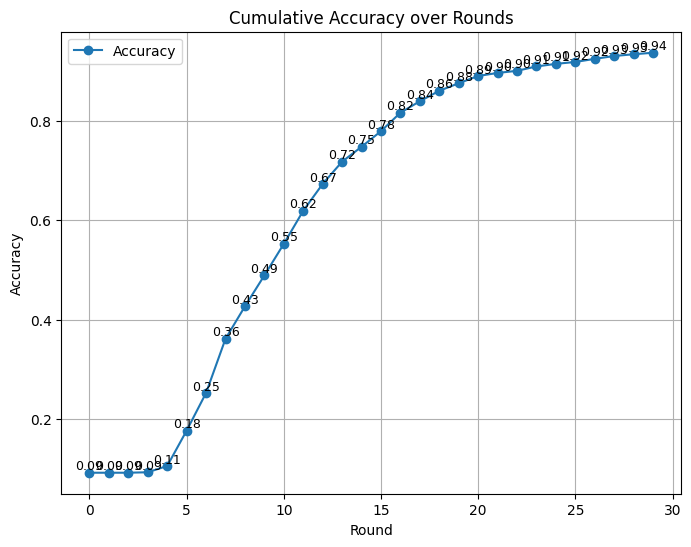

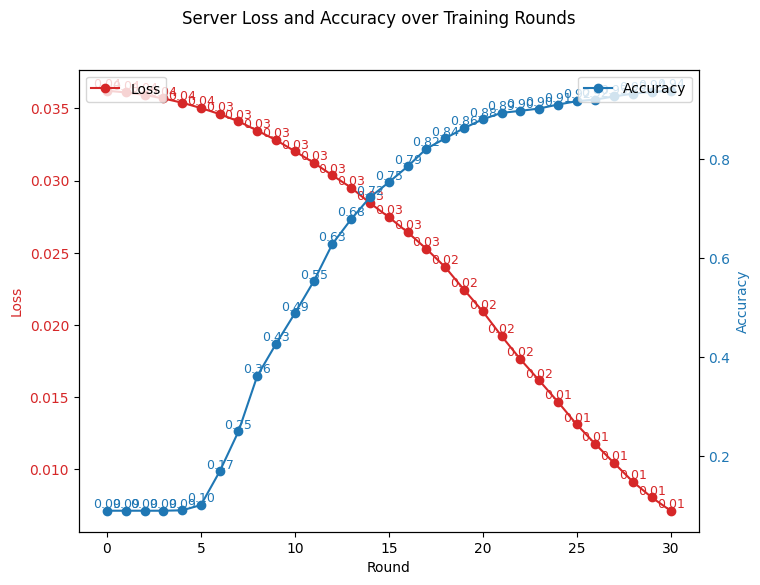

In [ ]:
from flwr.client import ClientApp
from flwr.client.mod import fixedclipping_mod
from flwr.server.strategy import DifferentialPrivacyClientSideFixedClipping

dp_FixClient_strategy = DifferentialPrivacyClientSideFixedClipping(
    strategy,
    noise_multiplier = 0.1 ,
    clipping_norm = 0.1,
    num_sampled_clients = 5,
)

# Add fixedclipping_mod to the client-side mods
Clientapp_1 = ClientApp(
    client_fn=client_fn,
    mods=[fixedclipping_mod,],
)

run_my_sim(
    strategy = dp_FixClient_strategy,
    num_rounds = Num_rounds,
    num_clients = NUM_CLIENTS,
    Clientapp = Clientapp_1 ,
)

### Adaptive Clipping

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[codecarbon INFO @ 09:29:07] [setup] RAM Tracking...
[codecarbon INFO @ 09:29:07] [setup] CPU Tracking...
[codecarbon WARNING @ 09:29:07] No CPU tracking mode found. Falling back on CPU constant mode. 
 Linux OS detected: Please ensure RAPL files exist at \sys\class\powercap\intel-rapl to measure CPU



model is reset.. dont beleve me?.. acc= 0.08116666666666666 
No GPU found.


[codecarbon WARNING @ 09:29:09] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 09:29:09] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 09:29:09] [setup] GPU Tracking...
[codecarbon INFO @ 09:29:09] No GPU found.
[codecarbon INFO @ 09:29:09] >>> Tracker's metadata:
[codecarbon INFO @ 09:29:09]   Platform system: Linux-6.1.85+-x86_64-with-glibc2.35
[codecarbon INFO @ 09:29:09]   Python version: 3.10.12
[codecarbon INFO @ 09:29:09]   CodeCarbon version: 2.8.2
[codecarbon INFO @ 09:29:09]   Available RAM : 12.675 GB
[codecarbon INFO @ 09:29:09]   CPU count: 2
[codecarbon INFO @ 09:29:09]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 09:29:09]   GPU count: None
[codecarbon INFO @ 09:29:09]   GPU model: None
[codecarbon INFO @ 09:29:09] Saving emissions data to file /content/emissions.csv
INFO :      Starting Flower ServerApp, config: num_rounds=30, no round_timeout

DifferentialPrivacyClientSideAdaptiveClipping


(pid=50704) 2024-12-23 09:29:20.463844: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=50704) 2024-12-23 09:29:20.512333: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=50704) 2024-12-23 09:29:20.526412: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=50704) 2024-12-23 09:29:22.815189: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
[codecarbon INFO @ 09:29:24] Energy consumed for RAM : 0.000020 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:29:24] Energy consumed for all CPUs : 0.000177 kWh. Total CPU Power : 

(ClientAppActor pid=50705) [Client 4] get_parameters


[codecarbon INFO @ 09:29:39] Energy consumed for RAM : 0.000040 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:29:39] Energy consumed for all CPUs : 0.000354 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:29:39] 0.000394 kWh of electricity used since the beginning.
INFO :      initial parameters (loss, other metrics): 0.036167249965667725, {'accuracy': 0.0838}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.036167249965667725 / accuracy 0.0838
(ClientAppActor pid=50705) [Client 1, round 1] fit, config: {'server_round': 1, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01}


(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.1000.
(pid=50705) 2024-12-23 09:29:20.472072: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=50705) 2024-12-23 09:29:20.520567: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=50705) 2024-12-23 09:29:20.533065: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=50705) 2024-12-23 09:29:22.841726: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(ClientAppActor pid=50705) [Client 3, round 1] fit, config: {'server_round': 1, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 09:29:54] Energy consumed for RAM : 0.000059 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:29:54] Energy consumed for all CPUs : 0.000531 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:29:54] 0.000591 kWh of electricity used since the beginning.


(ClientAppActor pid=50704) [Client 2, round 1] fit, config: {'server_round': 1, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01}


(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=50704) [Client 5, round 1] fit, config: {'server_round': 1, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.1000. [repeated 2x across cluster]


(ClientAppActor pid=50704) [Client 7, round 1] fit, config: {'server_round': 1, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 09:30:09] Energy consumed for RAM : 0.000079 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:30:09] Energy consumed for all CPUs : 0.000708 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:30:09] 0.000788 kWh of electricity used since the beginning.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.1000. [repeated 2x across cluster]


(ClientAppActor pid=50704) [Client 0, round 1] fit, config: {'server_round': 1, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: central DP noise with 0.0018 stdev added
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.1000.
[codecarbon INFO @ 09:30:24] Energy consumed for RAM : 0.000099 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:30:24] Energy consumed for all CPUs : 0.000885 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:30:24] 0.000984 kWh of electricity used since the beginning.
INFO :      fit progress: (1, 0.036033240604400635, {'accuracy': 0.1115}, 44.148517047000496)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.036033240604400635 / accuracy 0.1115
(ClientAppActor pid=50704) [Client 2] evaluate, config: {'current_round': 1}
(ClientAppActor pid=50705) [Client 9, round 1] fit, config: {'server_round': 1, 'clipping_norm': 0.1, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=50704) [Client 7] evaluate, config: {'current_round': 1} [repeated 4x across cluster]


[codecarbon INFO @ 09:30:39] Energy consumed for RAM : 0.000119 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:30:39] Energy consumed for all CPUs : 0.001062 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:30:39] 0.001181 kWh of electricity used since the beginning.


(ClientAppActor pid=50705) [Client 6] evaluate, config: {'current_round': 1} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.10691666666666666 0.036350210368633264 
(ClientAppActor pid=50705) [Client 2, round 2] fit, config: {'server_round': 2, 'clipping_norm': 0.09032471764221434, 'local_epochs': 1, 'learning rate': 0.01}


(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0903.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0903.


(ClientAppActor pid=50704) [Client 1] evaluate, config: {'current_round': 1}
(ClientAppActor pid=50705) [Client 4, round 2] fit, config: {'server_round': 2, 'clipping_norm': 0.09032471764221434, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 09:30:54] Energy consumed for RAM : 0.000139 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:30:54] Energy consumed for all CPUs : 0.001239 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:30:54] 0.001378 kWh of electricity used since the beginning.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0903.
(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0903.


(ClientAppActor pid=50705) [Client 5, round 2] fit, config: {'server_round': 2, 'clipping_norm': 0.09032471764221434, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0903.
(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0903.


(ClientAppActor pid=50705) [Client 0, round 2] fit, config: {'server_round': 2, 'clipping_norm': 0.09032471764221434, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 09:31:09] Energy consumed for RAM : 0.000158 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:31:09] Energy consumed for all CPUs : 0.001416 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:31:09] 0.001575 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:31:09] 0.001820 g.CO2eq/s mean an estimation of 57.40225895733273 kg.CO2eq/year
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0903.
(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0903.


(ClientAppActor pid=50704) [Client 8, round 2] fit, config: {'server_round': 2, 'clipping_norm': 0.09032471764221434, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0903.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0903.
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: central DP noise with 0.0017 stdev added
[codecarbon INFO @ 09:31:24] Energy consumed for RAM : 0.000178 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:31:24] Energy consumed for all CPUs : 0.001593 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:31:24] 0.001771 kWh of electricity used since the beginning.
INFO :      fit progress: (2, 0.03586390163898468, {'accuracy': 0.1375}, 103.75073986700045)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.03586390163898468 / accuracy 0.1375
(ClientAppActor pid=50704) [Client 2] evaluate, config: {'current_round': 2}
(ClientAppActor pid=50705) [Client 6, round 2] fit, config: {'server_round': 2, 'clipping_norm': 0.09032471764221434, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=50704) [Client 6] evaluate, config: {'current_round': 2} [repeated 4x across cluster]
(ClientAppActor pid=50704) [Client 3] evaluate, config: {'current_round': 2} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
[codecarbon INFO @ 09:31:39] Energy consumed for RAM : 0.000198 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:31:39] Energy consumed for all CPUs : 0.001770 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:31:39] 0.001968 kWh of electricity used since the beginning.


My_weighted_average -0.13274999999999998 0.03618299106756846 
(ClientAppActor pid=50705) [Client 1, round 3] fit, config: {'server_round': 3, 'clipping_norm': 0.08196812576112045, 'local_epochs': 1, 'learning rate': 0.01}


(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0820.
(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0820.


(ClientAppActor pid=50705) [Client 1] evaluate, config: {'current_round': 2}
(ClientAppActor pid=50705) [Client 5, round 3] fit, config: {'server_round': 3, 'clipping_norm': 0.08196812576112045, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0820.
(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0820.
[codecarbon INFO @ 09:31:54] Energy consumed for RAM : 0.000218 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:31:54] Energy consumed for all CPUs : 0.001947 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:31:54] 0.002165 kWh of electricity used since the beginning.


(ClientAppActor pid=50705) [Client 8, round 3] fit, config: {'server_round': 3, 'clipping_norm': 0.08196812576112045, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0820.
(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0820.


(ClientAppActor pid=50705) [Client 3, round 3] fit, config: {'server_round': 3, 'clipping_norm': 0.08196812576112045, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0820.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0820.


(ClientAppActor pid=50705) [Client 0, round 3] fit, config: {'server_round': 3, 'clipping_norm': 0.08196812576112045, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 09:32:09] Energy consumed for RAM : 0.000238 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:32:09] Energy consumed for all CPUs : 0.002125 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:32:09] 0.002362 kWh of electricity used since the beginning.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0820.
(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0820.
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: central DP noise with 0.0015 stdev added
INFO :      fit progress: (3, 0.03565968225002289, {'accuracy': 0.1649}, 159.40177430200038)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.03565968225002289 / accuracy 0.1649
(ClientAppActor pid=50705) [Client 1] evaluate, config: {'current_round': 3}
(ClientAppActor pid=50704) [Client 6, round 3] fit, config: {'server_round': 3, 'clipping_norm': 0.08196812576112045, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 09:32:24] Energy consumed for RAM : 0.000257 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:32:24] Energy consumed for all CPUs : 0.002301 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:32:24] 0.002559 kWh of electricity used since the beginning.


(ClientAppActor pid=50704) [Client 8] evaluate, config: {'current_round': 3} [repeated 5x across cluster]
(ClientAppActor pid=50704) [Client 5] evaluate, config: {'current_round': 3} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.15908333333333333 0.03598225440581639 
(ClientAppActor pid=50705) [Client 1, round 4] fit, config: {'server_round': 4, 'clipping_norm': 0.07503186709892222, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 09:32:39] Energy consumed for RAM : 0.000277 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:32:39] Energy consumed for all CPUs : 0.002478 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:32:39] 0.002756 kWh of electricity used since the beginning.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0750.
(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0750.


(ClientAppActor pid=50705) [Client 3, round 4] fit, config: {'server_round': 4, 'clipping_norm': 0.07503186709892222, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0750.
(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0750.


(ClientAppActor pid=50705) [Client 6, round 4] fit, config: {'server_round': 4, 'clipping_norm': 0.07503186709892222, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0750.
(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0750.
[codecarbon INFO @ 09:32:54] Energy consumed for RAM : 0.000297 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:32:54] Energy consumed for all CPUs : 0.002655 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:32:54] 0.002952 kWh of electricity used since the beginning.


(ClientAppActor pid=50705) [Client 4, round 4] fit, config: {'server_round': 4, 'clipping_norm': 0.07503186709892222, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0750.
(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0750.


(ClientAppActor pid=50705) [Client 9, round 4] fit, config: {'server_round': 4, 'clipping_norm': 0.07503186709892222, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0750.
(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0750.
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: central DP noise with 0.0014 stdev added
[codecarbon INFO @ 09:33:09] Energy consumed for RAM : 0.000317 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:33:09] Energy consumed for all CPUs : 0.002832 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:33:09] 0.003149 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:33:09] 0.001820 g.CO2eq/s mean an estimation of 57.40802467649923 kg.CO2eq/year
INFO :      fit progress: (4, 0.035436453843116764, {'accuracy': 0.2056}, 211.51288086900058)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.035436453843116764 / accuracy 0.2056
(ClientAppActor pid=50704) [Client 1] evaluate, config: {'current_round': 4}
(ClientAppActor pid=50704) [Client 2, round 4] fit, config: {'server_round': 4, 'clipping_norm': 0.07503186709892222, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=50704) [Client 8] evaluate, config: {'current_round': 4} [repeated 4x across cluster]


[codecarbon INFO @ 09:33:24] Energy consumed for RAM : 0.000336 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:33:24] Energy consumed for all CPUs : 0.003010 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:33:24] 0.003346 kWh of electricity used since the beginning.


(ClientAppActor pid=50705) [Client 2] evaluate, config: {'current_round': 4} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.19799999999999998 0.035763363420963284 
(ClientAppActor pid=50704) [Client 2, round 5] fit, config: {'server_round': 5, 'clipping_norm': 0.06827335387509333, 'local_epochs': 1, 'learning rate': 0.01}


(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0683.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0683.


(ClientAppActor pid=50704) [Client 3, round 5] fit, config: {'server_round': 5, 'clipping_norm': 0.06827335387509333, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 09:33:39] Energy consumed for RAM : 0.000356 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:33:39] Energy consumed for all CPUs : 0.003187 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:33:39] 0.003543 kWh of electricity used since the beginning.
(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0683.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0683.


(ClientAppActor pid=50705) [Client 9, round 5] fit, config: {'server_round': 5, 'clipping_norm': 0.06827335387509333, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0683.
(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0683.


(ClientAppActor pid=50705) [Client 5, round 5] fit, config: {'server_round': 5, 'clipping_norm': 0.06827335387509333, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 09:33:54] Energy consumed for RAM : 0.000376 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:33:54] Energy consumed for all CPUs : 0.003364 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:33:54] 0.003740 kWh of electricity used since the beginning.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0683.
(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0683.


(ClientAppActor pid=50705) [Client 6, round 5] fit, config: {'server_round': 5, 'clipping_norm': 0.06827335387509333, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0683.
(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0683.
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: central DP noise with 0.0013 stdev added
INFO :      fit progress: (5, 0.0351822172164917, {'accuracy': 0.276}, 266.6475817589999)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.0351822172164917 / accuracy 0.276


[codecarbon INFO @ 09:34:09] Energy consumed for RAM : 0.000396 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:34:09] Energy consumed for all CPUs : 0.003541 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:34:09] 0.003936 kWh of electricity used since the beginning.


(ClientAppActor pid=50705) [Client 3] evaluate, config: {'current_round': 5}
(ClientAppActor pid=50704) [Client 8, round 5] fit, config: {'server_round': 5, 'clipping_norm': 0.06827335387509333, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=50705) [Client 9] evaluate, config: {'current_round': 5} [repeated 4x across cluster]
(ClientAppActor pid=50705) [Client 5] evaluate, config: {'current_round': 5} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.26825 0.035513210733731586 
(ClientAppActor pid=50704) [Client 1, round 6] fit, config: {'server_round': 6, 'clipping_norm': 0.06154409847906717, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 09:34:24] Energy consumed for RAM : 0.000416 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:34:24] Energy consumed for all CPUs : 0.003718 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:34:24] 0.004133 kWh of electricity used since the beginning.
(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0615.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0615.


(ClientAppActor pid=50704) [Client 0] evaluate, config: {'current_round': 5}
(ClientAppActor pid=50704) [Client 4, round 6] fit, config: {'server_round': 6, 'clipping_norm': 0.06154409847906717, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0615.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0615.


(ClientAppActor pid=50704) [Client 7, round 6] fit, config: {'server_round': 6, 'clipping_norm': 0.06154409847906717, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 09:34:39] Energy consumed for RAM : 0.000435 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:34:39] Energy consumed for all CPUs : 0.003895 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:34:39] 0.004330 kWh of electricity used since the beginning.
(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0615.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0615.


(ClientAppActor pid=50704) [Client 8, round 6] fit, config: {'server_round': 6, 'clipping_norm': 0.06154409847906717, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0615.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0615.


(ClientAppActor pid=50704) [Client 3, round 6] fit, config: {'server_round': 6, 'clipping_norm': 0.06154409847906717, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 09:34:54] Energy consumed for RAM : 0.000455 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:34:54] Energy consumed for all CPUs : 0.004072 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:34:54] 0.004527 kWh of electricity used since the beginning.
(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0615.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0615.
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: central DP noise with 0.0011 stdev added
INFO :      fit progress: (6, 0.034956113386154175, {'accuracy': 0.338}, 321.619542423)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.034956113386154175 / accuracy 0.338
(ClientAppActor pid=50705) [Client 1] evaluate, config: {'current_round': 6}
(ClientAppActor pid=50705) [Client 6, round 6] fit, config: {'server_round': 6, 'clipping_norm': 0.06154409847906717, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 09:35:09] Energy consumed for RAM : 0.000475 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:35:09] Energy consumed for all CPUs : 0.004249 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:35:09] 0.004724 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:35:09] 0.001820 g.CO2eq/s mean an estimation of 57.408218702961456 kg.CO2eq/year


(ClientAppActor pid=50705) [Client 8] evaluate, config: {'current_round': 6} [repeated 4x across cluster]
(ClientAppActor pid=50705) [Client 6] evaluate, config: {'current_round': 6} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.3237499999999999 0.03529015570878982 
(ClientAppActor pid=50705) [Client 1, round 7] fit, config: {'server_round': 7, 'clipping_norm': 0.05558820823612912, 'local_epochs': 1, 'learning rate': 0.01}


(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0556.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0556.
[codecarbon INFO @ 09:35:24] Energy consumed for RAM : 0.000495 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:35:24] Energy consumed for all CPUs : 0.004426 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:35:24] 0.004920 kWh of electricity used since the beginning.


(ClientAppActor pid=50704) [Client 7] evaluate, config: {'current_round': 6}
(ClientAppActor pid=50704) [Client 2, round 7] fit, config: {'server_round': 7, 'clipping_norm': 0.05558820823612912, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0556.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0556.


(ClientAppActor pid=50704) [Client 6, round 7] fit, config: {'server_round': 7, 'clipping_norm': 0.05558820823612912, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0556.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0556.


(ClientAppActor pid=50704) [Client 3, round 7] fit, config: {'server_round': 7, 'clipping_norm': 0.05558820823612912, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 09:35:39] Energy consumed for RAM : 0.000515 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:35:39] Energy consumed for all CPUs : 0.004603 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:35:39] 0.005117 kWh of electricity used since the beginning.
(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0556.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0556.


(ClientAppActor pid=50704) [Client 8, round 7] fit, config: {'server_round': 7, 'clipping_norm': 0.05558820823612912, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0556.
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: central DP noise with 0.0010 stdev added
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0556.
[codecarbon INFO @ 09:35:54] Energy consumed for RAM : 0.000534 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:35:54] Energy consumed for all CPUs : 0.004780 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:35:54] 0.005314 kWh of electricity used since the beginning.
INFO :      fit progress: (7, 0.03469808270931244, {'accuracy': 0.4002}, 375.8677710689999)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.03469808270931244 / accuracy 0.4002
(ClientAppActor pid=50705) [Client 1] evaluate, config: {'current_round': 7}
(ClientAppActor pid=50705) [Client 9, round 7] fit, config: {'server_round': 7, 'clipping_norm': 0.05558820823612912, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=50705) [Client 7] evaluate, config: {'current_round': 7} [repeated 4x across cluster]


[codecarbon INFO @ 09:36:09] Energy consumed for RAM : 0.000554 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:36:09] Energy consumed for all CPUs : 0.004957 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:36:09] 0.005511 kWh of electricity used since the beginning.


(ClientAppActor pid=50705) [Client 2] evaluate, config: {'current_round': 7} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.3865833333333333 0.035036176939805354 
(ClientAppActor pid=50705) [Client 3, round 8] fit, config: {'server_round': 8, 'clipping_norm': 0.05013548093786448, 'local_epochs': 1, 'learning rate': 0.01}


(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0501.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0501.


(ClientAppActor pid=50704) [Client 0] evaluate, config: {'current_round': 7}
(ClientAppActor pid=50705) [Client 5, round 8] fit, config: {'server_round': 8, 'clipping_norm': 0.05013548093786448, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 09:36:24] Energy consumed for RAM : 0.000574 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:36:24] Energy consumed for all CPUs : 0.005134 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:36:24] 0.005708 kWh of electricity used since the beginning.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0501.
(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0501.


(ClientAppActor pid=50705) [Client 7, round 8] fit, config: {'server_round': 8, 'clipping_norm': 0.05013548093786448, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0501. [repeated 2x across cluster]


(ClientAppActor pid=50705) [Client 2, round 8] fit, config: {'server_round': 8, 'clipping_norm': 0.05013548093786448, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0501. [repeated 2x across cluster]
[codecarbon INFO @ 09:36:39] Energy consumed for RAM : 0.000594 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:36:39] Energy consumed for all CPUs : 0.005311 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:36:39] 0.005905 kWh of electricity used since the beginning.


(ClientAppActor pid=50705) [Client 1, round 8] fit, config: {'server_round': 8, 'clipping_norm': 0.05013548093786448, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0501.
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: central DP noise with 0.0009 stdev added
(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0501.
INFO :      fit progress: (8, 0.034456662774085996, {'accuracy': 0.453}, 429.89666012199996)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.034456662774085996 / accuracy 0.453
(ClientAppActor pid=50704) [Client 0] evaluate, config: {'current_round': 8}
(ClientAppActor pid=50704) [Client 8, round 8] fit, config: {'server_round': 8, 'clipping_norm': 0.05013548093786448, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 09:36:54] Energy consumed for RAM : 0.000614 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:36:54] Energy consumed for all CPUs : 0.005488 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:36:54] 0.006101 kWh of electricity used since the beginning.


(ClientAppActor pid=50704) [Client 8] evaluate, config: {'current_round': 8} [repeated 4x across cluster]
(ClientAppActor pid=50705) [Client 3] evaluate, config: {'current_round': 8} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.4421666666666666 0.03479681235551834 
(ClientAppActor pid=50704) [Client 1, round 9] fit, config: {'server_round': 9, 'clipping_norm': 0.04530618311020455, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 09:37:09] Energy consumed for RAM : 0.000633 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:37:09] Energy consumed for all CPUs : 0.005665 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:37:09] 0.006298 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:37:09] 0.001820 g.CO2eq/s mean an estimation of 57.40655290148325 kg.CO2eq/year
(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0453.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0453.


(ClientAppActor pid=50704) [Client 3, round 9] fit, config: {'server_round': 9, 'clipping_norm': 0.04530618311020455, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0453. [repeated 2x across cluster]


(ClientAppActor pid=50704) [Client 6, round 9] fit, config: {'server_round': 9, 'clipping_norm': 0.04530618311020455, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0453.
[codecarbon INFO @ 09:37:24] Energy consumed for RAM : 0.000653 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:37:24] Energy consumed for all CPUs : 0.005842 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:37:24] 0.006495 kWh of electricity used since the beginning.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0453.


(ClientAppActor pid=50704) [Client 2, round 9] fit, config: {'server_round': 9, 'clipping_norm': 0.04530618311020455, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0453.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0453.


(ClientAppActor pid=50704) [Client 8, round 9] fit, config: {'server_round': 9, 'clipping_norm': 0.04530618311020455, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0453.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0453.
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: central DP noise with 0.0008 stdev added
[codecarbon INFO @ 09:37:39] Energy consumed for RAM : 0.000673 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:37:39] Energy consumed for all CPUs : 0.006019 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:37:39] 0.006692 kWh of electricity used since the beginning.
INFO :      fit progress: (9, 0.03421576936244965, {'accuracy': 0.5038}, 483.67873364000025)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.03421576936244965 / accuracy 0.5038
(ClientAppActor pid=50704) [Client 4] evaluate, config: {'current_round': 9}
(ClientAppActor pid=50705) [Client 9, round 9] fit, config: {'server_round': 9, 'clipping_norm': 0.04530618311020455, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=50705) [Client 7] evaluate, config: {'current_round': 9} [repeated 4x across cluster]


[codecarbon INFO @ 09:37:54] Energy consumed for RAM : 0.000693 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:37:54] Energy consumed for all CPUs : 0.006196 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:37:54] 0.006889 kWh of electricity used since the beginning.


(ClientAppActor pid=50705) [Client 2] evaluate, config: {'current_round': 9} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.4926666666666667 0.03456011253595352 
(ClientAppActor pid=50705) [Client 2, round 10] fit, config: {'server_round': 10, 'clipping_norm': 0.041048858755430497, 'local_epochs': 1, 'learning rate': 0.01}


(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0410.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0410.


(ClientAppActor pid=50704) [Client 0] evaluate, config: {'current_round': 9}
(ClientAppActor pid=50704) [Client 6, round 10] fit, config: {'server_round': 10, 'clipping_norm': 0.041048858755430497, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 09:38:09] Energy consumed for RAM : 0.000713 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:38:09] Energy consumed for all CPUs : 0.006373 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:38:09] 0.007086 kWh of electricity used since the beginning.
(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0410.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0410.


(ClientAppActor pid=50704) [Client 7, round 10] fit, config: {'server_round': 10, 'clipping_norm': 0.041048858755430497, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0410.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0410.


(ClientAppActor pid=50704) [Client 1, round 10] fit, config: {'server_round': 10, 'clipping_norm': 0.041048858755430497, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 09:38:24] Energy consumed for RAM : 0.000732 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:38:24] Energy consumed for all CPUs : 0.006550 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:38:24] 0.007283 kWh of electricity used since the beginning.
(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0410.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0410.


(ClientAppActor pid=50704) [Client 9, round 10] fit, config: {'server_round': 10, 'clipping_norm': 0.041048858755430497, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: central DP noise with 0.0008 stdev added
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0410. [repeated 2x across cluster]
INFO :      fit progress: (10, 0.03398259575366974, {'accuracy': 0.5512}, 537.694394913)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.03398259575366974 / accuracy 0.5512


[codecarbon INFO @ 09:38:39] Energy consumed for RAM : 0.000752 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:38:39] Energy consumed for all CPUs : 0.006727 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:38:39] 0.007479 kWh of electricity used since the beginning.


(ClientAppActor pid=50705) [Client 0] evaluate, config: {'current_round': 10}
(ClientAppActor pid=50705) [Client 5, round 10] fit, config: {'server_round': 10, 'clipping_norm': 0.041048858755430497, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=50705) [Client 5] evaluate, config: {'current_round': 10} [repeated 4x across cluster]
(ClientAppActor pid=50704) [Client 1] evaluate, config: {'current_round': 10} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.5370833333333334 0.034330134312311814 


[codecarbon INFO @ 09:38:54] Energy consumed for RAM : 0.000772 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:38:54] Energy consumed for all CPUs : 0.006904 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:38:54] 0.007676 kWh of electricity used since the beginning.


(ClientAppActor pid=50705) [Client 0, round 11] fit, config: {'server_round': 11, 'clipping_norm': 0.036943175008020114, 'local_epochs': 1, 'learning rate': 0.01}


(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0369.
(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0369.


(ClientAppActor pid=50705) [Client 8] evaluate, config: {'current_round': 10}
(ClientAppActor pid=50705) [Client 5, round 11] fit, config: {'server_round': 11, 'clipping_norm': 0.036943175008020114, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0369.
(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0369.


(ClientAppActor pid=50705) [Client 8, round 11] fit, config: {'server_round': 11, 'clipping_norm': 0.036943175008020114, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 09:39:09] Energy consumed for RAM : 0.000792 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:39:09] Energy consumed for all CPUs : 0.007082 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:39:09] 0.007873 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:39:09] 0.001821 g.CO2eq/s mean an estimation of 57.41436485616055 kg.CO2eq/year
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0369.
(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0369.


(ClientAppActor pid=50704) [Client 4, round 11] fit, config: {'server_round': 11, 'clipping_norm': 0.036943175008020114, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0369.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0369.


(ClientAppActor pid=50705) [Client 7, round 11] fit, config: {'server_round': 11, 'clipping_norm': 0.036943175008020114, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 09:39:24] Energy consumed for RAM : 0.000811 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:39:24] Energy consumed for all CPUs : 0.007259 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:39:24] 0.008070 kWh of electricity used since the beginning.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0369.
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: central DP noise with 0.0007 stdev added
(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0369.
INFO :      fit progress: (11, 0.03374303789138794, {'accuracy': 0.583}, 593.7502132300006)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.03374303789138794 / accuracy 0.583
(ClientAppActor pid=50705) [Client 3] evaluate, config: {'current_round': 11}
(ClientAppActor pid=50704) [Client 1, round 11] fit, config: {'server_round': 11, 'clipping_norm': 0.036943175008020114, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 09:39:39] Energy consumed for RAM : 0.000831 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:39:39] Energy consumed for all CPUs : 0.007436 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:39:39] 0.008267 kWh of electricity used since the beginning.


(ClientAppActor pid=50705) [Client 6] evaluate, config: {'current_round': 11} [repeated 4x across cluster]
(ClientAppActor pid=50705) [Client 7] evaluate, config: {'current_round': 11} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.5715 0.034094621419906615 
(ClientAppActor pid=50705) [Client 1, round 12] fit, config: {'server_round': 12, 'clipping_norm': 0.033127323704335604, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 09:39:54] Energy consumed for RAM : 0.000851 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:39:54] Energy consumed for all CPUs : 0.007613 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:39:54] 0.008464 kWh of electricity used since the beginning.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0331.
(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0331.


(ClientAppActor pid=50704) [Client 9] evaluate, config: {'current_round': 11}
(ClientAppActor pid=50705) [Client 6, round 12] fit, config: {'server_round': 12, 'clipping_norm': 0.033127323704335604, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0331.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0331.


(ClientAppActor pid=50705) [Client 8, round 12] fit, config: {'server_round': 12, 'clipping_norm': 0.033127323704335604, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 09:40:09] Energy consumed for RAM : 0.000871 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:40:09] Energy consumed for all CPUs : 0.007790 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:40:09] 0.008661 kWh of electricity used since the beginning.
(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0331.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0331.


(ClientAppActor pid=50704) [Client 0, round 12] fit, config: {'server_round': 12, 'clipping_norm': 0.033127323704335604, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0331.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0331.


(ClientAppActor pid=50704) [Client 3, round 12] fit, config: {'server_round': 12, 'clipping_norm': 0.033127323704335604, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 09:40:24] Energy consumed for RAM : 0.000891 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:40:24] Energy consumed for all CPUs : 0.007967 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:40:24] 0.008858 kWh of electricity used since the beginning.
(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0331.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0331.
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: central DP noise with 0.0006 stdev added
INFO :      fit progress: (12, 0.033531799125671384, {'accuracy': 0.6111}, 649.0866491409997)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.033531799125671384 / accuracy 0.6111
(ClientAppActor pid=50705) [Client 0] evaluate, config: {'current_round': 12}
(ClientAppActor pid=50705) [Client 2, round 12] fit, config: {'server_round': 12, 'clipping_norm': 0.033127323704335604, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=50705) [Client 6] evaluate, config: {'current_round': 12} [repeated 4x across cluster]


[codecarbon INFO @ 09:40:39] Energy consumed for RAM : 0.000910 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:40:39] Energy consumed for all CPUs : 0.008144 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:40:39] 0.009055 kWh of electricity used since the beginning.


(ClientAppActor pid=50704) [Client 3] evaluate, config: {'current_round': 12} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.6023333333333334 0.03388613488276799 
(ClientAppActor pid=50705) [Client 1, round 13] fit, config: {'server_round': 13, 'clipping_norm': 0.03019596298099122, 'local_epochs': 1, 'learning rate': 0.01}


(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0302.
(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0302.


(ClientAppActor pid=50705) [Client 2] evaluate, config: {'current_round': 12}
(ClientAppActor pid=50705) [Client 5, round 13] fit, config: {'server_round': 13, 'clipping_norm': 0.03019596298099122, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 09:40:54] Energy consumed for RAM : 0.000930 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:40:54] Energy consumed for all CPUs : 0.008321 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:40:54] 0.009252 kWh of electricity used since the beginning.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0302.
(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0302.


(ClientAppActor pid=50704) [Client 9, round 13] fit, config: {'server_round': 13, 'clipping_norm': 0.03019596298099122, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0302.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0302.


(ClientAppActor pid=50705) [Client 4, round 13] fit, config: {'server_round': 13, 'clipping_norm': 0.03019596298099122, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 09:41:09] Energy consumed for RAM : 0.000950 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:41:09] Energy consumed for all CPUs : 0.008498 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:41:09] 0.009449 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:41:09] 0.001821 g.CO2eq/s mean an estimation of 57.41139735493219 kg.CO2eq/year
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0302.
(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0302.


(ClientAppActor pid=50704) [Client 7, round 13] fit, config: {'server_round': 13, 'clipping_norm': 0.03019596298099122, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0302.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0302.
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: central DP noise with 0.0006 stdev added
[codecarbon INFO @ 09:41:24] Energy consumed for RAM : 0.000970 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:41:24] Energy consumed for all CPUs : 0.008676 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:41:24] 0.009646 kWh of electricity used since the beginning.
INFO :      fit progress: (13, 0.03334147937297821, {'accuracy': 0.6356}, 705.2266669139999)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.03334147937297821 / accuracy 0.6356
(ClientAppActor pid=50704) [Client 4] evaluate, config: {'current_round': 13}
(ClientAppActor pid=50705) [Client 0, round 13] fit, config: {'server_round': 13, 'clipping_norm': 0.03019596298099122, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=50705) [Client 2] evaluate, config: {'current_round': 13} [repeated 4x across cluster]


[codecarbon INFO @ 09:41:39] Energy consumed for RAM : 0.000990 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:41:39] Energy consumed for all CPUs : 0.008853 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:41:39] 0.009843 kWh of electricity used since the beginning.


(ClientAppActor pid=50704) [Client 3] evaluate, config: {'current_round': 13} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.6263333333333333 0.03369926522175471 
(ClientAppActor pid=50705) [Client 1, round 14] fit, config: {'server_round': 14, 'clipping_norm': 0.027174399802065326, 'local_epochs': 1, 'learning rate': 0.01}


(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0272.
(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0272.


(ClientAppActor pid=50705) [Client 1] evaluate, config: {'current_round': 13}
(ClientAppActor pid=50704) [Client 5, round 14] fit, config: {'server_round': 14, 'clipping_norm': 0.027174399802065326, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 09:41:54] Energy consumed for RAM : 0.001009 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:41:54] Energy consumed for all CPUs : 0.009030 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:41:54] 0.010039 kWh of electricity used since the beginning.
(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0272.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0272.


(ClientAppActor pid=50704) [Client 9, round 14] fit, config: {'server_round': 14, 'clipping_norm': 0.027174399802065326, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0272.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0272.


(ClientAppActor pid=50704) [Client 3, round 14] fit, config: {'server_round': 14, 'clipping_norm': 0.027174399802065326, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0272.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0272.


(ClientAppActor pid=50704) [Client 0, round 14] fit, config: {'server_round': 14, 'clipping_norm': 0.027174399802065326, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 09:42:09] Energy consumed for RAM : 0.001029 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:42:09] Energy consumed for all CPUs : 0.009207 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:42:09] 0.010236 kWh of electricity used since the beginning.
(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0272.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0272.
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: central DP noise with 0.0005 stdev added
INFO :      fit progress: (14, 0.03317163305282593, {'accuracy': 0.6543}, 758.3702399549993)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.03317163305282593 / accuracy 0.6543
(ClientAppActor pid=50704) [Client 2] evaluate, config: {'current_round': 14}
(ClientAppActor pid=50705) [Client 6, round 14] fit, config: {'server_round': 14, 'clipping_norm': 0.027174399802065326, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 09:42:24] Energy consumed for RAM : 0.001049 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:42:24] Energy consumed for all CPUs : 0.009384 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:42:24] 0.010433 kWh of electricity used since the beginning.


(ClientAppActor pid=50704) [Client 5] evaluate, config: {'current_round': 14} [repeated 4x across cluster]
(ClientAppActor pid=50705) [Client 9] evaluate, config: {'current_round': 14} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.6483333333333332 0.03353137429555257 
(ClientAppActor pid=50705) [Client 1, round 15] fit, config: {'server_round': 15, 'clipping_norm': 0.0245523615009079, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 09:42:39] Energy consumed for RAM : 0.001069 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:42:39] Energy consumed for all CPUs : 0.009561 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:42:39] 0.010630 kWh of electricity used since the beginning.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0246.
(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0246.


(ClientAppActor pid=50704) [Client 4, round 15] fit, config: {'server_round': 15, 'clipping_norm': 0.0245523615009079, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0246.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0246.


(ClientAppActor pid=50704) [Client 8, round 15] fit, config: {'server_round': 15, 'clipping_norm': 0.0245523615009079, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 09:42:54] Energy consumed for RAM : 0.001089 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:42:54] Energy consumed for all CPUs : 0.009738 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:42:54] 0.010827 kWh of electricity used since the beginning.
(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0246.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0246.


(ClientAppActor pid=50704) [Client 6, round 15] fit, config: {'server_round': 15, 'clipping_norm': 0.0245523615009079, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0246.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0246.


(ClientAppActor pid=50704) [Client 5, round 15] fit, config: {'server_round': 15, 'clipping_norm': 0.0245523615009079, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0246.
INFO :      aggregate_fit: received 10 results and 0 failures
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0246.
INFO :      aggregate_fit: central DP noise with 0.0005 stdev added
[codecarbon INFO @ 09:43:09] Energy consumed for RAM : 0.001108 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:43:09] Energy consumed for all CPUs : 0.009915 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:43:09] 0.011023 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:43:09] 0.001820 g.CO2eq/s mean an estimation of 57.40984840204587 kg.CO2eq/year
INFO :      fit progress: (15, 0.03298676996231079, {'accuracy': 0.6712}, 813.5009276760002)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.03298676996231079 / accuracy 0.6712
(ClientAppActor pid=50705) [Client 1] evaluate, config: {'current_round': 15}
(ClientAppActor pid=50705) [Client 0, round 15] fit, config: {'server_round': 15, 'clipping_norm': 0.0245523615009079, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=50705) [Client 8] evaluate, config: {'current_round': 15} [repeated 4x across cluster]


[codecarbon INFO @ 09:43:24] Energy consumed for RAM : 0.001128 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:43:24] Energy consumed for all CPUs : 0.010092 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:43:24] 0.011220 kWh of electricity used since the beginning.


(ClientAppActor pid=50705) [Client 3] evaluate, config: {'current_round': 15} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.6688333333333333 0.03334952185551326 
(ClientAppActor pid=50705) [Client 1, round 16] fit, config: {'server_round': 16, 'clipping_norm': 0.022082121476754948, 'local_epochs': 1, 'learning rate': 0.01}


(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0221.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0221.


(ClientAppActor pid=50704) [Client 9] evaluate, config: {'current_round': 15}
(ClientAppActor pid=50704) [Client 7, round 16] fit, config: {'server_round': 16, 'clipping_norm': 0.022082121476754948, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 09:43:39] Energy consumed for RAM : 0.001148 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:43:39] Energy consumed for all CPUs : 0.010269 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:43:39] 0.011417 kWh of electricity used since the beginning.
(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0221.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0221.


(ClientAppActor pid=50705) [Client 9, round 16] fit, config: {'server_round': 16, 'clipping_norm': 0.022082121476754948, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0221.
(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0221.


(ClientAppActor pid=50705) [Client 0, round 16] fit, config: {'server_round': 16, 'clipping_norm': 0.022082121476754948, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 09:43:54] Energy consumed for RAM : 0.001168 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:43:54] Energy consumed for all CPUs : 0.010446 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:43:54] 0.011614 kWh of electricity used since the beginning.
(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0221.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0221.


(ClientAppActor pid=50704) [Client 6, round 16] fit, config: {'server_round': 16, 'clipping_norm': 0.022082121476754948, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0221.
INFO :      aggregate_fit: received 10 results and 0 failures
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0221.
INFO :      aggregate_fit: central DP noise with 0.0004 stdev added
[codecarbon INFO @ 09:44:09] Energy consumed for RAM : 0.001188 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:44:09] Energy consumed for all CPUs : 0.010624 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:44:09] 0.011811 kWh of electricity used since the beginning.
INFO :      fit progress: (16, 0.032823198556900024, {'accuracy': 0.6874}, 871.0371857250002)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.032823198556900024 / accuracy 0.6874
(ClientAppActor pid=50705) [Client 3] evaluate, config: {'current_round': 16}
(ClientAppActor pid=50705) [Client 3, round 16] fit, config: {'server_round': 16, 'clipping_norm': 0.022082121476754948, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=50704) [Client 8] evaluate, config: {'current_round': 16} [repeated 4x across cluster]


[codecarbon INFO @ 09:44:24] Energy consumed for RAM : 0.001207 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:44:24] Energy consumed for all CPUs : 0.010800 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:44:24] 0.012008 kWh of electricity used since the beginning.


(ClientAppActor pid=50704) [Client 5] evaluate, config: {'current_round': 16} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.6856666666666666 0.03318684981266658 
(ClientAppActor pid=50704) [Client 1, round 17] fit, config: {'server_round': 17, 'clipping_norm': 0.01990549507772522, 'local_epochs': 1, 'learning rate': 0.01}


(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0199.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0199.


(ClientAppActor pid=50705) [Client 2] evaluate, config: {'current_round': 16}
(ClientAppActor pid=50705) [Client 5, round 17] fit, config: {'server_round': 17, 'clipping_norm': 0.01990549507772522, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 09:44:39] Energy consumed for RAM : 0.001227 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:44:39] Energy consumed for all CPUs : 0.010978 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:44:39] 0.012205 kWh of electricity used since the beginning.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0199.
(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0199.


(ClientAppActor pid=50705) [Client 6, round 17] fit, config: {'server_round': 17, 'clipping_norm': 0.01990549507772522, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0199.
(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0199.


(ClientAppActor pid=50705) [Client 8, round 17] fit, config: {'server_round': 17, 'clipping_norm': 0.01990549507772522, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 09:44:54] Energy consumed for RAM : 0.001247 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:44:54] Energy consumed for all CPUs : 0.011155 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:44:54] 0.012402 kWh of electricity used since the beginning.
(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0199.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0199.


(ClientAppActor pid=50705) [Client 4, round 17] fit, config: {'server_round': 17, 'clipping_norm': 0.01990549507772522, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0199.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0199.
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: central DP noise with 0.0004 stdev added
INFO :      fit progress: (17, 0.032678117609024046, {'accuracy': 0.6994}, 927.7204916029996)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.032678117609024046 / accuracy 0.6994


[codecarbon INFO @ 09:45:09] Energy consumed for RAM : 0.001267 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:45:09] Energy consumed for all CPUs : 0.011332 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:45:09] 0.012599 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:45:09] 0.001821 g.CO2eq/s mean an estimation of 57.41146308152098 kg.CO2eq/year


(ClientAppActor pid=50705) [Client 1] evaluate, config: {'current_round': 17}
(ClientAppActor pid=50704) [Client 9, round 17] fit, config: {'server_round': 17, 'clipping_norm': 0.01990549507772522, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=50704) [Client 6] evaluate, config: {'current_round': 17} [repeated 4x across cluster]
(ClientAppActor pid=50705) [Client 8] evaluate, config: {'current_round': 17} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.6976666666666665 0.03304322224855423 


[codecarbon INFO @ 09:45:24] Energy consumed for RAM : 0.001287 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:45:24] Energy consumed for all CPUs : 0.011509 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:45:24] 0.012796 kWh of electricity used since the beginning.


(ClientAppActor pid=50704) [Client 5, round 18] fit, config: {'server_round': 18, 'clipping_norm': 0.017950732896483315, 'local_epochs': 1, 'learning rate': 0.01}


(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0180.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0180.


(ClientAppActor pid=50704) [Client 6, round 18] fit, config: {'server_round': 18, 'clipping_norm': 0.017950732896483315, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0180.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0180.


(ClientAppActor pid=50704) [Client 9, round 18] fit, config: {'server_round': 18, 'clipping_norm': 0.017950732896483315, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 09:45:39] Energy consumed for RAM : 0.001306 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:45:39] Energy consumed for all CPUs : 0.011686 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:45:39] 0.012993 kWh of electricity used since the beginning.
(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0180.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0180.


(ClientAppActor pid=50704) [Client 7, round 18] fit, config: {'server_round': 18, 'clipping_norm': 0.017950732896483315, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0180.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0180.


(ClientAppActor pid=50704) [Client 0, round 18] fit, config: {'server_round': 18, 'clipping_norm': 0.017950732896483315, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 09:45:54] Energy consumed for RAM : 0.001326 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:45:54] Energy consumed for all CPUs : 0.011863 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:45:54] 0.013189 kWh of electricity used since the beginning.
(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0180.
INFO :      aggregate_fit: received 10 results and 0 failures
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0180.
INFO :      aggregate_fit: central DP noise with 0.0003 stdev added
INFO :      fit progress: (18, 0.03254570105075836, {'accuracy': 0.7104}, 980.9706077350011)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.03254570105075836 / accuracy 0.7104
(ClientAppActor pid=50705) [Client 0] evaluate, config: {'current_round': 18}
(ClientAppActor pid=50705) [Client 4, round 18] fit, config: {'server_round': 18, 'clipping_norm': 0.017950732896483315, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 09:46:09] Energy consumed for RAM : 0.001346 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:46:09] Energy consumed for all CPUs : 0.012040 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:46:09] 0.013386 kWh of electricity used since the beginning.


(ClientAppActor pid=50704) [Client 8] evaluate, config: {'current_round': 18} [repeated 4x across cluster]
(ClientAppActor pid=50704) [Client 7] evaluate, config: {'current_round': 18} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.7105833333333332 0.03291232419013977 
(ClientAppActor pid=50704) [Client 3, round 19] fit, config: {'server_round': 19, 'clipping_norm': 0.016175220378000982, 'local_epochs': 1, 'learning rate': 0.01}


(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0162.
[codecarbon INFO @ 09:46:24] Energy consumed for RAM : 0.001366 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:46:24] Energy consumed for all CPUs : 0.012217 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:46:24] 0.013583 kWh of electricity used since the beginning.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0162.


(ClientAppActor pid=50705) [Client 2] evaluate, config: {'current_round': 18}
(ClientAppActor pid=50704) [Client 4, round 19] fit, config: {'server_round': 19, 'clipping_norm': 0.016175220378000982, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0162.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0162.


(ClientAppActor pid=50704) [Client 7, round 19] fit, config: {'server_round': 19, 'clipping_norm': 0.016175220378000982, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0162.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0162.


(ClientAppActor pid=50704) [Client 2, round 19] fit, config: {'server_round': 19, 'clipping_norm': 0.016175220378000982, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 09:46:39] Energy consumed for RAM : 0.001386 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:46:39] Energy consumed for all CPUs : 0.012394 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:46:39] 0.013780 kWh of electricity used since the beginning.
(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0162.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0162.


(ClientAppActor pid=50704) [Client 8, round 19] fit, config: {'server_round': 19, 'clipping_norm': 0.016175220378000982, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0162. [repeated 2x across cluster]
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: central DP noise with 0.0003 stdev added
[codecarbon INFO @ 09:46:54] Energy consumed for RAM : 0.001405 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:46:54] Energy consumed for all CPUs : 0.012571 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:46:54] 0.013976 kWh of electricity used since the beginning.
INFO :      fit progress: (19, 0.032419706177711484, {'accuracy': 0.7199}, 1035.2457599660002)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.032419706177711484 / accuracy 0.7199
(ClientAppActor pid=50704) [Client 2] evaluate, config: {'current_round': 19}
(ClientAppActor pid=50705) [Client 1, round 19] fit, config: {'server_round': 19, 'clipping_norm': 0.016175220378000982, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=50704) [Client 5] evaluate, config: {'current_round': 19} [repeated 4x across cluster]


[codecarbon INFO @ 09:47:09] Energy consumed for RAM : 0.001425 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:47:09] Energy consumed for all CPUs : 0.012748 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:47:09] 0.014173 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:47:09] 0.001820 g.CO2eq/s mean an estimation of 57.40036794926942 kg.CO2eq/year


(ClientAppActor pid=50704) [Client 1] evaluate, config: {'current_round': 19} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.7204166666666668 0.032787910441557565 
(ClientAppActor pid=50704) [Client 3, round 20] fit, config: {'server_round': 20, 'clipping_norm': 0.01468943403549687, 'local_epochs': 1, 'learning rate': 0.01}


(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0147.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0147.


(ClientAppActor pid=50705) [Client 7] evaluate, config: {'current_round': 19}
(ClientAppActor pid=50704) [Client 5, round 20] fit, config: {'server_round': 20, 'clipping_norm': 0.01468943403549687, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 09:47:24] Energy consumed for RAM : 0.001445 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:47:24] Energy consumed for all CPUs : 0.012925 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:47:24] 0.014370 kWh of electricity used since the beginning.
(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0147.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0147.


(ClientAppActor pid=50704) [Client 8, round 20] fit, config: {'server_round': 20, 'clipping_norm': 0.01468943403549687, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0147.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0147.


(ClientAppActor pid=50704) [Client 0, round 20] fit, config: {'server_round': 20, 'clipping_norm': 0.01468943403549687, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0147.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0147.
[codecarbon INFO @ 09:47:39] Energy consumed for RAM : 0.001465 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:47:39] Energy consumed for all CPUs : 0.013102 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:47:39] 0.014567 kWh of electricity used since the beginning.


(ClientAppActor pid=50704) [Client 2, round 20] fit, config: {'server_round': 20, 'clipping_norm': 0.01468943403549687, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0147.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0147.
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: central DP noise with 0.0003 stdev added
INFO :      fit progress: (20, 0.03230497295856476, {'accuracy': 0.7274}, 1089.8346619859994)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.03230497295856476 / accuracy 0.7274
(ClientAppActor pid=50704) [Client 1] evaluate, config: {'current_round': 20}
(ClientAppActor pid=50705) [Client 4, round 20] fit, config: {'server_round': 20, 'clipping_norm': 0.01468943403549687, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 09:47:54] Energy consumed for RAM : 0.001485 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:47:54] Energy consumed for all CPUs : 0.013280 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:47:54] 0.014764 kWh of electricity used since the beginning.


(ClientAppActor pid=50705) [Client 5] evaluate, config: {'current_round': 20} [repeated 4x across cluster]
(ClientAppActor pid=50705) [Client 9] evaluate, config: {'current_round': 20} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.7267499999999999 0.03267449394861857 
(ClientAppActor pid=50704) [Client 1, round 21] fit, config: {'server_round': 21, 'clipping_norm': 0.013298039491628262, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 09:48:09] Energy consumed for RAM : 0.001504 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:48:09] Energy consumed for all CPUs : 0.013457 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:48:09] 0.014961 kWh of electricity used since the beginning.
(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0133.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0133.


(ClientAppActor pid=50704) [Client 7] evaluate, config: {'current_round': 20}
(ClientAppActor pid=50705) [Client 3, round 21] fit, config: {'server_round': 21, 'clipping_norm': 0.013298039491628262, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0133.
(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0133.


(ClientAppActor pid=50705) [Client 5, round 21] fit, config: {'server_round': 21, 'clipping_norm': 0.013298039491628262, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 09:48:24] Energy consumed for RAM : 0.001524 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:48:24] Energy consumed for all CPUs : 0.013634 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:48:24] 0.015158 kWh of electricity used since the beginning.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0133.
(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0133.


(ClientAppActor pid=50705) [Client 4, round 21] fit, config: {'server_round': 21, 'clipping_norm': 0.013298039491628262, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0133. [repeated 2x across cluster]


(ClientAppActor pid=50705) [Client 9, round 21] fit, config: {'server_round': 21, 'clipping_norm': 0.013298039491628262, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0133.
[codecarbon INFO @ 09:48:39] Energy consumed for RAM : 0.001544 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:48:39] Energy consumed for all CPUs : 0.013810 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:48:39] 0.015354 kWh of electricity used since the beginning.
(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0133.
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: central DP noise with 0.0002 stdev added
INFO :      fit progress: (21, 0.03220400114059448, {'accuracy': 0.7338}, 1145.1762366789999)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.03220400114059448 / accuracy 0.7338
(ClientAppActor pid=50705) [Client 1] evaluate, config: {'current_round': 21}
(ClientAppActor pid=50704) [Client 6, round 21] fit, config: {'server_round': 21, 'clipping_norm': 0.013298039491628262, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 09:48:54] Energy consumed for RAM : 0.001564 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:48:54] Energy consumed for all CPUs : 0.013988 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:48:54] 0.015551 kWh of electricity used since the beginning.


(ClientAppActor pid=50705) [Client 5] evaluate, config: {'current_round': 21} [repeated 4x across cluster]
(ClientAppActor pid=50704) [Client 8] evaluate, config: {'current_round': 21} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.7336666666666667 0.03257481670379638 
(ClientAppActor pid=50704) [Client 3, round 22] fit, config: {'server_round': 22, 'clipping_norm': 0.012114432661634998, 'local_epochs': 1, 'learning rate': 0.01}


(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0121.
[codecarbon INFO @ 09:49:09] Energy consumed for RAM : 0.001583 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:49:09] Energy consumed for all CPUs : 0.014165 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:49:09] 0.015748 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:49:09] 0.001820 g.CO2eq/s mean an estimation of 57.409746987344604 kg.CO2eq/year
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0121.


(ClientAppActor pid=50705) [Client 4] evaluate, config: {'current_round': 21}
(ClientAppActor pid=50704) [Client 4, round 22] fit, config: {'server_round': 22, 'clipping_norm': 0.012114432661634998, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0121.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0121.


(ClientAppActor pid=50704) [Client 6, round 22] fit, config: {'server_round': 22, 'clipping_norm': 0.012114432661634998, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0121. [repeated 2x across cluster]


(ClientAppActor pid=50704) [Client 1, round 22] fit, config: {'server_round': 22, 'clipping_norm': 0.012114432661634998, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 09:49:24] Energy consumed for RAM : 0.001603 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:49:24] Energy consumed for all CPUs : 0.014342 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:49:24] 0.015945 kWh of electricity used since the beginning.
(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0121.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0121.


(ClientAppActor pid=50705) [Client 0, round 22] fit, config: {'server_round': 22, 'clipping_norm': 0.012114432661634998, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0121.
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: central DP noise with 0.0002 stdev added
(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0121.
[codecarbon INFO @ 09:49:39] Energy consumed for RAM : 0.001623 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:49:39] Energy consumed for all CPUs : 0.014519 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:49:39] 0.016142 kWh of electricity used since the beginning.
INFO :      fit progress: (22, 0.03210822335481644, {'accuracy': 0.7405}, 1201.4894082479996)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.03210822335481644 / accuracy 0.7405
(ClientAppActor pid=50704) [Client 0] evaluate, config: {'current_round': 22}
(ClientAppActor pid=50704) [Client 7, round 22] fit, config: {'server_round': 22, 'clipping_norm': 0.012114432661634998, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=50705) [Client 8] evaluate, config: {'current_round': 22} [repeated 5x across cluster]


[codecarbon INFO @ 09:49:54] Energy consumed for RAM : 0.001643 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:49:54] Energy consumed for all CPUs : 0.014696 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:49:54] 0.016339 kWh of electricity used since the beginning.


(ClientAppActor pid=50704) [Client 6] evaluate, config: {'current_round': 22} [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.7391666666666667 0.032479548116525016 
(ClientAppActor pid=50705) [Client 0, round 23] fit, config: {'server_round': 23, 'clipping_norm': 0.010860401718245122, 'local_epochs': 1, 'learning rate': 0.01}


(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0109.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0109.


(ClientAppActor pid=50705) [Client 3] evaluate, config: {'current_round': 22}
(ClientAppActor pid=50705) [Client 4, round 23] fit, config: {'server_round': 23, 'clipping_norm': 0.010860401718245122, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 09:50:09] Energy consumed for RAM : 0.001663 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:50:09] Energy consumed for all CPUs : 0.014873 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:50:09] 0.016536 kWh of electricity used since the beginning.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0109.
(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0109.


(ClientAppActor pid=50705) [Client 5, round 23] fit, config: {'server_round': 23, 'clipping_norm': 0.010860401718245122, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0109. [repeated 2x across cluster]


(ClientAppActor pid=50705) [Client 6, round 23] fit, config: {'server_round': 23, 'clipping_norm': 0.010860401718245122, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=50705) [Client 8, round 23] fit, config: {'server_round': 23, 'clipping_norm': 0.010860401718245122, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0109. [repeated 2x across cluster]
[codecarbon INFO @ 09:50:24] Energy consumed for RAM : 0.001683 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:50:24] Energy consumed for all CPUs : 0.015051 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:50:24] 0.016733 kWh of electricity used since the beginning.
(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0109. [repeated 2x across cluster]
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: central DP noise with 0.0002 stdev added
INFO :      fit progress: (23, 0.032022287499904635, {'accuracy': 0.7469}, 1254.4502652479996)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.032022287499904635 / accuracy 0.7469
(ClientAppActor pid=50704) [Client 1] evaluate, config: {'current_round': 23}
(ClientAppActor pid=50704) [Client 2, round 23] fit, config: {'server_round': 23, 'clipping_norm': 0.010860401718245122, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 09:50:39] Energy consumed for RAM : 0.001702 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:50:39] Energy consumed for all CPUs : 0.015228 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:50:39] 0.016930 kWh of electricity used since the beginning.


(ClientAppActor pid=50704) [Client 8] evaluate, config: {'current_round': 23} [repeated 4x across cluster]
(ClientAppActor pid=50704) [Client 4] evaluate, config: {'current_round': 23} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.7441666666666668 0.03239476127425829 
(ClientAppActor pid=50705) [Client 0, round 24] fit, config: {'server_round': 24, 'clipping_norm': 0.009768737917736163, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 09:50:54] Energy consumed for RAM : 0.001722 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:50:54] Energy consumed for all CPUs : 0.015405 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:50:54] 0.017127 kWh of electricity used since the beginning.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0098.
(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0098.


(ClientAppActor pid=50705) [Client 0] evaluate, config: {'current_round': 23}
(ClientAppActor pid=50704) [Client 4, round 24] fit, config: {'server_round': 24, 'clipping_norm': 0.009768737917736163, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0098.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0098.


(ClientAppActor pid=50704) [Client 6, round 24] fit, config: {'server_round': 24, 'clipping_norm': 0.009768737917736163, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 09:51:09] Energy consumed for RAM : 0.001742 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:51:09] Energy consumed for all CPUs : 0.015582 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:51:09] 0.017324 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:51:09] 0.001821 g.CO2eq/s mean an estimation of 57.41229850573871 kg.CO2eq/year
(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0098.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0098.


(ClientAppActor pid=50704) [Client 7, round 24] fit, config: {'server_round': 24, 'clipping_norm': 0.009768737917736163, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0098.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0098.


(ClientAppActor pid=50704) [Client 5, round 24] fit, config: {'server_round': 24, 'clipping_norm': 0.009768737917736163, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 09:51:24] Energy consumed for RAM : 0.001762 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:51:24] Energy consumed for all CPUs : 0.015759 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:51:24] 0.017521 kWh of electricity used since the beginning.
(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0098.
INFO :      aggregate_fit: received 10 results and 0 failures
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0098.
INFO :      aggregate_fit: central DP noise with 0.0002 stdev added
INFO :      fit progress: (24, 0.03194051516056061, {'accuracy': 0.7506}, 1310.3018598379995)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.03194051516056061 / accuracy 0.7506
(ClientAppActor pid=50704) [Client 3] evaluate, config: {'current_round': 24}
(ClientAppActor pid=50705) [Client 9, round 24] fit, config: {'server_round': 24, 'clipping_norm': 0.009768737917736163, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=50704) [Client 7] evaluate, config: {'current_round': 24} [repeated 4x across cluster]


[codecarbon INFO @ 09:51:39] Energy consumed for RAM : 0.001782 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:51:39] Energy consumed for all CPUs : 0.015936 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:51:39] 0.017718 kWh of electricity used since the beginning.


(ClientAppActor pid=50704) [Client 1] evaluate, config: {'current_round': 24} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.7482500000000001 0.032314062466224036 
(ClientAppActor pid=50704) [Client 2, round 25] fit, config: {'server_round': 25, 'clipping_norm': 0.008884943849027913, 'local_epochs': 1, 'learning rate': 0.01}


(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0089.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0089.


(ClientAppActor pid=50705) [Client 9] evaluate, config: {'current_round': 24}
(ClientAppActor pid=50704) [Client 3, round 25] fit, config: {'server_round': 25, 'clipping_norm': 0.008884943849027913, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 09:51:54] Energy consumed for RAM : 0.001801 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:51:54] Energy consumed for all CPUs : 0.016113 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:51:54] 0.017915 kWh of electricity used since the beginning.
(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0089.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0089.


(ClientAppActor pid=50704) [Client 8, round 25] fit, config: {'server_round': 25, 'clipping_norm': 0.008884943849027913, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0089.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0089.


(ClientAppActor pid=50704) [Client 5, round 25] fit, config: {'server_round': 25, 'clipping_norm': 0.008884943849027913, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 09:52:09] Energy consumed for RAM : 0.001821 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:52:09] Energy consumed for all CPUs : 0.016290 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:52:09] 0.018111 kWh of electricity used since the beginning.
(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0089.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0089.


(ClientAppActor pid=50704) [Client 0, round 25] fit, config: {'server_round': 25, 'clipping_norm': 0.008884943849027913, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0089.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0089.
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: central DP noise with 0.0002 stdev added
[codecarbon INFO @ 09:52:24] Energy consumed for RAM : 0.001841 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:52:24] Energy consumed for all CPUs : 0.016467 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:52:24] 0.018308 kWh of electricity used since the beginning.
INFO :      fit progress: (25, 0.03186941666603088, {'accuracy': 0.7543}, 1365.8430966669994)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.03186941666603088 / accuracy 0.7543
(ClientAppActor pid=50705) [Client 0] evaluate, config: {'current_round': 25}
(ClientAppActor pid=50705) [Client 7, round 25] fit, config: {'server_round': 25, 'clipping_norm': 0.008884943849027913, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=50705) [Client 5] evaluate, config: {'current_round': 25} [repeated 4x across cluster]
(ClientAppActor pid=50705) [Client 6] evaluate, config: {'current_round': 25} [repeated 4x across cluster]


[codecarbon INFO @ 09:52:39] Energy consumed for RAM : 0.001861 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:52:39] Energy consumed for all CPUs : 0.016644 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:52:39] 0.018505 kWh of electricity used since the beginning.
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.7535833333333332 0.03224372549851735 
(ClientAppActor pid=50704) [Client 1, round 26] fit, config: {'server_round': 26, 'clipping_norm': 0.00806665463054121, 'local_epochs': 1, 'learning rate': 0.01}


(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0081.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0081.


(ClientAppActor pid=50704) [Client 4] evaluate, config: {'current_round': 25}
(ClientAppActor pid=50704) [Client 3, round 26] fit, config: {'server_round': 26, 'clipping_norm': 0.00806665463054121, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0081.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0081.
[codecarbon INFO @ 09:52:54] Energy consumed for RAM : 0.001881 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:52:54] Energy consumed for all CPUs : 0.016822 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:52:54] 0.018702 kWh of electricity used since the beginning.


(ClientAppActor pid=50704) [Client 8, round 26] fit, config: {'server_round': 26, 'clipping_norm': 0.00806665463054121, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0081.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0081.


(ClientAppActor pid=50705) [Client 5, round 26] fit, config: {'server_round': 26, 'clipping_norm': 0.00806665463054121, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0081.
(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0081.


(ClientAppActor pid=50705) [Client 6, round 26] fit, config: {'server_round': 26, 'clipping_norm': 0.00806665463054121, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 09:53:09] Energy consumed for RAM : 0.001900 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:53:09] Energy consumed for all CPUs : 0.016999 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:53:09] 0.018899 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:53:09] 0.001820 g.CO2eq/s mean an estimation of 57.411142424999206 kg.CO2eq/year
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0081.
INFO :      aggregate_fit: received 10 results and 0 failures
(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0081.
INFO :      aggregate_fit: central DP noise with 0.0001 stdev added
INFO :      fit progress: (26, 0.031803273665905, {'accuracy': 0.7585}, 1418.3543694070004)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.031803273665905 / accuracy 0.7585
(ClientAppActor pid=50705) [Client 1] evaluate, config: {'current_round': 26}
(ClientAppActor pid=50704) [Client 4, round 26] fit, config: {'server_round': 26, 'clipping_norm': 0.00806665463054121, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 09:53:24] Energy consumed for RAM : 0.001920 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:53:24] Energy consumed for all CPUs : 0.017176 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:53:24] 0.019096 kWh of electricity used since the beginning.


(ClientAppActor pid=50705) [Client 8] evaluate, config: {'current_round': 26} [repeated 4x across cluster]
(ClientAppActor pid=50704) [Client 7] evaluate, config: {'current_round': 26} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.7570000000000001 0.03217835614085197 
(ClientAppActor pid=50704) [Client 1, round 27] fit, config: {'server_round': 27, 'clipping_norm': 0.007280765522534428, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 09:53:39] Energy consumed for RAM : 0.001940 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:53:39] Energy consumed for all CPUs : 0.017353 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:53:39] 0.019293 kWh of electricity used since the beginning.
(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0073.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0073.


(ClientAppActor pid=50704) [Client 3, round 27] fit, config: {'server_round': 27, 'clipping_norm': 0.007280765522534428, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0073.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0073.


(ClientAppActor pid=50704) [Client 6, round 27] fit, config: {'server_round': 27, 'clipping_norm': 0.007280765522534428, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 09:53:54] Energy consumed for RAM : 0.001960 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:53:54] Energy consumed for all CPUs : 0.017530 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:53:54] 0.019490 kWh of electricity used since the beginning.
(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0073.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0073.


(ClientAppActor pid=50704) [Client 0, round 27] fit, config: {'server_round': 27, 'clipping_norm': 0.007280765522534428, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0073.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0073.


(ClientAppActor pid=50704) [Client 7, round 27] fit, config: {'server_round': 27, 'clipping_norm': 0.007280765522534428, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0073.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0073.
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: central DP noise with 0.0001 stdev added
[codecarbon INFO @ 09:54:09] Energy consumed for RAM : 0.001980 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:54:09] Energy consumed for all CPUs : 0.017707 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:54:09] 0.019686 kWh of electricity used since the beginning.
INFO :      fit progress: (27, 0.03174344704151154, {'accuracy': 0.7618}, 1473.181350146001)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.03174344704151154 / accuracy 0.7618
(ClientAppActor pid=50704) [Client 1] evaluate, config: {'current_round': 27}
(ClientAppActor pid=50705) [Client 5, round 27] fit, config: {'server_round': 27, 'clipping_norm': 0.007280765522534428, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=50705) [Client 7] evaluate, config: {'current_round': 27} [repeated 4x across cluster]


[codecarbon INFO @ 09:54:24] Energy consumed for RAM : 0.001999 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:54:24] Energy consumed for all CPUs : 0.017884 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:54:24] 0.019883 kWh of electricity used since the beginning.


(ClientAppActor pid=50705) [Client 2] evaluate, config: {'current_round': 27} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.7592499999999999 0.03211965758601824 
(ClientAppActor pid=50704) [Client 2, round 28] fit, config: {'server_round': 28, 'clipping_norm': 0.006547136244584304, 'local_epochs': 1, 'learning rate': 0.01}


(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0065.


(ClientAppActor pid=50704) [Client 6] evaluate, config: {'current_round': 27}
(ClientAppActor pid=50704) [Client 5, round 28] fit, config: {'server_round': 28, 'clipping_norm': 0.006547136244584304, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0065.
[codecarbon INFO @ 09:54:39] Energy consumed for RAM : 0.002019 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:54:39] Energy consumed for all CPUs : 0.018061 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:54:39] 0.020080 kWh of electricity used since the beginning.
(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0065.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0065.


(ClientAppActor pid=50704) [Client 8, round 28] fit, config: {'server_round': 28, 'clipping_norm': 0.006547136244584304, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0065.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0065.


(ClientAppActor pid=50704) [Client 3, round 28] fit, config: {'server_round': 28, 'clipping_norm': 0.006547136244584304, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 09:54:54] Energy consumed for RAM : 0.002039 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:54:54] Energy consumed for all CPUs : 0.018238 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:54:54] 0.020277 kWh of electricity used since the beginning.
(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0065.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0065.


(ClientAppActor pid=50704) [Client 1, round 28] fit, config: {'server_round': 28, 'clipping_norm': 0.006547136244584304, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0065.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0065.
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: central DP noise with 0.0001 stdev added
[codecarbon INFO @ 09:55:09] Energy consumed for RAM : 0.002059 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:55:09] Energy consumed for all CPUs : 0.018415 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:55:09] 0.020474 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:55:09] 0.001820 g.CO2eq/s mean an estimation of 57.40586726299509 kg.CO2eq/year
INFO :      fit progress: (28, 0.03169493310451508, {'accuracy': 0.7639}, 1528.5199696570007)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.03169493310451508 / accuracy 0.7639
(ClientAppActor pid=50705) [Client 1] evaluate, config: {'current_round': 28}
(ClientAppActor pid=50705) [Client 7, round 28] fit, config: {'server_round': 28, 'clipping_norm': 0.006547136244584304, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=50704) [Client 6] evaluate, config: {'current_round': 28} [repeated 4x across cluster]
(ClientAppActor pid=50704) [Client 5] evaluate, config: {'current_round': 28} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.7613333333333333 0.032071502347787224 


[codecarbon INFO @ 09:55:24] Energy consumed for RAM : 0.002078 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:55:24] Energy consumed for all CPUs : 0.018592 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:55:24] 0.020671 kWh of electricity used since the beginning.


(ClientAppActor pid=50704) [Client 3, round 29] fit, config: {'server_round': 29, 'clipping_norm': 0.00588916658433927, 'local_epochs': 1, 'learning rate': 0.01}


(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0059.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0059.


(ClientAppActor pid=50705) [Client 9] evaluate, config: {'current_round': 28}
(ClientAppActor pid=50705) [Client 5, round 29] fit, config: {'server_round': 29, 'clipping_norm': 0.00588916658433927, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0059.
(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0059.
[codecarbon INFO @ 09:55:39] Energy consumed for RAM : 0.002098 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:55:39] Energy consumed for all CPUs : 0.018769 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:55:39] 0.020867 kWh of electricity used since the beginning.


(ClientAppActor pid=50704) [Client 9, round 29] fit, config: {'server_round': 29, 'clipping_norm': 0.00588916658433927, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0059.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0059.


(ClientAppActor pid=50704) [Client 1, round 29] fit, config: {'server_round': 29, 'clipping_norm': 0.00588916658433927, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0059.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0059.
[codecarbon INFO @ 09:55:54] Energy consumed for RAM : 0.002118 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:55:54] Energy consumed for all CPUs : 0.018946 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:55:54] 0.021064 kWh of electricity used since the beginning.


(ClientAppActor pid=50704) [Client 8, round 29] fit, config: {'server_round': 29, 'clipping_norm': 0.00588916658433927, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0059.
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: central DP noise with 0.0001 stdev added
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0059.
INFO :      fit progress: (29, 0.03164847497940063, {'accuracy': 0.7657}, 1584.4208973430004)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.03164847497940063 / accuracy 0.7657
(ClientAppActor pid=50704) [Client 2] evaluate, config: {'current_round': 29}
(ClientAppActor pid=50705) [Client 6, round 29] fit, config: {'server_round': 29, 'clipping_norm': 0.00588916658433927, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 09:56:09] Energy consumed for RAM : 0.002138 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:56:09] Energy consumed for all CPUs : 0.019123 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:56:09] 0.021261 kWh of electricity used since the beginning.


(ClientAppActor pid=50705) [Client 6] evaluate, config: {'current_round': 29} [repeated 4x across cluster]
(ClientAppActor pid=50705) [Client 7] evaluate, config: {'current_round': 29} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.7635833333333333 0.032025215685367585 
(ClientAppActor pid=50704) [Client 0, round 30] fit, config: {'server_round': 30, 'clipping_norm': 0.005322048303876521, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 09:56:24] Energy consumed for RAM : 0.002158 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:56:24] Energy consumed for all CPUs : 0.019300 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:56:24] 0.021458 kWh of electricity used since the beginning.
(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0053.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0053.


(ClientAppActor pid=50704) [Client 1] evaluate, config: {'current_round': 29}
(ClientAppActor pid=50705) [Client 6, round 30] fit, config: {'server_round': 30, 'clipping_norm': 0.005322048303876521, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0053.
(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0053.


(ClientAppActor pid=50705) [Client 8, round 30] fit, config: {'server_round': 30, 'clipping_norm': 0.005322048303876521, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 09:56:39] Energy consumed for RAM : 0.002177 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:56:39] Energy consumed for all CPUs : 0.019477 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:56:39] 0.021655 kWh of electricity used since the beginning.
(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0053.
(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0053.


(ClientAppActor pid=50705) [Client 2, round 30] fit, config: {'server_round': 30, 'clipping_norm': 0.005322048303876521, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0053.
(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0053.


(ClientAppActor pid=50705) [Client 4, round 30] fit, config: {'server_round': 30, 'clipping_norm': 0.005322048303876521, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=50705) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0053.
INFO :      aggregate_fit: received 10 results and 0 failures
(ClientAppActor pid=50704) INFO :      adaptiveclipping_mod: parameters are clipped by value: 0.0053.
INFO :      aggregate_fit: central DP noise with 0.0001 stdev added
[codecarbon INFO @ 09:56:54] Energy consumed for RAM : 0.002197 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:56:54] Energy consumed for all CPUs : 0.019654 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:56:54] 0.021851 kWh of electricity used since the beginning.
INFO :      fit progress: (30, 0.031603464925289156, {'accuracy': 0.7679}, 1638.7339121030009)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.031603464925289156 / accuracy 0.7679
(ClientAppActor pid=50705) [Client 5] evaluate, config: {'current_round': 30}
(ClientAppActor pid=50704) [Client 5, round 30] fit, config: {'server_round': 30, 'clipping_norm': 0.005322048303876521, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=50705) [Client 8] evaluate, config: {'current_round': 30} [repeated 4x across cluster]


[codecarbon INFO @ 09:57:09] Energy consumed for RAM : 0.002217 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:57:09] Energy consumed for all CPUs : 0.019831 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:57:09] 0.022048 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:57:09] 0.001821 g.CO2eq/s mean an estimation of 57.41302991955478 kg.CO2eq/year


(ClientAppActor pid=50705) [Client 3] evaluate, config: {'current_round': 30} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 30 round(s) in 1652.45s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.036350210368633264
INFO :      		round 2: 0.03618299106756846
INFO :      		round 3: 0.03598225440581639
INFO :      		round 4: 0.035763363420963284
INFO :      		round 5: 0.035513210733731586
INFO :      		round 6: 0.03529015570878982
INFO :      		round 7: 0.035036176939805354
INFO :      		round 8: 0.03479681235551834
INFO :      		round 9: 0.03456011253595352
INFO :      		round 10: 0.034330134312311814
INFO :      		round 11: 0.034094621419906615
INFO :      		round 12: 0.03388613488276799
INFO :      		round 13: 0.03369926522175471
INFO :      		round 14: 0.03353137429555257
INFO :      		round 15: 0.03334952185551326
INFO :      		round 16: 0.03318684981266658
INFO :      		round 17: 0.03304322224855423
INFO :      		round 18: 0.03291232419013977
INFO :      		roun

My_weighted_average -0.7655833333333332 0.031980623900890355 


INFO :      	              (11, 0.583),
INFO :      	              (12, 0.6111),
INFO :      	              (13, 0.6356),
INFO :      	              (14, 0.6543),
INFO :      	              (15, 0.6712),
INFO :      	              (16, 0.6874),
INFO :      	              (17, 0.6994),
INFO :      	              (18, 0.7104),
INFO :      	              (19, 0.7199),
INFO :      	              (20, 0.7274),
INFO :      	              (21, 0.7338),
INFO :      	              (22, 0.7405),
INFO :      	              (23, 0.7469),
INFO :      	              (24, 0.7506),
INFO :      	              (25, 0.7543),
INFO :      	              (26, 0.7585),
INFO :      	              (27, 0.7618),
INFO :      	              (28, 0.7639),
INFO :      	              (29, 0.7657),
INFO :      	              (30, 0.7679)]}
INFO :      


(ClientAppActor pid=50704) [Client 4] evaluate, config: {'current_round': 30}


[codecarbon INFO @ 09:57:16] Energy consumed for RAM : 0.002226 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:57:16] Energy consumed for all CPUs : 0.019912 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:57:16] 0.022138 kWh of electricity used since the beginning.


Emissions: 3.0715940634845342 g CO2eq
Model saved to DifferentialPrivacyClientSideAdaptiveClipping/net_weights.pth
Aggregation history saved to DifferentialPrivacyClientSideAdaptiveClipping/Aggregation_history.pkl
Evaluation history saved to DifferentialPrivacyClientSideAdaptiveClipping/evaluation_history.pkl
Emissions data saved to DifferentialPrivacyClientSideAdaptiveClipping/emissions.txt


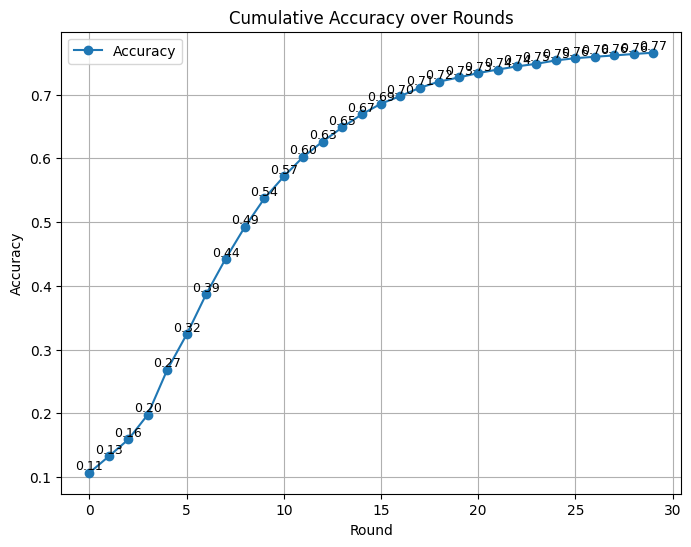

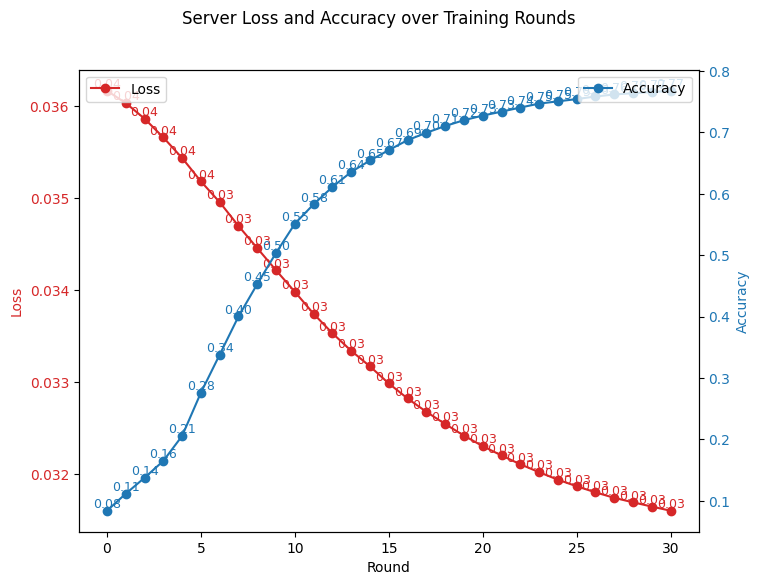

In [ ]:
from flwr.client import ClientApp
from flwr.client.mod import adaptiveclipping_mod
from flwr.server.strategy import DifferentialPrivacyClientSideAdaptiveClipping

dp_AdaClient_strategy =  DifferentialPrivacyClientSideAdaptiveClipping(
    strategy,
    noise_multiplier = 0.1 ,
    num_sampled_clients = 5,
    clip_norm_lr  = 0.2,
    # clipped_count_stddev = expected_num_records/20,
)

# Add fixedclipping_mod to the client-side mods
Clientapp_2 = ClientApp(
     client_fn=client_fn, mods=[adaptiveclipping_mod]
)

run_my_sim(
    strategy = dp_AdaClient_strategy,
    num_rounds = Num_rounds,
    num_clients = NUM_CLIENTS,
    Clientapp = Clientapp_2 ,
)

## **Local Differential Privacy**

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[codecarbon INFO @ 09:57:24] [setup] RAM Tracking...
[codecarbon INFO @ 09:57:24] [setup] CPU Tracking...
[codecarbon WARNING @ 09:57:24] No CPU tracking mode found. Falling back on CPU constant mode. 
 Linux OS detected: Please ensure RAPL files exist at \sys\class\powercap\intel-rapl to measure CPU



model is reset.. dont beleve me?.. acc= 0.10075 
No GPU found.


[codecarbon WARNING @ 09:57:25] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 09:57:25] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 09:57:25] [setup] GPU Tracking...
[codecarbon INFO @ 09:57:25] No GPU found.
[codecarbon INFO @ 09:57:25] >>> Tracker's metadata:
[codecarbon INFO @ 09:57:25]   Platform system: Linux-6.1.85+-x86_64-with-glibc2.35
[codecarbon INFO @ 09:57:25]   Python version: 3.10.12
[codecarbon INFO @ 09:57:25]   CodeCarbon version: 2.8.2
[codecarbon INFO @ 09:57:25]   Available RAM : 12.675 GB
[codecarbon INFO @ 09:57:25]   CPU count: 2
[codecarbon INFO @ 09:57:25]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 09:57:25]   GPU count: None
[codecarbon INFO @ 09:57:25]   GPU model: None
[codecarbon INFO @ 09:57:26] Saving emissions data to file /content/emissions.csv
INFO :      Starting Flower ServerApp, config: num_rounds=30, no round_timeout

FedAvg


(pid=63247) 2024-12-23 09:57:36.424042: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=63247) 2024-12-23 09:57:36.471620: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=63247) 2024-12-23 09:57:36.483750: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=63247) 2024-12-23 09:57:38.759869: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
[codecarbon INFO @ 09:57:41] Energy consumed for RAM : 0.000020 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:57:41] Energy consumed for all CPUs : 0.000177 kWh. Total CPU Power : 

(ClientAppActor pid=63247) [Client 4] get_parameters


[codecarbon INFO @ 09:57:56] Energy consumed for RAM : 0.000040 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:57:56] Energy consumed for all CPUs : 0.000354 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:57:56] 0.000394 kWh of electricity used since the beginning.
INFO :      initial parameters (loss, other metrics): 0.036222586059570315, {'accuracy': 0.0932}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.036222586059570315 / accuracy 0.0932
(ClientAppActor pid=63247) [Client 0, round 1] fit, config: {'server_round': 1, 'local_epochs': 1, 'learning rate': 0.01}


(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
(pid=63246) 2024-12-23 09:57:36.481380: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=63246) 2024-12-23 09:57:36.520362: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=63246) 2024-12-23 09:57:36.531987: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=63246) 2024-12-23 09:57:38.824791: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find Tensor

(ClientAppActor pid=63247) [Client 4, round 1] fit, config: {'server_round': 1, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=63246) [Client 3, round 1] fit, config: {'server_round': 1, 'local_epochs': 1, 'learning rate': 0.01}


(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
[codecarbon INFO @ 09:58:11] Energy consumed for RAM : 0.000059 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:58:11] Energy consumed for all CPUs : 0.000531 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:58:11] 0.000591 kWh of electricity used since the beginning.
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters


(ClientAppActor pid=63246) [Client 8, round 1] fit, config: {'server_round': 1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters


(ClientAppActor pid=63246) [Client 6, round 1] fit, config: {'server_round': 1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 09:58:26] Energy consumed for RAM : 0.000079 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:58:26] Energy consumed for all CPUs : 0.000708 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:58:26] 0.000787 kWh of electricity used since the beginning.
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000. [repeated 2x across cluster]
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters [repeated 2x across cluster]


(ClientAppActor pid=63246) [Client 5, round 1] fit, config: {'server_round': 1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
INFO :      aggregate_fit: received 10 results and 0 failures
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
[codecarbon INFO @ 09:58:41] Energy consumed for RAM : 0.000099 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:58:41] Energy consumed for all CPUs : 0.000885 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:58:41] 0.000984 kWh of electricity used since the beginning.
INFO :      fit progress: (1, 345.14081875, {'accuracy': 0.0997}, 44.99151947199971)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 345.14081875 / accuracy 0.0997
(ClientAppActor pid=63247) [Client 0] evaluate, config: {'current_round': 1}
(ClientAppActor pid=63247) [Client 2, round 1] fit, config: {'server_round': 1, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=63247) [Client 8] evaluate, config: {'current_round': 1} [repeated 4x across cluster]
(ClientAppActor pid=63247) [Client 3] evaluate, config: {'current_round': 1} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
[codecarbon INFO @ 09:58:56] Energy consumed for RAM : 0.000119 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:58:56] Energy consumed for all CPUs : 0.001062 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:58:56] 0.001181 kWh of electricity used since the beginning.


My_weighted_average -0.10166666666666667 346.17869954427084 
(ClientAppActor pid=63247) [Client 1, round 2] fit, config: {'server_round': 2, 'local_epochs': 1, 'learning rate': 0.01}


(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters


(ClientAppActor pid=63246) [Client 5] evaluate, config: {'current_round': 1}
(ClientAppActor pid=63247) [Client 4, round 2] fit, config: {'server_round': 2, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
[codecarbon INFO @ 09:59:11] Energy consumed for RAM : 0.000139 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:59:11] Energy consumed for all CPUs : 0.001239 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:59:11] 0.001378 kWh of electricity used since the beginning.


(ClientAppActor pid=63247) [Client 8, round 2] fit, config: {'server_round': 2, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters


(ClientAppActor pid=63247) [Client 2, round 2] fit, config: {'server_round': 2, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters


(ClientAppActor pid=63247) [Client 6, round 2] fit, config: {'server_round': 2, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 09:59:26] Energy consumed for RAM : 0.000158 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:59:26] Energy consumed for all CPUs : 0.001416 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:59:26] 0.001575 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:59:26] 0.001820 g.CO2eq/s mean an estimation of 57.40523239882539 kg.CO2eq/year
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
INFO :      aggregate_fit: received 10 results and 0 failures
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
INFO :      fit progress: (2, nan, {'accuracy': 0.098}, 98.22124616499968)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss nan / accuracy 0.098
(ClientAppActor pid=63246) [Client 0] evaluate, config: {'current_round': 2}
(ClientAppActor pid=63246) [Client 3, round 2] fit, config: {'server_round': 2, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 09:59:41] Energy consumed for RAM : 0.000178 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:59:41] Energy consumed for all CPUs : 0.001593 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:59:41] 0.001771 kWh of electricity used since the beginning.


(ClientAppActor pid=63246) [Client 8] evaluate, config: {'current_round': 2} [repeated 4x across cluster]
(ClientAppActor pid=63247) [Client 2] evaluate, config: {'current_round': 2} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.09758333333333333 nan 
(ClientAppActor pid=63247) [Client 2, round 3] fit, config: {'server_round': 3, 'local_epochs': 1, 'learning rate': 0.01}


(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
[codecarbon INFO @ 09:59:56] Energy consumed for RAM : 0.000198 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 09:59:56] Energy consumed for all CPUs : 0.001770 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:59:56] 0.001968 kWh of electricity used since the beginning.


(ClientAppActor pid=63246) [Client 7] evaluate, config: {'current_round': 2}
(ClientAppActor pid=63246) [Client 4, round 3] fit, config: {'server_round': 3, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters


(ClientAppActor pid=63246) [Client 8, round 3] fit, config: {'server_round': 3, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
[codecarbon INFO @ 10:00:11] Energy consumed for RAM : 0.000218 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:00:11] Energy consumed for all CPUs : 0.001947 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:00:11] 0.002165 kWh of electricity used since the beginning.


(ClientAppActor pid=63246) [Client 5, round 3] fit, config: {'server_round': 3, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters


(ClientAppActor pid=63246) [Client 1, round 3] fit, config: {'server_round': 3, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
INFO :      aggregate_fit: received 10 results and 0 failures
[codecarbon INFO @ 10:00:26] Energy consumed for RAM : 0.000237 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:00:26] Energy consumed for all CPUs : 0.002124 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:00:26] 0.002362 kWh of electricity used since the beginning.
INFO :      fit progress: (3, nan, {'accuracy': 0.098}, 152.97734677900007)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss nan / accuracy 0.098
(ClientAppActor pid=63247) [Client 1] evaluate, config: {'current_round': 3}
(ClientAppActor pid=63247) [Client 3, round 3] fit, config: {'server_round': 3, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=63246) [Client 7] evaluate, config: {'current_round': 3} [repeated 4x across cluster]


[codecarbon INFO @ 10:00:41] Energy consumed for RAM : 0.000257 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:00:41] Energy consumed for all CPUs : 0.002301 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:00:41] 0.002559 kWh of electricity used since the beginning.


(ClientAppActor pid=63247) [Client 8] evaluate, config: {'current_round': 3} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.09758333333333334 nan 
(ClientAppActor pid=63247) [Client 0, round 4] fit, config: {'server_round': 4, 'local_epochs': 1, 'learning rate': 0.01}


(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters


(ClientAppActor pid=63246) [Client 4, round 4] fit, config: {'server_round': 4, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 10:00:56] Energy consumed for RAM : 0.000277 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:00:56] Energy consumed for all CPUs : 0.002478 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:00:56] 0.002756 kWh of electricity used since the beginning.
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters


(ClientAppActor pid=63247) [Client 8, round 4] fit, config: {'server_round': 4, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters


(ClientAppActor pid=63247) [Client 7, round 4] fit, config: {'server_round': 4, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
[codecarbon INFO @ 10:01:11] Energy consumed for RAM : 0.000297 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:01:11] Energy consumed for all CPUs : 0.002655 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:01:11] 0.002952 kWh of electricity used since the beginning.


(ClientAppActor pid=63246) [Client 5, round 4] fit, config: {'server_round': 4, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (4, nan, {'accuracy': 0.098}, 207.4542409959995)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss nan / accuracy 0.098


[codecarbon INFO @ 10:01:26] Energy consumed for RAM : 0.000317 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:01:26] Energy consumed for all CPUs : 0.002832 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:01:26] 0.003149 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:01:26] 0.001821 g.CO2eq/s mean an estimation of 57.41128913026064 kg.CO2eq/year


(ClientAppActor pid=63247) [Client 0] evaluate, config: {'current_round': 4}
(ClientAppActor pid=63247) [Client 9, round 4] fit, config: {'server_round': 4, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=63246) [Client 7] evaluate, config: {'current_round': 4} [repeated 4x across cluster]
(ClientAppActor pid=63247) [Client 4] evaluate, config: {'current_round': 4} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.09758333333333334 nan 
(ClientAppActor pid=63247) [Client 0, round 5] fit, config: {'server_round': 5, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 10:01:41] Energy consumed for RAM : 0.000336 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:01:41] Energy consumed for all CPUs : 0.003010 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:01:41] 0.003346 kWh of electricity used since the beginning.
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters


(ClientAppActor pid=63247) [Client 5, round 5] fit, config: {'server_round': 5, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters


(ClientAppActor pid=63247) [Client 8, round 5] fit, config: {'server_round': 5, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 10:01:56] Energy consumed for RAM : 0.000356 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:01:56] Energy consumed for all CPUs : 0.003187 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:01:56] 0.003543 kWh of electricity used since the beginning.
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters


(ClientAppActor pid=63247) [Client 3, round 5] fit, config: {'server_round': 5, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters


(ClientAppActor pid=63247) [Client 2, round 5] fit, config: {'server_round': 5, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 10:02:11] Energy consumed for RAM : 0.000376 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:02:11] Energy consumed for all CPUs : 0.003364 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:02:11] 0.003740 kWh of electricity used since the beginning.
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (5, nan, {'accuracy': 0.098}, 261.21365234100085)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss nan / accuracy 0.098
(ClientAppActor pid=63247) [Client 1] evaluate, config: {'current_round': 5}
(ClientAppActor pid=63246) [Client 1, round 5] fit, config: {'server_round': 5, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=63247) [Client 8] evaluate, config: {'current_round': 5} [repeated 4x across cluster]


[codecarbon INFO @ 10:02:26] Energy consumed for RAM : 0.000396 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:02:26] Energy consumed for all CPUs : 0.003541 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:02:26] 0.003936 kWh of electricity used since the beginning.


(ClientAppActor pid=63246) [Client 9] evaluate, config: {'current_round': 5} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.09758333333333334 nan 
(ClientAppActor pid=63247) [Client 1, round 6] fit, config: {'server_round': 6, 'local_epochs': 1, 'learning rate': 0.01}


(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters


(ClientAppActor pid=63247) [Client 4] evaluate, config: {'current_round': 5}
(ClientAppActor pid=63247) [Client 4, round 6] fit, config: {'server_round': 6, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 10:02:41] Energy consumed for RAM : 0.000416 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:02:41] Energy consumed for all CPUs : 0.003718 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:02:41] 0.004133 kWh of electricity used since the beginning.
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters


(ClientAppActor pid=63246) [Client 9, round 6] fit, config: {'server_round': 6, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters


(ClientAppActor pid=63246) [Client 3, round 6] fit, config: {'server_round': 6, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 10:02:56] Energy consumed for RAM : 0.000435 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:02:56] Energy consumed for all CPUs : 0.003895 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:02:56] 0.004330 kWh of electricity used since the beginning.
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters


(ClientAppActor pid=63246) [Client 0, round 6] fit, config: {'server_round': 6, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
INFO :      aggregate_fit: received 10 results and 0 failures
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
[codecarbon INFO @ 10:03:11] Energy consumed for RAM : 0.000455 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:03:11] Energy consumed for all CPUs : 0.004072 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:03:11] 0.004527 kWh of electricity used since the beginning.
INFO :      fit progress: (6, nan, {'accuracy': 0.098}, 317.0500275760005)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss nan / accuracy 0.098
(ClientAppActor pid=63246) [Client 2] evaluate, config: {'current_round': 6}
(ClientAppActor pid=63247) [Client 7, round 6] fit, config: {'server_round': 6, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=63247) [Client 5] evaluate, config: {'current_round': 6} [repeated 4x across cluster]


[codecarbon INFO @ 10:03:26] Energy consumed for RAM : 0.000475 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:03:26] Energy consumed for all CPUs : 0.004249 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:03:26] 0.004724 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:03:26] 0.001820 g.CO2eq/s mean an estimation of 57.40467948476688 kg.CO2eq/year


(ClientAppActor pid=63246) [Client 8] evaluate, config: {'current_round': 6} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.09758333333333334 nan 
(ClientAppActor pid=63247) [Client 1, round 7] fit, config: {'server_round': 7, 'local_epochs': 1, 'learning rate': 0.01}


(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters


(ClientAppActor pid=63247) [Client 6] evaluate, config: {'current_round': 6}
(ClientAppActor pid=63247) [Client 3, round 7] fit, config: {'server_round': 7, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
[codecarbon INFO @ 10:03:41] Energy consumed for RAM : 0.000495 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:03:41] Energy consumed for all CPUs : 0.004426 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:03:41] 0.004921 kWh of electricity used since the beginning.


(ClientAppActor pid=63247) [Client 7, round 7] fit, config: {'server_round': 7, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters


(ClientAppActor pid=63247) [Client 8, round 7] fit, config: {'server_round': 7, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters


(ClientAppActor pid=63247) [Client 0, round 7] fit, config: {'server_round': 7, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 10:03:56] Energy consumed for RAM : 0.000515 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:03:56] Energy consumed for all CPUs : 0.004603 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:03:56] 0.005118 kWh of electricity used since the beginning.
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
INFO :      aggregate_fit: received 10 results and 0 failures
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
INFO :      fit progress: (7, nan, {'accuracy': 0.098}, 372.2619040219997)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss nan / accuracy 0.098


[codecarbon INFO @ 10:04:11] Energy consumed for RAM : 0.000534 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:04:11] Energy consumed for all CPUs : 0.004780 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:04:11] 0.005314 kWh of electricity used since the beginning.


(ClientAppActor pid=63246) [Client 0] evaluate, config: {'current_round': 7}
(ClientAppActor pid=63246) [Client 4, round 7] fit, config: {'server_round': 7, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=63246) [Client 5] evaluate, config: {'current_round': 7} [repeated 4x across cluster]
(ClientAppActor pid=63247) [Client 6] evaluate, config: {'current_round': 7} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.09758333333333333 nan 
(ClientAppActor pid=63247) [Client 2, round 8] fit, config: {'server_round': 8, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 10:04:26] Energy consumed for RAM : 0.000554 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:04:26] Energy consumed for all CPUs : 0.004957 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:04:26] 0.005511 kWh of electricity used since the beginning.
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters


(ClientAppActor pid=63246) [Client 2] evaluate, config: {'current_round': 7}
(ClientAppActor pid=63246) [Client 5, round 8] fit, config: {'server_round': 8, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters


(ClientAppActor pid=63247) [Client 9, round 8] fit, config: {'server_round': 8, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 10:04:41] Energy consumed for RAM : 0.000574 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:04:41] Energy consumed for all CPUs : 0.005134 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:04:41] 0.005708 kWh of electricity used since the beginning.
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters


(ClientAppActor pid=63247) [Client 3, round 8] fit, config: {'server_round': 8, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters


(ClientAppActor pid=63247) [Client 1, round 8] fit, config: {'server_round': 8, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 10:04:56] Energy consumed for RAM : 0.000594 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:04:56] Energy consumed for all CPUs : 0.005311 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:04:56] 0.005905 kWh of electricity used since the beginning.
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (8, nan, {'accuracy': 0.098}, 429.28970532899984)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss nan / accuracy 0.098
(ClientAppActor pid=63246) [Client 0] evaluate, config: {'current_round': 8}
(ClientAppActor pid=63246) [Client 6, round 8] fit, config: {'server_round': 8, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 10:05:11] Energy consumed for RAM : 0.000614 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:05:11] Energy consumed for all CPUs : 0.005488 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:05:11] 0.006102 kWh of electricity used since the beginning.


(ClientAppActor pid=63247) [Client 9] evaluate, config: {'current_round': 8} [repeated 4x across cluster]
(ClientAppActor pid=63247) [Client 2] evaluate, config: {'current_round': 8} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.09758333333333333 nan 
(ClientAppActor pid=63247) [Client 2, round 9] fit, config: {'server_round': 9, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 10:05:26] Energy consumed for RAM : 0.000633 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:05:26] Energy consumed for all CPUs : 0.005665 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:05:26] 0.006299 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:05:26] 0.001820 g.CO2eq/s mean an estimation of 57.39786936168414 kg.CO2eq/year
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters


(ClientAppActor pid=63246) [Client 6] evaluate, config: {'current_round': 8}
(ClientAppActor pid=63247) [Client 3, round 9] fit, config: {'server_round': 9, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters


(ClientAppActor pid=63247) [Client 7, round 9] fit, config: {'server_round': 9, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
[codecarbon INFO @ 10:05:41] Energy consumed for RAM : 0.000653 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:05:41] Energy consumed for all CPUs : 0.005842 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:05:41] 0.006495 kWh of electricity used since the beginning.


(ClientAppActor pid=63247) [Client 4, round 9] fit, config: {'server_round': 9, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters


(ClientAppActor pid=63247) [Client 6, round 9] fit, config: {'server_round': 9, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
INFO :      aggregate_fit: received 10 results and 0 failures
[codecarbon INFO @ 10:05:56] Energy consumed for RAM : 0.000673 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:05:56] Energy consumed for all CPUs : 0.006019 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:05:56] 0.006692 kWh of electricity used since the beginning.
INFO :      fit progress: (9, nan, {'accuracy': 0.098}, 484.518673169001)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss nan / accuracy 0.098
(ClientAppActor pid=63246) [Client 0] evaluate, config: {'current_round': 9}
(ClientAppActor pid=63246) [Client 9, round 9] fit, config: {'server_round': 9, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=63246) [Client 7] evaluate, config: {'current_round': 9} [repeated 4x across cluster]


[codecarbon INFO @ 10:06:11] Energy consumed for RAM : 0.000693 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:06:11] Energy consumed for all CPUs : 0.006196 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:06:11] 0.006889 kWh of electricity used since the beginning.


(ClientAppActor pid=63246) [Client 4] evaluate, config: {'current_round': 9} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.09758333333333333 nan 
(ClientAppActor pid=63247) [Client 0, round 10] fit, config: {'server_round': 10, 'local_epochs': 1, 'learning rate': 0.01}


(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters


(ClientAppActor pid=63247) [Client 9] evaluate, config: {'current_round': 9}
(ClientAppActor pid=63247) [Client 5, round 10] fit, config: {'server_round': 10, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 10:06:26] Energy consumed for RAM : 0.000713 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:06:26] Energy consumed for all CPUs : 0.006373 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:06:26] 0.007086 kWh of electricity used since the beginning.
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters


(ClientAppActor pid=63247) [Client 7, round 10] fit, config: {'server_round': 10, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=63247) [Client 2, round 10] fit, config: {'server_round': 10, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 10:06:41] Energy consumed for RAM : 0.000732 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:06:41] Energy consumed for all CPUs : 0.006550 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:06:41] 0.007283 kWh of electricity used since the beginning.
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters [repeated 2x across cluster]
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=63246) [Client 1, round 10] fit, config: {'server_round': 10, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters [repeated 2x across cluster]
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: received 10 results and 0 failures
[codecarbon INFO @ 10:06:56] Energy consumed for RAM : 0.000752 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:06:56] Energy consumed for all CPUs : 0.006728 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:06:56] 0.007480 kWh of electricity used since the beginning.
INFO :      fit progress: (10, nan, {'accuracy': 0.098}, 539.2365151640006)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss nan / accuracy 0.098
(ClientAppActor pid=63247) [Client 0] evaluate, config: {'current_round': 10}
(ClientAppActor pid=63247) [Client 4, round 10] fit, config: {'server_round': 10, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=63247) [Client 6] evaluate, config: {'current_round': 10} [repeated 4x across cluster]
(ClientAppActor pid=63246) [Client 5] evaluate, config: {'current_round': 10} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.09758333333333333 nan 


[codecarbon INFO @ 10:07:11] Energy consumed for RAM : 0.000772 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:07:11] Energy consumed for all CPUs : 0.006904 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:07:11] 0.007676 kWh of electricity used since the beginning.


(ClientAppActor pid=63247) [Client 5, round 11] fit, config: {'server_round': 11, 'local_epochs': 1, 'learning rate': 0.01}


(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters [repeated 2x across cluster]
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=63246) [Client 7, round 11] fit, config: {'server_round': 11, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters [repeated 2x across cluster]
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=63246) [Client 0, round 11] fit, config: {'server_round': 11, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 10:07:26] Energy consumed for RAM : 0.000792 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:07:26] Energy consumed for all CPUs : 0.007081 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:07:26] 0.007873 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:07:26] 0.001820 g.CO2eq/s mean an estimation of 57.41088820783138 kg.CO2eq/year
(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters [repeated 2x across cluster]
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=63247) [Client 8, round 11] fit, config: {'server_round': 11, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters [repeated 2x across cluster]
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=63246) [Client 4, round 11] fit, config: {'server_round': 11, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 10:07:41] Energy consumed for RAM : 0.000811 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:07:41] Energy consumed for all CPUs : 0.007259 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:07:41] 0.008070 kWh of electricity used since the beginning.
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters [repeated 2x across cluster]
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (11, nan, {'accuracy': 0.098}, 594.9925740630006)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss nan / accuracy 0.098
(ClientAppActor pid=63247) [Client 3] evaluate, config: {'current_round': 11}
(ClientAppActor pid=63247) [Client 1, round 11] fit, config: {'server_round': 11, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 10:07:56] Energy consumed for RAM : 0.000831 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:07:56] Energy consumed for all CPUs : 0.007436 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:07:56] 0.008267 kWh of electricity used since the beginning.


(ClientAppActor pid=63247) [Client 7] evaluate, config: {'current_round': 11} [repeated 4x across cluster]
(ClientAppActor pid=63246) [Client 5] evaluate, config: {'current_round': 11} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.09758333333333333 nan 
(ClientAppActor pid=63247) [Client 1, round 12] fit, config: {'server_round': 12, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 10:08:11] Energy consumed for RAM : 0.000851 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:08:11] Energy consumed for all CPUs : 0.007613 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:08:11] 0.008464 kWh of electricity used since the beginning.
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters [repeated 2x across cluster]
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=63247) [Client 0] evaluate, config: {'current_round': 11}
(ClientAppActor pid=63247) [Client 3, round 12] fit, config: {'server_round': 12, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters [repeated 2x across cluster]
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=63247) [Client 6, round 12] fit, config: {'server_round': 12, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 10:08:26] Energy consumed for RAM : 0.000871 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:08:26] Energy consumed for all CPUs : 0.007790 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:08:26] 0.008661 kWh of electricity used since the beginning.
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters [repeated 2x across cluster]
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=63247) [Client 4, round 12] fit, config: {'server_round': 12, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters [repeated 2x across cluster]
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=63247) [Client 7, round 12] fit, config: {'server_round': 12, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 10:08:41] Energy consumed for RAM : 0.000891 kWh. RAM Power : 4.753036022186279 W
(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
[codecarbon INFO @ 10:08:41] Energy consumed for all CPUs : 0.007967 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:08:41] 0.008857 kWh of electricity used since the beginning.
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
INFO :      aggregate_fit: received 10 results and 0 failures
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
INFO :      fit progress: (12, nan, {'accuracy': 0.098}, 650.6181712739999)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss nan / accuracy 0.098
(ClientAppActor pid=63246) [Client 4] evaluate, config: {'current_round': 12}
(ClientAppActor pid=63246) [Client 0, round 12] fit, config: {'server_round': 12, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=63247) [Client 8] evaluate, config: {'current_round': 12} [repeated 4x across cluster]


[codecarbon INFO @ 10:08:56] Energy consumed for RAM : 0.000910 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:08:56] Energy consumed for all CPUs : 0.008144 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:08:56] 0.009054 kWh of electricity used since the beginning.


(ClientAppActor pid=63247) [Client 0] evaluate, config: {'current_round': 12} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.09758333333333333 nan 
(ClientAppActor pid=63247) [Client 1, round 13] fit, config: {'server_round': 13, 'local_epochs': 1, 'learning rate': 0.01}


(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters [repeated 2x across cluster]
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=63246) [Client 1] evaluate, config: {'current_round': 12}
(ClientAppActor pid=63247) [Client 3, round 13] fit, config: {'server_round': 13, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 10:09:11] Energy consumed for RAM : 0.000930 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:09:11] Energy consumed for all CPUs : 0.008321 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:09:11] 0.009251 kWh of electricity used since the beginning.
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters [repeated 2x across cluster]
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=63247) [Client 6, round 13] fit, config: {'server_round': 13, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters [repeated 2x across cluster]
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=63247) [Client 2, round 13] fit, config: {'server_round': 13, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
[codecarbon INFO @ 10:09:26] Energy consumed for RAM : 0.000950 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:09:26] Energy consumed for all CPUs : 0.008498 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:09:26] 0.009448 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:09:26] 0.001820 g.CO2eq/s mean an estimation of 57.40656836687536 kg.CO2eq/year
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters [repeated 2x across cluster]
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=63247) [Client 7, round 13] fit, config: {'server_round': 13, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters [repeated 2x across cluster]
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: received 10 results and 0 failures
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
[codecarbon INFO @ 10:09:41] Energy consumed for RAM : 0.000970 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:09:41] Energy consumed for all CPUs : 0.008675 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:09:41] 0.009645 kWh of electricity used since the beginning.
INFO :      fit progress: (13, nan, {'accuracy': 0.098}, 706.6254116950004)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss nan / accuracy 0.098
(ClientAppActor pid=63247) [Client 2] evaluate, config: {'current_round': 13}
(ClientAppActor pid=63246) [Client 4, round 13] fit, config: {'server_round': 13, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=63246) [Client 8] evaluate, config: {'current_round': 13} [repeated 4x across cluster]


[codecarbon INFO @ 10:09:56] Energy consumed for RAM : 0.000990 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:09:56] Energy consumed for all CPUs : 0.008852 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:09:56] 0.009842 kWh of electricity used since the beginning.


(ClientAppActor pid=63247) [Client 3] evaluate, config: {'current_round': 13} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.09758333333333333 nan 
(ClientAppActor pid=63247) [Client 2, round 14] fit, config: {'server_round': 14, 'local_epochs': 1, 'learning rate': 0.01}


(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters [repeated 2x across cluster]
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=63247) [Client 4, round 14] fit, config: {'server_round': 14, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters [repeated 2x across cluster]
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
[codecarbon INFO @ 10:10:11] Energy consumed for RAM : 0.001009 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:10:11] Energy consumed for all CPUs : 0.009029 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:10:11] 0.010038 kWh of electricity used since the beginning.


(ClientAppActor pid=63247) [Client 7, round 14] fit, config: {'server_round': 14, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters [repeated 2x across cluster]
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=63247) [Client 0, round 14] fit, config: {'server_round': 14, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters [repeated 2x across cluster]
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=63247) [Client 1, round 14] fit, config: {'server_round': 14, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 10:10:26] Energy consumed for RAM : 0.001029 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:10:26] Energy consumed for all CPUs : 0.009206 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:10:26] 0.010235 kWh of electricity used since the beginning.
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters [repeated 2x across cluster]
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (14, nan, {'accuracy': 0.098}, 760.1090397770004)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss nan / accuracy 0.098
(ClientAppActor pid=63247) [Client 1] evaluate, config: {'current_round': 14}
(ClientAppActor pid=63246) [Client 9, round 14] fit, config: {'server_round': 14, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 10:10:41] Energy consumed for RAM : 0.001049 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:10:41] Energy consumed for all CPUs : 0.009383 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:10:41] 0.010432 kWh of electricity used since the beginning.


(ClientAppActor pid=63247) [Client 8] evaluate, config: {'current_round': 14} [repeated 4x across cluster]
(ClientAppActor pid=63246) [Client 3] evaluate, config: {'current_round': 14} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.09758333333333333 nan 
(ClientAppActor pid=63247) [Client 1, round 15] fit, config: {'server_round': 15, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 10:10:56] Energy consumed for RAM : 0.001069 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:10:56] Energy consumed for all CPUs : 0.009560 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:10:56] 0.010629 kWh of electricity used since the beginning.
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters [repeated 2x across cluster]
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=63247) [Client 5, round 15] fit, config: {'server_round': 15, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=63247) [Client 7, round 15] fit, config: {'server_round': 15, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters [repeated 2x across cluster]
[codecarbon INFO @ 10:11:11] Energy consumed for RAM : 0.001089 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:11:11] Energy consumed for all CPUs : 0.009737 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:11:11] 0.010826 kWh of electricity used since the beginning.
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000. [repeated 2x across cluster]


(ClientAppActor pid=63247) [Client 3, round 15] fit, config: {'server_round': 15, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=63247) [Client 2, round 15] fit, config: {'server_round': 15, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters [repeated 2x across cluster]
INFO :      aggregate_fit: received 10 results and 0 failures
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000. [repeated 2x across cluster]
[codecarbon INFO @ 10:11:26] Energy consumed for RAM : 0.001108 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:11:26] Energy consumed for all CPUs : 0.009914 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:11:26] 0.011023 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:11:26] 0.001820 g.CO2eq/s mean an estimation of 57.40791830813399 kg.CO2eq/year
INFO :      fit progress: (15, nan, {'accuracy': 0.098}, 814.2050168580008)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss nan / accuracy 0.098
(ClientAppActor pid=63247) [Client 1] evaluate, config: {'current_round': 15}
(ClientAppActor pid=63246) [Client 8, round 15] fit, config: {'server_round': 15, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=63247) [Client 9] evaluate, config: {'current_round': 15} [repeated 4x across cluster]


[codecarbon INFO @ 10:11:41] Energy consumed for RAM : 0.001128 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:11:41] Energy consumed for all CPUs : 0.010091 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:11:41] 0.011219 kWh of electricity used since the beginning.


(ClientAppActor pid=63247) [Client 2] evaluate, config: {'current_round': 15} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.09758333333333333 nan 
(ClientAppActor pid=63247) [Client 2, round 16] fit, config: {'server_round': 16, 'local_epochs': 1, 'learning rate': 0.01}


(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters [repeated 2x across cluster]
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=63246) [Client 5] evaluate, config: {'current_round': 15}
(ClientAppActor pid=63247) [Client 4, round 16] fit, config: {'server_round': 16, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 10:11:56] Energy consumed for RAM : 0.001148 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:11:56] Energy consumed for all CPUs : 0.010268 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:11:56] 0.011416 kWh of electricity used since the beginning.
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters [repeated 2x across cluster]
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=63247) [Client 6, round 16] fit, config: {'server_round': 16, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters [repeated 2x across cluster]
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000. [repeated 2x across cluster]


(ClientAppActor pid=63247) [Client 1, round 16] fit, config: {'server_round': 16, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters [repeated 2x across cluster]
[codecarbon INFO @ 10:12:11] Energy consumed for RAM : 0.001168 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:12:11] Energy consumed for all CPUs : 0.010446 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:12:11] 0.011613 kWh of electricity used since the beginning.
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000. [repeated 2x across cluster]


(ClientAppActor pid=63247) [Client 9, round 16] fit, config: {'server_round': 16, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters [repeated 2x across cluster]
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (16, nan, {'accuracy': 0.098}, 867.6440812279998)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss nan / accuracy 0.098


[codecarbon INFO @ 10:12:26] Energy consumed for RAM : 0.001188 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:12:26] Energy consumed for all CPUs : 0.010623 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:12:26] 0.011810 kWh of electricity used since the beginning.


(ClientAppActor pid=63247) [Client 3] evaluate, config: {'current_round': 16}
(ClientAppActor pid=63246) [Client 7, round 16] fit, config: {'server_round': 16, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=63246) [Client 9] evaluate, config: {'current_round': 16} [repeated 4x across cluster]
(ClientAppActor pid=63246) [Client 7] evaluate, config: {'current_round': 16} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.09758333333333333 nan 


[codecarbon INFO @ 10:12:41] Energy consumed for RAM : 0.001207 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:12:41] Energy consumed for all CPUs : 0.010800 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:12:41] 0.012007 kWh of electricity used since the beginning.


(ClientAppActor pid=63247) [Client 0, round 17] fit, config: {'server_round': 17, 'local_epochs': 1, 'learning rate': 0.01}


(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters [repeated 2x across cluster]
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=63247) [Client 1] evaluate, config: {'current_round': 16}
(ClientAppActor pid=63246) [Client 2, round 17] fit, config: {'server_round': 17, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
[codecarbon INFO @ 10:12:56] Energy consumed for RAM : 0.001227 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:12:56] Energy consumed for all CPUs : 0.010977 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:12:56] 0.012204 kWh of electricity used since the beginning.


(ClientAppActor pid=63247) [Client 7, round 17] fit, config: {'server_round': 17, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters [repeated 2x across cluster]
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=63247) [Client 4, round 17] fit, config: {'server_round': 17, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters [repeated 2x across cluster]
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000. [repeated 2x across cluster]


(ClientAppActor pid=63247) [Client 3, round 17] fit, config: {'server_round': 17, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 10:13:11] Energy consumed for RAM : 0.001247 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:13:11] Energy consumed for all CPUs : 0.011154 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:13:11] 0.012401 kWh of electricity used since the beginning.
INFO :      aggregate_fit: received 10 results and 0 failures
(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters [repeated 3x across cluster]
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000. [repeated 2x across cluster]
INFO :      fit progress: (17, nan, {'accuracy': 0.098}, 923.5919226330006)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss nan / accuracy 0.098
(ClientAppActor pid=63246) [Client 0] evaluate, config: {'current_round': 17}
(ClientAppActor pid=63246) [Client 6, round 17] fit, config: {'server_round': 17, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 10:13:26] Energy consumed for RAM : 0.001267 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:13:26] Energy consumed for all CPUs : 0.011331 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:13:26] 0.012598 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:13:26] 0.001821 g.CO2eq/s mean an estimation of 57.41312106349125 kg.CO2eq/year


(ClientAppActor pid=63247) [Client 9] evaluate, config: {'current_round': 17} [repeated 5x across cluster]
(ClientAppActor pid=63247) [Client 6] evaluate, config: {'current_round': 17} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.09758333333333333 nan 
(ClientAppActor pid=63247) [Client 0, round 18] fit, config: {'server_round': 18, 'local_epochs': 1, 'learning rate': 0.01}


(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
[codecarbon INFO @ 10:13:41] Energy consumed for RAM : 0.001287 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:13:41] Energy consumed for all CPUs : 0.011508 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:13:41] 0.012795 kWh of electricity used since the beginning.


(ClientAppActor pid=63247) [Client 5, round 18] fit, config: {'server_round': 18, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters


(ClientAppActor pid=63247) [Client 7, round 18] fit, config: {'server_round': 18, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters


(ClientAppActor pid=63247) [Client 1, round 18] fit, config: {'server_round': 18, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 10:13:56] Energy consumed for RAM : 0.001306 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:13:56] Energy consumed for all CPUs : 0.011685 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:13:56] 0.012992 kWh of electricity used since the beginning.
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters


(ClientAppActor pid=63247) [Client 2, round 18] fit, config: {'server_round': 18, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000. [repeated 2x across cluster]
(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters [repeated 2x across cluster]
[codecarbon INFO @ 10:14:11] Energy consumed for RAM : 0.001326 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:14:11] Energy consumed for all CPUs : 0.011862 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:14:11] 0.013188 kWh of electricity used since the beginning.
INFO :      fit progress: (18, nan, {'accuracy': 0.098}, 978.3361892060002)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss nan / accuracy 0.098
(ClientAppActor pid=63246) [Client 0] evaluate, config: {'current_round': 18}
(ClientAppActor pid=63246) [Client 8, round 18] fit, config: {'server_round': 18, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=63246) [Client 6] evaluate, config: {'current_round': 18} [repeated 4x across cluster]


[codecarbon INFO @ 10:14:26] Energy consumed for RAM : 0.001346 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:14:26] Energy consumed for all CPUs : 0.012039 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:14:26] 0.013385 kWh of electricity used since the beginning.


(ClientAppActor pid=63247) [Client 9] evaluate, config: {'current_round': 18} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.09758333333333333 nan 
(ClientAppActor pid=63246) [Client 1, round 19] fit, config: {'server_round': 19, 'local_epochs': 1, 'learning rate': 0.01}


(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters


(ClientAppActor pid=63246) [Client 4, round 19] fit, config: {'server_round': 19, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
[codecarbon INFO @ 10:14:41] Energy consumed for RAM : 0.001366 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:14:41] Energy consumed for all CPUs : 0.012216 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:14:41] 0.013582 kWh of electricity used since the beginning.
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters


(ClientAppActor pid=63246) [Client 7, round 19] fit, config: {'server_round': 19, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters


(ClientAppActor pid=63246) [Client 2, round 19] fit, config: {'server_round': 19, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
[codecarbon INFO @ 10:14:56] Energy consumed for RAM : 0.001385 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:14:56] Energy consumed for all CPUs : 0.012393 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:14:56] 0.013779 kWh of electricity used since the beginning.


(ClientAppActor pid=63246) [Client 3, round 19] fit, config: {'server_round': 19, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (19, nan, {'accuracy': 0.098}, 1031.695262913001)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss nan / accuracy 0.098
(ClientAppActor pid=63247) [Client 2] evaluate, config: {'current_round': 19}
(ClientAppActor pid=63247) [Client 6, round 19] fit, config: {'server_round': 19, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 10:15:11] Energy consumed for RAM : 0.001405 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:15:11] Energy consumed for all CPUs : 0.012571 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:15:11] 0.013976 kWh of electricity used since the beginning.


(ClientAppActor pid=63247) [Client 8] evaluate, config: {'current_round': 19} [repeated 4x across cluster]
(ClientAppActor pid=63246) [Client 1] evaluate, config: {'current_round': 19} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.09758333333333333 nan 
(ClientAppActor pid=63246) [Client 1, round 20] fit, config: {'server_round': 20, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 10:15:26] Energy consumed for RAM : 0.001425 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:15:26] Energy consumed for all CPUs : 0.012748 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:15:26] 0.014173 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:15:26] 0.001821 g.CO2eq/s mean an estimation of 57.41516843625662 kg.CO2eq/year
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters


(ClientAppActor pid=63246) [Client 3, round 20] fit, config: {'server_round': 20, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=63246) [Client 7, round 20] fit, config: {'server_round': 20, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 10:15:41] Energy consumed for RAM : 0.001445 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:15:41] Energy consumed for all CPUs : 0.012925 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:15:41] 0.014370 kWh of electricity used since the beginning.
(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters [repeated 2x across cluster]
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=63246) [Client 6, round 20] fit, config: {'server_round': 20, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters [repeated 2x across cluster]
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=63246) [Client 5, round 20] fit, config: {'server_round': 20, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters [repeated 2x across cluster]
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000. [repeated 2x across cluster]
INFO :      aggregate_fit: received 10 results and 0 failures
[codecarbon INFO @ 10:15:56] Energy consumed for RAM : 0.001465 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:15:56] Energy consumed for all CPUs : 0.013102 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:15:56] 0.014567 kWh of electricity used since the beginning.
INFO :      fit progress: (20, nan, {'accuracy': 0.098}, 1085.0862364530003)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss nan / accuracy 0.098
(ClientAppActor pid=63247) [Client 0] evaluate, config: {'current_round': 20}
(ClientAppActor pid=63247) [Client 8, round 20] fit, config: {'server_round': 20, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=63247) [Client 9] evaluate, config: {'current_round': 20} [repeated 4x across cluster]


[codecarbon INFO @ 10:16:11] Energy consumed for RAM : 0.001484 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:16:11] Energy consumed for all CPUs : 0.013279 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:16:11] 0.014763 kWh of electricity used since the beginning.


(ClientAppActor pid=63247) [Client 4] evaluate, config: {'current_round': 20} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.09758333333333333 nan 
(ClientAppActor pid=63246) [Client 0, round 21] fit, config: {'server_round': 21, 'local_epochs': 1, 'learning rate': 0.01}


(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters [repeated 2x across cluster]
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=63246) [Client 5] evaluate, config: {'current_round': 20}
(ClientAppActor pid=63247) [Client 4, round 21] fit, config: {'server_round': 21, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 10:16:26] Energy consumed for RAM : 0.001504 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:16:26] Energy consumed for all CPUs : 0.013456 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:16:26] 0.014960 kWh of electricity used since the beginning.
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters [repeated 2x across cluster]
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=63246) [Client 5, round 21] fit, config: {'server_round': 21, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=63247) [Client 9, round 21] fit, config: {'server_round': 21, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 10:16:41] Energy consumed for RAM : 0.001524 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:16:41] Energy consumed for all CPUs : 0.013633 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:16:41] 0.015157 kWh of electricity used since the beginning.
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=63246) [Client 2, round 21] fit, config: {'server_round': 21, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters [repeated 2x across cluster]
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: received 10 results and 0 failures
[codecarbon INFO @ 10:16:56] Energy consumed for RAM : 0.001544 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:16:56] Energy consumed for all CPUs : 0.013810 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:16:56] 0.015354 kWh of electricity used since the beginning.
INFO :      fit progress: (21, nan, {'accuracy': 0.098}, 1141.8039970120008)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss nan / accuracy 0.098
(ClientAppActor pid=63247) [Client 0] evaluate, config: {'current_round': 21}
(ClientAppActor pid=63247) [Client 7, round 21] fit, config: {'server_round': 21, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=63246) [Client 9] evaluate, config: {'current_round': 21} [repeated 5x across cluster]


[codecarbon INFO @ 10:17:11] Energy consumed for RAM : 0.001564 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:17:11] Energy consumed for all CPUs : 0.013987 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:17:11] 0.015551 kWh of electricity used since the beginning.
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.09758333333333333 nan 
(ClientAppActor pid=63247) [Client 2, round 22] fit, config: {'server_round': 22, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=63246) [Client 6] evaluate, config: {'current_round': 21} [repeated 4x across cluster]


(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters [repeated 2x across cluster]
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=63246) [Client 6, round 22] fit, config: {'server_round': 22, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters [repeated 2x across cluster]
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
[codecarbon INFO @ 10:17:26] Energy consumed for RAM : 0.001583 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:17:26] Energy consumed for all CPUs : 0.014164 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:17:26] 0.015748 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:17:26] 0.001821 g.CO2eq/s mean an estimation of 57.41212225732805 kg.CO2eq/year


(ClientAppActor pid=63247) [Client 9, round 22] fit, config: {'server_round': 22, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters [repeated 2x across cluster]
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=63247) [Client 8, round 22] fit, config: {'server_round': 22, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters [repeated 2x across cluster]
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=63247) [Client 3, round 22] fit, config: {'server_round': 22, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 10:17:41] Energy consumed for RAM : 0.001603 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:17:41] Energy consumed for all CPUs : 0.014341 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:17:41] 0.015945 kWh of electricity used since the beginning.
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters [repeated 2x across cluster]
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (22, nan, {'accuracy': 0.098}, 1196.1178959970002)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss nan / accuracy 0.098
(ClientAppActor pid=63247) [Client 4] evaluate, config: {'current_round': 22}
(ClientAppActor pid=63246) [Client 0, round 22] fit, config: {'server_round': 22, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 10:17:56] Energy consumed for RAM : 0.001623 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:17:56] Energy consumed for all CPUs : 0.014519 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:17:56] 0.016142 kWh of electricity used since the beginning.


(ClientAppActor pid=63247) [Client 8] evaluate, config: {'current_round': 22} [repeated 4x across cluster]
(ClientAppActor pid=63247) [Client 5] evaluate, config: {'current_round': 22} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.09758333333333333 nan 
(ClientAppActor pid=63247) [Client 3, round 23] fit, config: {'server_round': 23, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 10:18:11] Energy consumed for RAM : 0.001643 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:18:11] Energy consumed for all CPUs : 0.014696 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:18:11] 0.016339 kWh of electricity used since the beginning.
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters [repeated 2x across cluster]
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=63246) [Client 1] evaluate, config: {'current_round': 22}
(ClientAppActor pid=63247) [Client 4, round 23] fit, config: {'server_round': 23, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters [repeated 2x across cluster]
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=63246) [Client 9, round 23] fit, config: {'server_round': 23, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 10:18:26] Energy consumed for RAM : 0.001663 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:18:26] Energy consumed for all CPUs : 0.014873 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:18:26] 0.016535 kWh of electricity used since the beginning.
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters [repeated 2x across cluster]
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=63246) [Client 6, round 23] fit, config: {'server_round': 23, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters [repeated 2x across cluster]
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=63246) [Client 1, round 23] fit, config: {'server_round': 23, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters [repeated 2x across cluster]
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
[codecarbon INFO @ 10:18:41] Energy consumed for RAM : 0.001682 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:18:41] Energy consumed for all CPUs : 0.015050 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:18:41] 0.016732 kWh of electricity used since the beginning.
INFO :      aggregate_fit: received 10 results and 0 failures
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
INFO :      fit progress: (23, nan, {'accuracy': 0.098}, 1251.1720893660004)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss nan / accuracy 0.098
(ClientAppActor pid=63246) [Client 4] evaluate, config: {'current_round': 23}
(ClientAppActor pid=63247) [Client 5, round 23] fit, config: {'server_round': 23, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=63246) [Client 8] evaluate, config: {'current_round': 23} [repeated 4x across cluster]


[codecarbon INFO @ 10:18:56] Energy consumed for RAM : 0.001702 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:18:56] Energy consumed for all CPUs : 0.015227 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:18:56] 0.016929 kWh of electricity used since the beginning.


(ClientAppActor pid=63247) [Client 1] evaluate, config: {'current_round': 23} [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.09758333333333334 nan 
(ClientAppActor pid=63247) [Client 0, round 24] fit, config: {'server_round': 24, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=63247) [Client 7] evaluate, config: {'current_round': 23} [repeated 2x across cluster]


(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters [repeated 2x across cluster]
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
[codecarbon INFO @ 10:19:11] Energy consumed for RAM : 0.001722 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:19:11] Energy consumed for all CPUs : 0.015404 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:19:11] 0.017126 kWh of electricity used since the beginning.


(ClientAppActor pid=63247) [Client 5, round 24] fit, config: {'server_round': 24, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters [repeated 2x across cluster]
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=63247) [Client 7, round 24] fit, config: {'server_round': 24, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters [repeated 2x across cluster]
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=63247) [Client 2, round 24] fit, config: {'server_round': 24, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 10:19:26] Energy consumed for RAM : 0.001742 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:19:26] Energy consumed for all CPUs : 0.015581 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:19:26] 0.017323 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:19:26] 0.001821 g.CO2eq/s mean an estimation of 57.41316244839396 kg.CO2eq/year
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters [repeated 2x across cluster]
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=63247) [Client 3, round 24] fit, config: {'server_round': 24, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters [repeated 2x across cluster]
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000. [repeated 2x across cluster]
INFO :      aggregate_fit: received 10 results and 0 failures
[codecarbon INFO @ 10:19:41] Energy consumed for RAM : 0.001762 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:19:41] Energy consumed for all CPUs : 0.015758 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:19:41] 0.017520 kWh of electricity used since the beginning.
INFO :      fit progress: (24, nan, {'accuracy': 0.098}, 1306.9631857240001)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss nan / accuracy 0.098
(ClientAppActor pid=63246) [Client 1] evaluate, config: {'current_round': 24}
(ClientAppActor pid=63246) [Client 1, round 24] fit, config: {'server_round': 24, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=63246) [Client 8] evaluate, config: {'current_round': 24} [repeated 4x across cluster]


[codecarbon INFO @ 10:19:56] Energy consumed for RAM : 0.001781 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:19:56] Energy consumed for all CPUs : 0.015935 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:19:56] 0.017717 kWh of electricity used since the beginning.


(ClientAppActor pid=63246) [Client 6] evaluate, config: {'current_round': 24} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.09758333333333333 nan 
(ClientAppActor pid=63247) [Client 0, round 25] fit, config: {'server_round': 25, 'local_epochs': 1, 'learning rate': 0.01}


(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters [repeated 2x across cluster]
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=63247) [Client 2] evaluate, config: {'current_round': 24}
(ClientAppActor pid=63247) [Client 9, round 25] fit, config: {'server_round': 25, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 10:20:11] Energy consumed for RAM : 0.001801 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:20:11] Energy consumed for all CPUs : 0.016113 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:20:11] 0.017914 kWh of electricity used since the beginning.
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters [repeated 2x across cluster]
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=63246) [Client 3, round 25] fit, config: {'server_round': 25, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters [repeated 2x across cluster]
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=63247) [Client 6, round 25] fit, config: {'server_round': 25, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 10:20:26] Energy consumed for RAM : 0.001821 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:20:26] Energy consumed for all CPUs : 0.016290 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:20:26] 0.018111 kWh of electricity used since the beginning.
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters [repeated 2x across cluster]
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=63246) [Client 7, round 25] fit, config: {'server_round': 25, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters [repeated 2x across cluster]
INFO :      aggregate_fit: received 10 results and 0 failures
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
INFO :      fit progress: (25, nan, {'accuracy': 0.098}, 1363.1286597220005)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss nan / accuracy 0.098


[codecarbon INFO @ 10:20:41] Energy consumed for RAM : 0.001841 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:20:41] Energy consumed for all CPUs : 0.016466 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:20:41] 0.018307 kWh of electricity used since the beginning.


(ClientAppActor pid=63246) [Client 2] evaluate, config: {'current_round': 25}
(ClientAppActor pid=63247) [Client 4, round 25] fit, config: {'server_round': 25, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=63247) [Client 9] evaluate, config: {'current_round': 25} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.09758333333333334 nan 
(ClientAppActor pid=63247) [Client 3, round 26] fit, config: {'server_round': 26, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=63246) [Client 1] evaluate, config: {'current_round': 25} [repeated 4x across cluster]


[codecarbon INFO @ 10:20:56] Energy consumed for RAM : 0.001861 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:20:56] Energy consumed for all CPUs : 0.016644 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:20:56] 0.018504 kWh of electricity used since the beginning.
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters [repeated 2x across cluster]
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=63247) [Client 4, round 26] fit, config: {'server_round': 26, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters [repeated 2x across cluster]
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=63247) [Client 7, round 26] fit, config: {'server_round': 26, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 10:21:11] Energy consumed for RAM : 0.001880 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:21:11] Energy consumed for all CPUs : 0.016821 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:21:11] 0.018701 kWh of electricity used since the beginning.
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters [repeated 2x across cluster]
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=63247) [Client 9, round 26] fit, config: {'server_round': 26, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters [repeated 2x across cluster]
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000. [repeated 2x across cluster]


(ClientAppActor pid=63247) [Client 0, round 26] fit, config: {'server_round': 26, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters [repeated 2x across cluster]
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
[codecarbon INFO @ 10:21:26] Energy consumed for RAM : 0.001900 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:21:26] Energy consumed for all CPUs : 0.016998 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:21:26] 0.018898 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:21:26] 0.001820 g.CO2eq/s mean an estimation of 57.40600172144909 kg.CO2eq/year
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (26, nan, {'accuracy': 0.098}, 1416.4011509190004)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss nan / accuracy 0.098
(ClientAppActor pid=63246) [Client 0] evaluate, config: {'current_round': 26}
(ClientAppActor pid=63246) [Client 2, round 26] fit, config: {'server_round': 26, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=63246) [Client 5] evaluate, config: {'current_round': 26} [repeated 4x across cluster]


[codecarbon INFO @ 10:21:41] Energy consumed for RAM : 0.001920 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:21:41] Energy consumed for all CPUs : 0.017175 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:21:41] 0.019095 kWh of electricity used since the beginning.


(ClientAppActor pid=63246) [Client 3] evaluate, config: {'current_round': 26} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.09758333333333333 nan 
(ClientAppActor pid=63247) [Client 0, round 27] fit, config: {'server_round': 27, 'local_epochs': 1, 'learning rate': 0.01}


(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters [repeated 2x across cluster]
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
[codecarbon INFO @ 10:21:56] Energy consumed for RAM : 0.001940 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:21:56] Energy consumed for all CPUs : 0.017352 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:21:56] 0.019292 kWh of electricity used since the beginning.


(ClientAppActor pid=63247) [Client 9] evaluate, config: {'current_round': 26}
(ClientAppActor pid=63247) [Client 3, round 27] fit, config: {'server_round': 27, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters [repeated 2x across cluster]
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=63247) [Client 8, round 27] fit, config: {'server_round': 27, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters [repeated 2x across cluster]
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=63247) [Client 4, round 27] fit, config: {'server_round': 27, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 10:22:11] Energy consumed for RAM : 0.001960 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:22:11] Energy consumed for all CPUs : 0.017529 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:22:11] 0.019489 kWh of electricity used since the beginning.
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters [repeated 2x across cluster]
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=63247) [Client 1, round 27] fit, config: {'server_round': 27, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: received 10 results and 0 failures
[codecarbon INFO @ 10:22:26] Energy consumed for RAM : 0.001979 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:22:26] Energy consumed for all CPUs : 0.017706 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:22:26] 0.019686 kWh of electricity used since the beginning.
INFO :      fit progress: (27, nan, {'accuracy': 0.098}, 1470.9675941260011)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss nan / accuracy 0.098
(ClientAppActor pid=63247) [Client 1] evaluate, config: {'current_round': 27}
(ClientAppActor pid=63246) [Client 5, round 27] fit, config: {'server_round': 27, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=63246) [Client 8] evaluate, config: {'current_round': 27} [repeated 5x across cluster]
(ClientAppActor pid=63246) [Client 4] evaluate, config: {'current_round': 27} [repeated 4x across cluster]


[codecarbon INFO @ 10:22:41] Energy consumed for RAM : 0.001999 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:22:41] Energy consumed for all CPUs : 0.017883 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:22:41] 0.019882 kWh of electricity used since the beginning.
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.09758333333333333 nan 
(ClientAppActor pid=63247) [Client 2, round 28] fit, config: {'server_round': 28, 'local_epochs': 1, 'learning rate': 0.01}


(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters [repeated 2x across cluster]
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=63247) [Client 3, round 28] fit, config: {'server_round': 28, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters [repeated 2x across cluster]
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
[codecarbon INFO @ 10:22:56] Energy consumed for RAM : 0.002019 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:22:56] Energy consumed for all CPUs : 0.018060 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:22:56] 0.020079 kWh of electricity used since the beginning.


(ClientAppActor pid=63247) [Client 7, round 28] fit, config: {'server_round': 28, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters [repeated 2x across cluster]
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=63247) [Client 4, round 28] fit, config: {'server_round': 28, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters [repeated 2x across cluster]
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=63247) [Client 8, round 28] fit, config: {'server_round': 28, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 10:23:11] Energy consumed for RAM : 0.002039 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:23:11] Energy consumed for all CPUs : 0.018237 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:23:11] 0.020276 kWh of electricity used since the beginning.
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters [repeated 2x across cluster]
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (28, nan, {'accuracy': 0.098}, 1523.4991398740003)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss nan / accuracy 0.098
(ClientAppActor pid=63247) [Client 2] evaluate, config: {'current_round': 28}
(ClientAppActor pid=63246) [Client 6, round 28] fit, config: {'server_round': 28, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 10:23:26] Energy consumed for RAM : 0.002059 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:23:26] Energy consumed for all CPUs : 0.018414 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:23:26] 0.020473 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:23:26] 0.001820 g.CO2eq/s mean an estimation of 57.399561926442715 kg.CO2eq/year


(ClientAppActor pid=63246) [Client 8] evaluate, config: {'current_round': 28} [repeated 4x across cluster]
(ClientAppActor pid=63246) [Client 7] evaluate, config: {'current_round': 28} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.09758333333333334 nan 
(ClientAppActor pid=63246) [Client 1, round 29] fit, config: {'server_round': 29, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 10:23:41] Energy consumed for RAM : 0.002078 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:23:41] Energy consumed for all CPUs : 0.018591 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:23:41] 0.020670 kWh of electricity used since the beginning.
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters [repeated 2x across cluster]
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=63247) [Client 1] evaluate, config: {'current_round': 28}
(ClientAppActor pid=63246) [Client 2, round 29] fit, config: {'server_round': 29, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters [repeated 2x across cluster]
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=63246) [Client 5, round 29] fit, config: {'server_round': 29, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 10:23:56] Energy consumed for RAM : 0.002098 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:23:56] Energy consumed for all CPUs : 0.018768 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:23:56] 0.020866 kWh of electricity used since the beginning.
(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters [repeated 2x across cluster]
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=63246) [Client 6, round 29] fit, config: {'server_round': 29, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters [repeated 2x across cluster]
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=63246) [Client 8, round 29] fit, config: {'server_round': 29, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 10:24:11] Energy consumed for RAM : 0.002118 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:24:11] Energy consumed for all CPUs : 0.018945 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:24:11] 0.021063 kWh of electricity used since the beginning.
(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters [repeated 2x across cluster]
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: received 10 results and 0 failures
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
INFO :      fit progress: (29, nan, {'accuracy': 0.098}, 1580.6459876150002)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss nan / accuracy 0.098
(ClientAppActor pid=63247) [Client 9] evaluate, config: {'current_round': 29}
(ClientAppActor pid=63247) [Client 4, round 29] fit, config: {'server_round': 29, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=63247) [Client 6] evaluate, config: {'current_round': 29} [repeated 4x across cluster]


[codecarbon INFO @ 10:24:26] Energy consumed for RAM : 0.002138 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:24:26] Energy consumed for all CPUs : 0.019122 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:24:26] 0.021260 kWh of electricity used since the beginning.


(ClientAppActor pid=63247) [Client 3] evaluate, config: {'current_round': 29} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.09758333333333333 nan 
(ClientAppActor pid=63246) [Client 0, round 30] fit, config: {'server_round': 30, 'local_epochs': 1, 'learning rate': 0.01}


(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters [repeated 2x across cluster]
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=63246) [Client 5] evaluate, config: {'current_round': 29}
(ClientAppActor pid=63246) [Client 5, round 30] fit, config: {'server_round': 30, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 10:24:41] Energy consumed for RAM : 0.002157 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:24:41] Energy consumed for all CPUs : 0.019299 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:24:41] 0.021457 kWh of electricity used since the beginning.
(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters [repeated 2x across cluster]
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=63246) [Client 7, round 30] fit, config: {'server_round': 30, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters [repeated 2x across cluster]
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=63247) [Client 4, round 30] fit, config: {'server_round': 30, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 10:24:56] Energy consumed for RAM : 0.002177 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:24:56] Energy consumed for all CPUs : 0.019477 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:24:56] 0.021654 kWh of electricity used since the beginning.
(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters [repeated 2x across cluster]
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.


(ClientAppActor pid=63247) [Client 1, round 30] fit, config: {'server_round': 30, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


(ClientAppActor pid=63247) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters [repeated 2x across cluster]
(ClientAppActor pid=63247) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
(ClientAppActor pid=63246) INFO :      LocalDpMod: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: received 10 results and 0 failures
[codecarbon INFO @ 10:25:11] Energy consumed for RAM : 0.002197 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:25:11] Energy consumed for all CPUs : 0.019654 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:25:11] 0.021851 kWh of electricity used since the beginning.
INFO :      fit progress: (30, nan, {'accuracy': 0.098}, 1637.3856137940002)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss nan / accuracy 0.098
(ClientAppActor pid=63247) [Client 2] evaluate, config: {'current_round': 30}
(ClientAppActor pid=63246) [Client 9, round 30] fit, config: {'server_round': 30, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=63247) [Client 7] evaluate, config: {'current_round': 30} [repeated 4x across cluster]


[codecarbon INFO @ 10:25:26] Energy consumed for RAM : 0.002217 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:25:26] Energy consumed for all CPUs : 0.019831 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:25:26] 0.022048 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:25:26] 0.001821 g.CO2eq/s mean an estimation of 57.4143296560335 kg.CO2eq/year


(ClientAppActor pid=63247) [Client 8] evaluate, config: {'current_round': 30} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 30 round(s) in 1651.57s
INFO :      	History (loss, distributed):
INFO :      		round 1: 346.17869954427084
INFO :      		round 2: nan
INFO :      		round 3: nan
INFO :      		round 4: nan
INFO :      		round 5: nan
INFO :      		round 6: nan
INFO :      		round 7: nan
INFO :      		round 8: nan
INFO :      		round 9: nan
INFO :      		round 10: nan
INFO :      		round 11: nan
INFO :      		round 12: nan
INFO :      		round 13: nan
INFO :      		round 14: nan
INFO :      		round 15: nan
INFO :      		round 16: nan
INFO :      		round 17: nan
INFO :      		round 18: nan
INFO :      		round 19: nan
INFO :      		round 20: nan
INFO :      		round 21: nan
INFO :      		round 22: nan
INFO :      		round 23: nan
INFO :      		round 24: nan
INFO :      		round 25: nan
INFO :      		round 26: nan
INFO :      		round 27: nan
INFO :      		round 28: nan
INFO :      		rou

My_weighted_average -0.09758333333333333 nan 


INFO :      	              (27, 0.09758333333333333),
INFO :      	              (28, 0.09758333333333334),
INFO :      	              (29, 0.09758333333333333),
INFO :      	              (30, 0.09758333333333333)],
INFO :      	 'loss': [(1, 346.17869954427084),
INFO :      	          (2, nan),
INFO :      	          (3, nan),
INFO :      	          (4, nan),
INFO :      	          (5, nan),
INFO :      	          (6, nan),
INFO :      	          (7, nan),
INFO :      	          (8, nan),
INFO :      	          (9, nan),
INFO :      	          (10, nan),
INFO :      	          (11, nan),
INFO :      	          (12, nan),
INFO :      	          (13, nan),
INFO :      	          (14, nan),
INFO :      	          (15, nan),
INFO :      	          (16, nan),
INFO :      	          (17, nan),
INFO :      	          (18, nan),
INFO :      	          (19, nan),
INFO :      	          (20, nan),
INFO :      	          (21, nan),
INFO :      	          (22, nan),
INFO :      	          (23, n

(ClientAppActor pid=63246) [Client 3] evaluate, config: {'current_round': 30}


(ClientAppActor pid=63246) INFO :      LocalDpMod: local DP noise with 2.4723 stedv added to parameters
[codecarbon INFO @ 10:25:31] Energy consumed for RAM : 0.002223 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 10:25:31] Energy consumed for all CPUs : 0.019887 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:25:31] 0.022110 kWh of electricity used since the beginning.


Emissions: 3.067782219306936 g CO2eq
Model saved to FedAvg/net_weights.pth
Aggregation history saved to FedAvg/Aggregation_history.pkl
Evaluation history saved to FedAvg/evaluation_history.pkl
Emissions data saved to FedAvg/emissions.txt


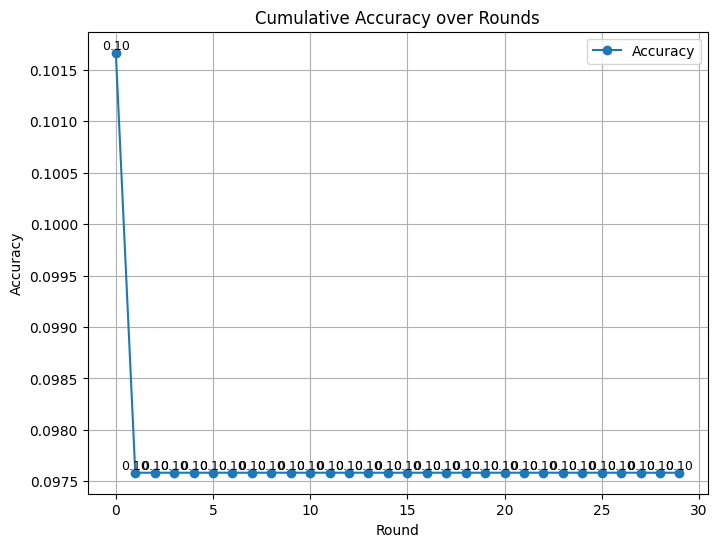

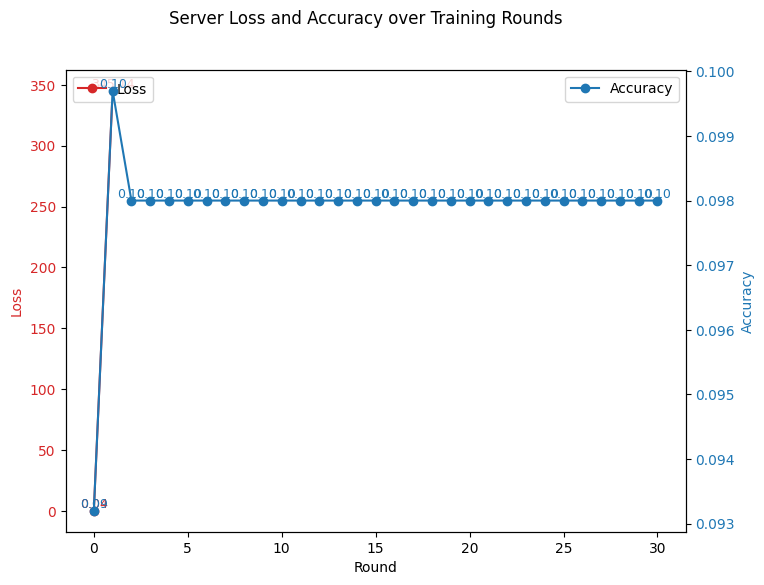

In [ ]:
from flwr.client import ClientApp
from flwr.client.mod import LocalDpMod

# Create an instance of the mod with the required params
local_dp_obj = LocalDpMod(clipping_norm = 1,
                          sensitivity = 0.11,
                          epsilon = 0.1 ,
                          delta = 0.1,
                          )

# Add local_dp_obj to the client-side mods
local_app = ClientApp(
    client_fn=client_fn,
    mods=[local_dp_obj],
)

run_my_sim(
    strategy = strategy,
    num_rounds = Num_rounds,
    num_clients = NUM_CLIENTS,
    Clientapp = local_app ,
)